# <center >$\textbf{M LAB COMPUTATIONAL PROJECT}$ - $\textbf{CLASSICAL MONTE CARLO SIMULATIONS}$ </center>

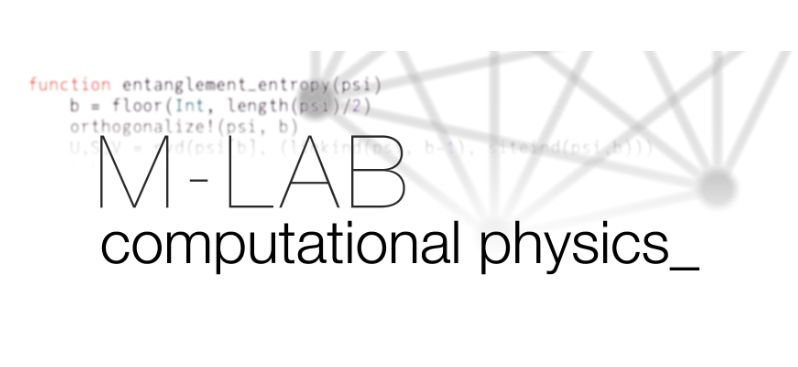

# <center> **Author**: Hari Prasad Sreekrishnapurath Variyam </center>
#### <center>  Matriculation Number - 7419638 </center>



# Setup Code

In [1]:
#import neccessary libraries.
import scienceplots
import matplotlib.pyplot as plt ; import matplotlib
import numpy as np
from numba import jit
import pandas as pd
from tqdm import tqdm
from scipy.integrate import simps
#plotting parameters
matplotlib.rcParams['figure.dpi']=300
plt.style.use(['science','grid','notebook','no-latex'])
#Define convolution kernel
kernel = np.array([[1,1,0],[1,0,1],[0,1,1]])



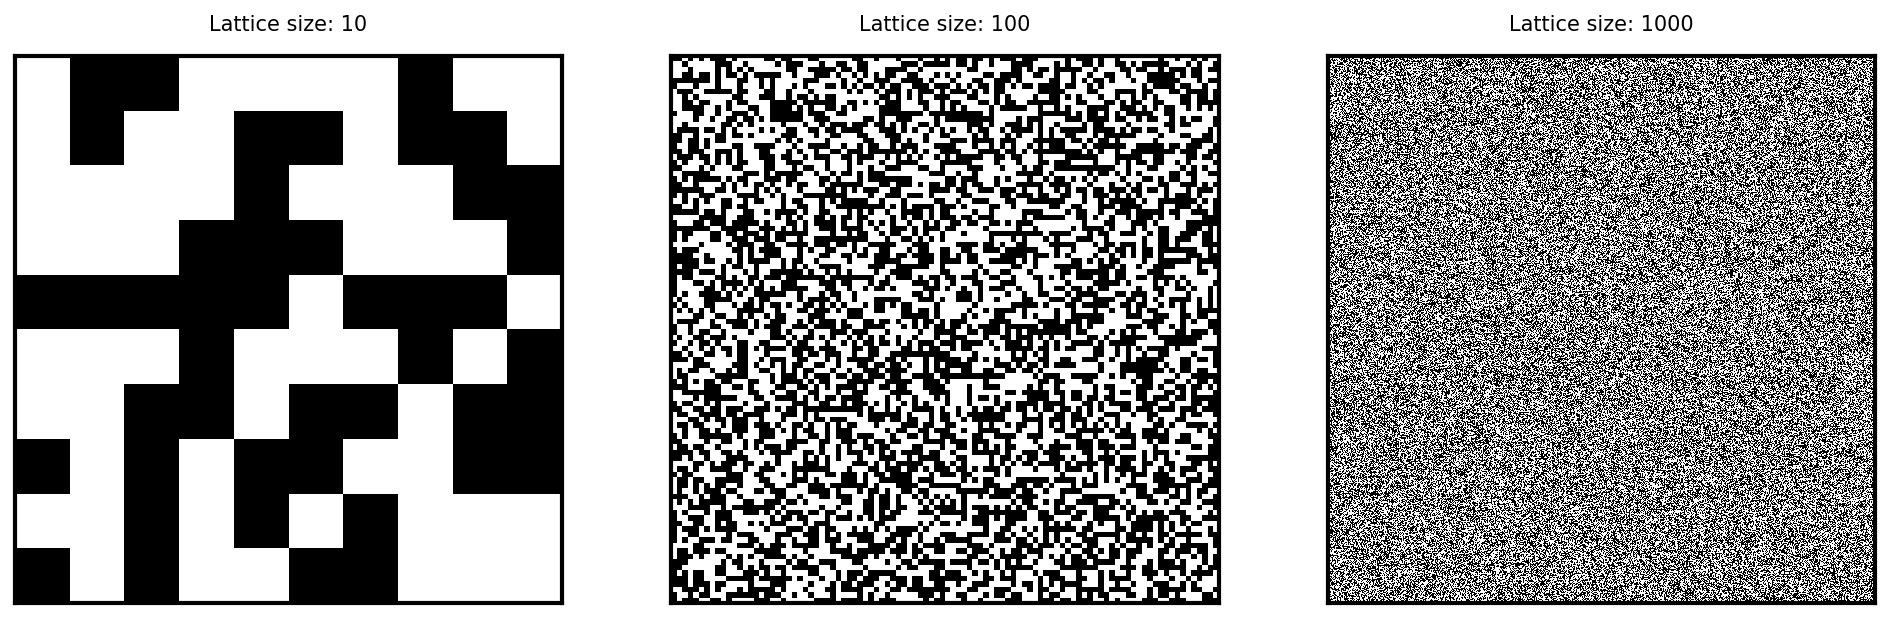

In [2]:
#Plot random lattices with different sizes
@jit(nopython=True)
def init_lattice(L):
  '''
  parameters : L : int, lattice size (LxL)
  returns : lattice ;array_like, Lattice mesh 
  '''
  lattice = 2 * np.random.randint(0, 2, L**2) - 1 ##arrange [-1,+1] spins accordingly
  return lattice.reshape(L,L)

sizes = [10,100,1000]
fig, axs = plt.subplots(1, 3)

for i,size in enumerate(sizes):
  lattice = init_lattice(size)
  ax = axs[i]
  ax.pcolormesh(lattice,cmap='binary')
  ax.set_aspect('equal')
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_title(f'Lattice size: {size}',fontsize=5)


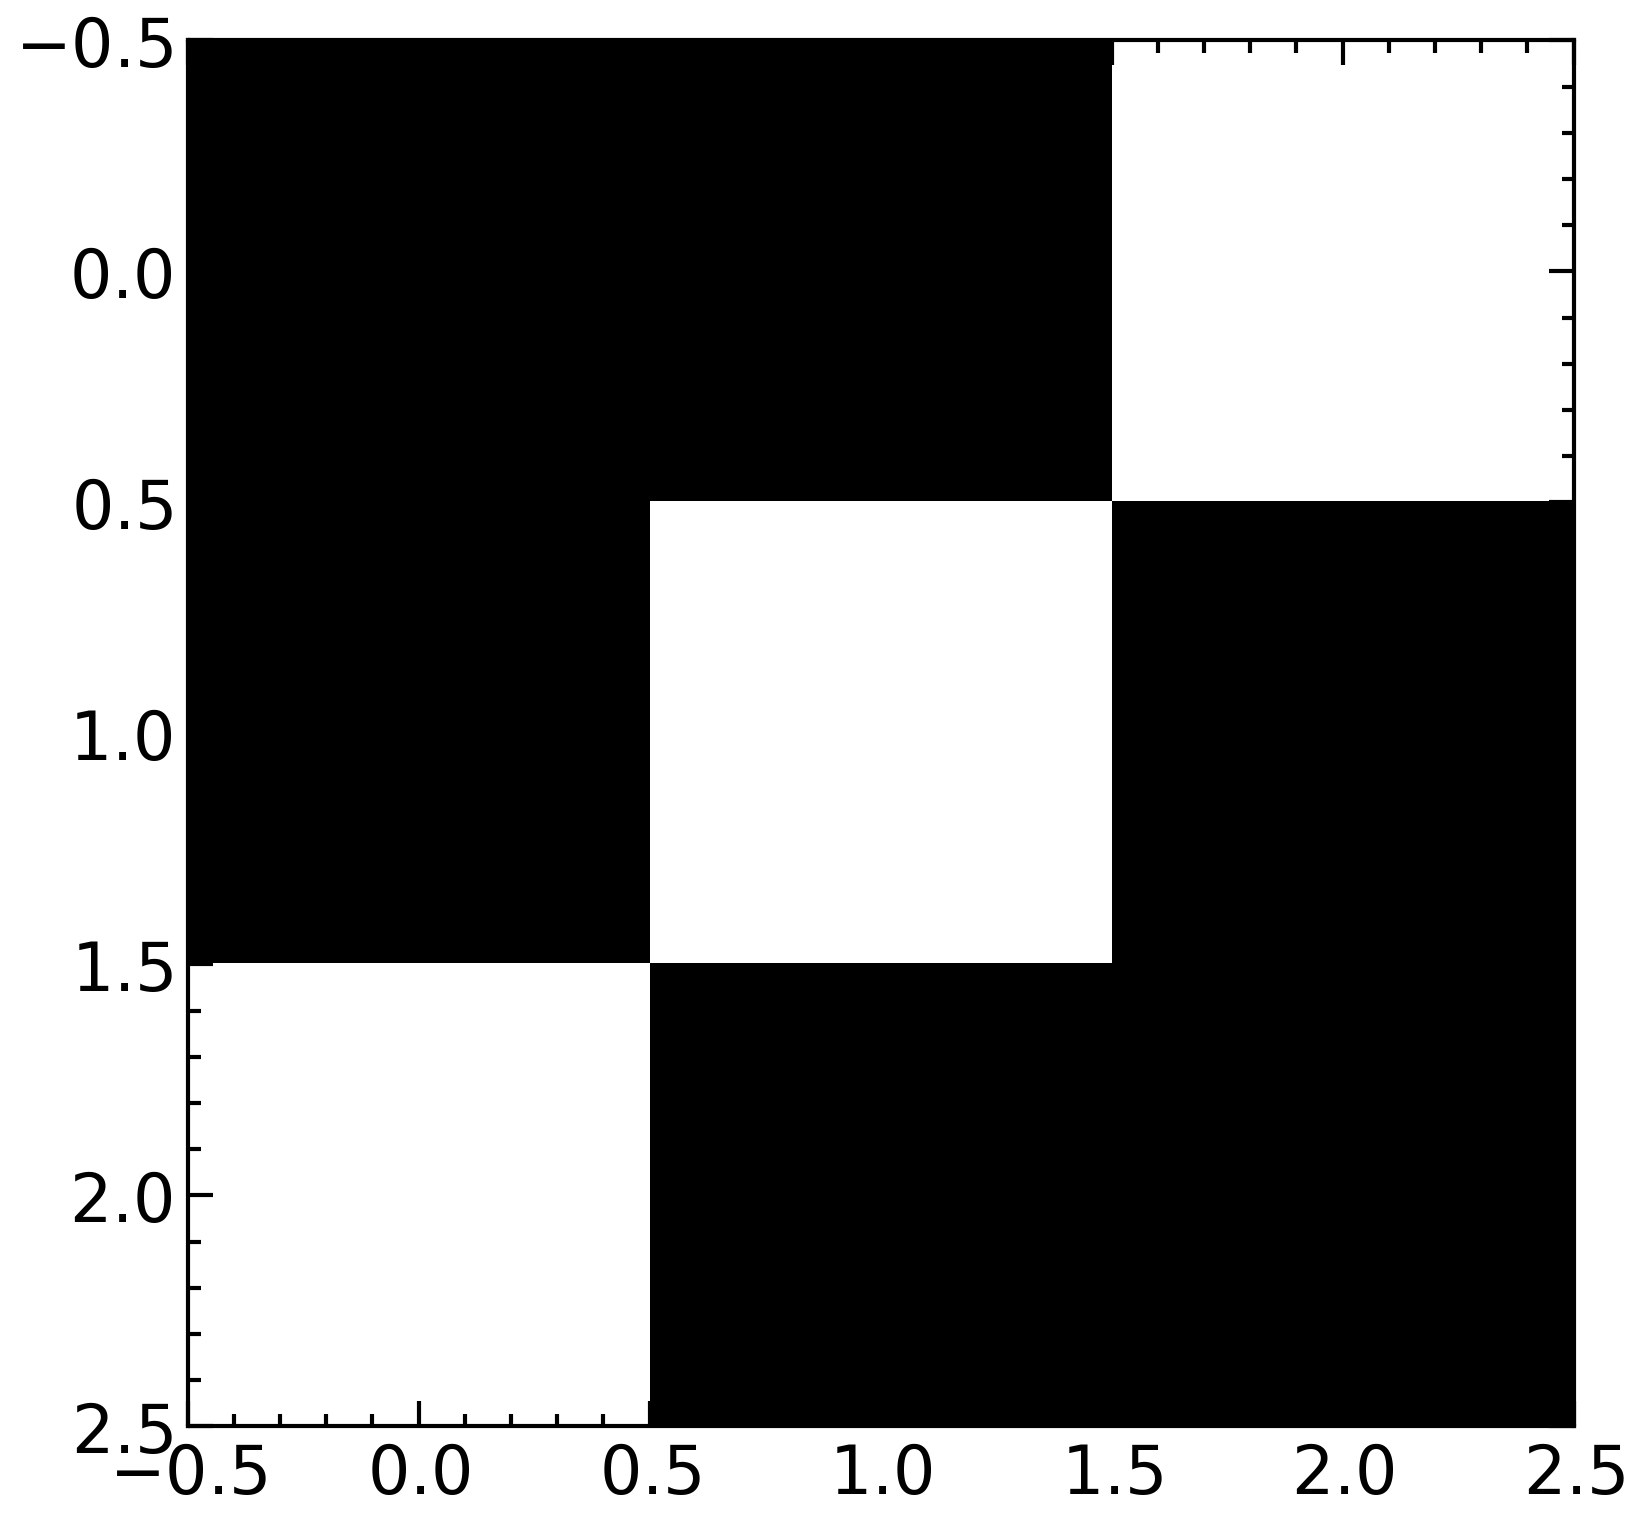

In [3]:
#Convolution kernel
plt.imshow(kernel,cmap='binary')
plt.grid()
plt.savefig('kernel.png',dpi=300)

In [7]:
#code that checks for periodic boundary . Custom implementation of np.roll function to integrate with Numba JIT
@jit(nopython=True)
def custom_roll(arr, shift, axis):
    if axis == 0:
        return np.concatenate((arr[-shift:], arr[:-shift]), axis=0)
    elif axis == 1:
        return np.concatenate((arr[:, -shift:], arr[:, :-shift]), axis=1)

#Find the moore neighbourhood of of an array index (x,y)
@jit(nopython=True)
def find_neighbors(arr, x, y, n=3):
    arr = custom_roll(custom_roll(arr, -x + 1, axis=0), -y + 1, axis=1)
    return arr[:n, :n]


The Ising hamiltonian is defined as follows. This will be used to calculate the energy of the system.

\begin{equation}
\boxed{\mathcal{H}_{ising} = J \sum_{<i,j>} \sigma_i \sigma_j - B \sum_{i} \sigma_i} 
\end{equation}

In [8]:
#Calculate energy of the configuration using the expression above. 
@jit(nopython=True)
def calculate_energy(configuration,J,B):
  '''
  parameters : configuration : array_like, Input lattice.
               J : float, Spin Coupling constant.
               B : float, External field.

  returns    : energy_tot : float, Computed energy due to the spin flip
  '''
  energy = 0
  #loop through the configuration and perform convolution operation
  for i in range(len(configuration)):
    for j in range(len(configuration)):
      energy += J * configuration[i,j] * (find_neighbors(configuration,i,j)*kernel).sum()

  energy_tot = (0.5)*energy - B * configuration.sum()
  return energy_tot

In [9]:
#Calculate the energy difference due to a proposed spin flip.
@jit(nopython=True)
def markov_step_energy_diff(i,j,lattice,J,B):
  '''
  parameters : i,j : int, Array index of the spin
             : lattice : array_like , Lattice with random spins
             : J : float, Spin Coupling constant.
             : B : float, External field.

  returns    : delta_E : Energy difference due to the spin flip.
  '''
  #Propose a spin flip by taking one spin value
  spin = lattice[i,j]
  nearest_neighbors = find_neighbors(lattice,i,j)
  delta_E = -2*(J*spin*(nearest_neighbors*kernel).sum() - B*lattice[i,j])
  return delta_E

In [10]:
#Perform a markov sweep
@jit(nopython=True)
def metropolis_dynamics(lattice,J,B,beta):
  '''
  parameters : lattice : array_like, Input lattice.
               J : float, Spin Coupling constant.
               B : float, External field.
               beta : float, Inverse of temperature.
  
  returns    : configuration : array_like, lattice which has performed one markov sweep.
  '''
  configuration = lattice.copy()
  L = int(len(configuration)) #linear size
  step = 0
  steps = int(L**2) #perform sweep through all elements of the lattice
  while step<steps:
    i,j = np.random.randint(0,L),np.random.randint(0,L) #Select random spin
    delta_E = markov_step_energy_diff(i,j,configuration,J,B) #Perform spin flip and calculate the energy due to it.
    if np.random.uniform(0.0, 1.0) < np.exp(-beta*delta_E): #Perform metropolis hastings dynamics.
      configuration[i,j] *= -1
    step += 1
  return configuration

In [11]:
#Perform monte carlo sampling
@jit(nopython=True)
def markov_chain_mc(lattice,J,B,beta,burn_in,M):
  '''
  parameters : lattice : array_like, Input lattice.
               J : float, Spin Coupling constant.
               B : float, External field.
               beta : float, Inverse of temperature.
               burn_in : int, Burn in time
               M : int, Markov steps
  
  returns    : obs, array_like : Expectation value of observables 
             : m_per_spin,array_like : Magnetisation per spin
             : energy_per_spin, array_like : Energy per spin.
             : energy_per_spin**2, array_like : Square of energy per spin.
  '''
  
  configuration = lattice.copy() #Copy the lattice 
  t = 0 
  L = int(len(configuration)) #Size of the lattice (linear)
  
  #Perform Burn in 
    
  while t<int(burn_in):
    configuration = metropolis_dynamics(configuration,J,B,beta) #run till burn in phase
    t += 1
  m_per_spin = np.zeros(M) ; energy_per_spin = np.zeros(M); m_per_spin_2 = np.zeros(M) #Empty arrays

  #Collect samples
    
  for sample in range(M):
    configuration = metropolis_dynamics(configuration,J,B,beta) #Perform Metropolis Hastings dynamics
    m_per_spin[sample] = ((1/L**2)*(configuration.sum()));
    m_per_spin_2[sample] = ((1/L**2)*(configuration.sum()))**2 ;
    energy_per_spin[sample] = ((1/L**2)*calculate_energy(configuration,J,B))

  average_mag = np.mean(m_per_spin) ; average_E = np.mean(energy_per_spin) ; average_E_sq = np.mean(energy_per_spin**2)
  obs  = np.array([average_mag,average_E,average_E_sq])

  return obs,m_per_spin,m_per_spin_2,energy_per_spin,energy_per_spin**2

# 3.1 J < 0 - Ferromagnet , B = 0

## 3.1.1 $\textit{Temperature Refinement}$

In [ ]:
#Sample more temperature points between [3,4] (critical window).

temps = np.concatenate([np.linspace(1,3,20),np.linspace(3,4,30),np.linspace(4,6,20)])
beta = 1/temps #Take inverse of temperatures.

observables = np.zeros((len(beta),3)) #Make an obeservable array to append neccessary values.
J,B = -1,0 #Set J and B to zeros.
L = [10,20,40,80] #Lattice sizes
#Save it to a CSV file
def create_file(matrix,L):
  df = pd.DataFrame(matrix,columns = ['<M>','<E>','<E_2>'])
  df.to_csv(f'lattice_obs_{L}.csv',index=False)
  return None

burn_in = 600
M = 2*10000

#Perform computation based on the parameters
for i in L:
  for j in tqdm(range(len(beta))):
    lattice = init_lattice(i)
    observables[j,:],_,_ = markov_chain_mc(lattice,J,B,beta[j],burn_in,M)
    create_file(observables,i)


In [2]:
temps = np.concatenate([np.linspace(1,3,20),np.linspace(3,4,30),np.linspace(4,6,20)])
data_20_fm = pd.read_csv('datafiles/lattice_obs_20.csv')

Definition of mean square magnetisation


\begin{equation}
\boxed{\langle M^2 \rangle = \left ( \frac{1}{L^2} \sum_{i} s_i \right)^2}
\end{equation}

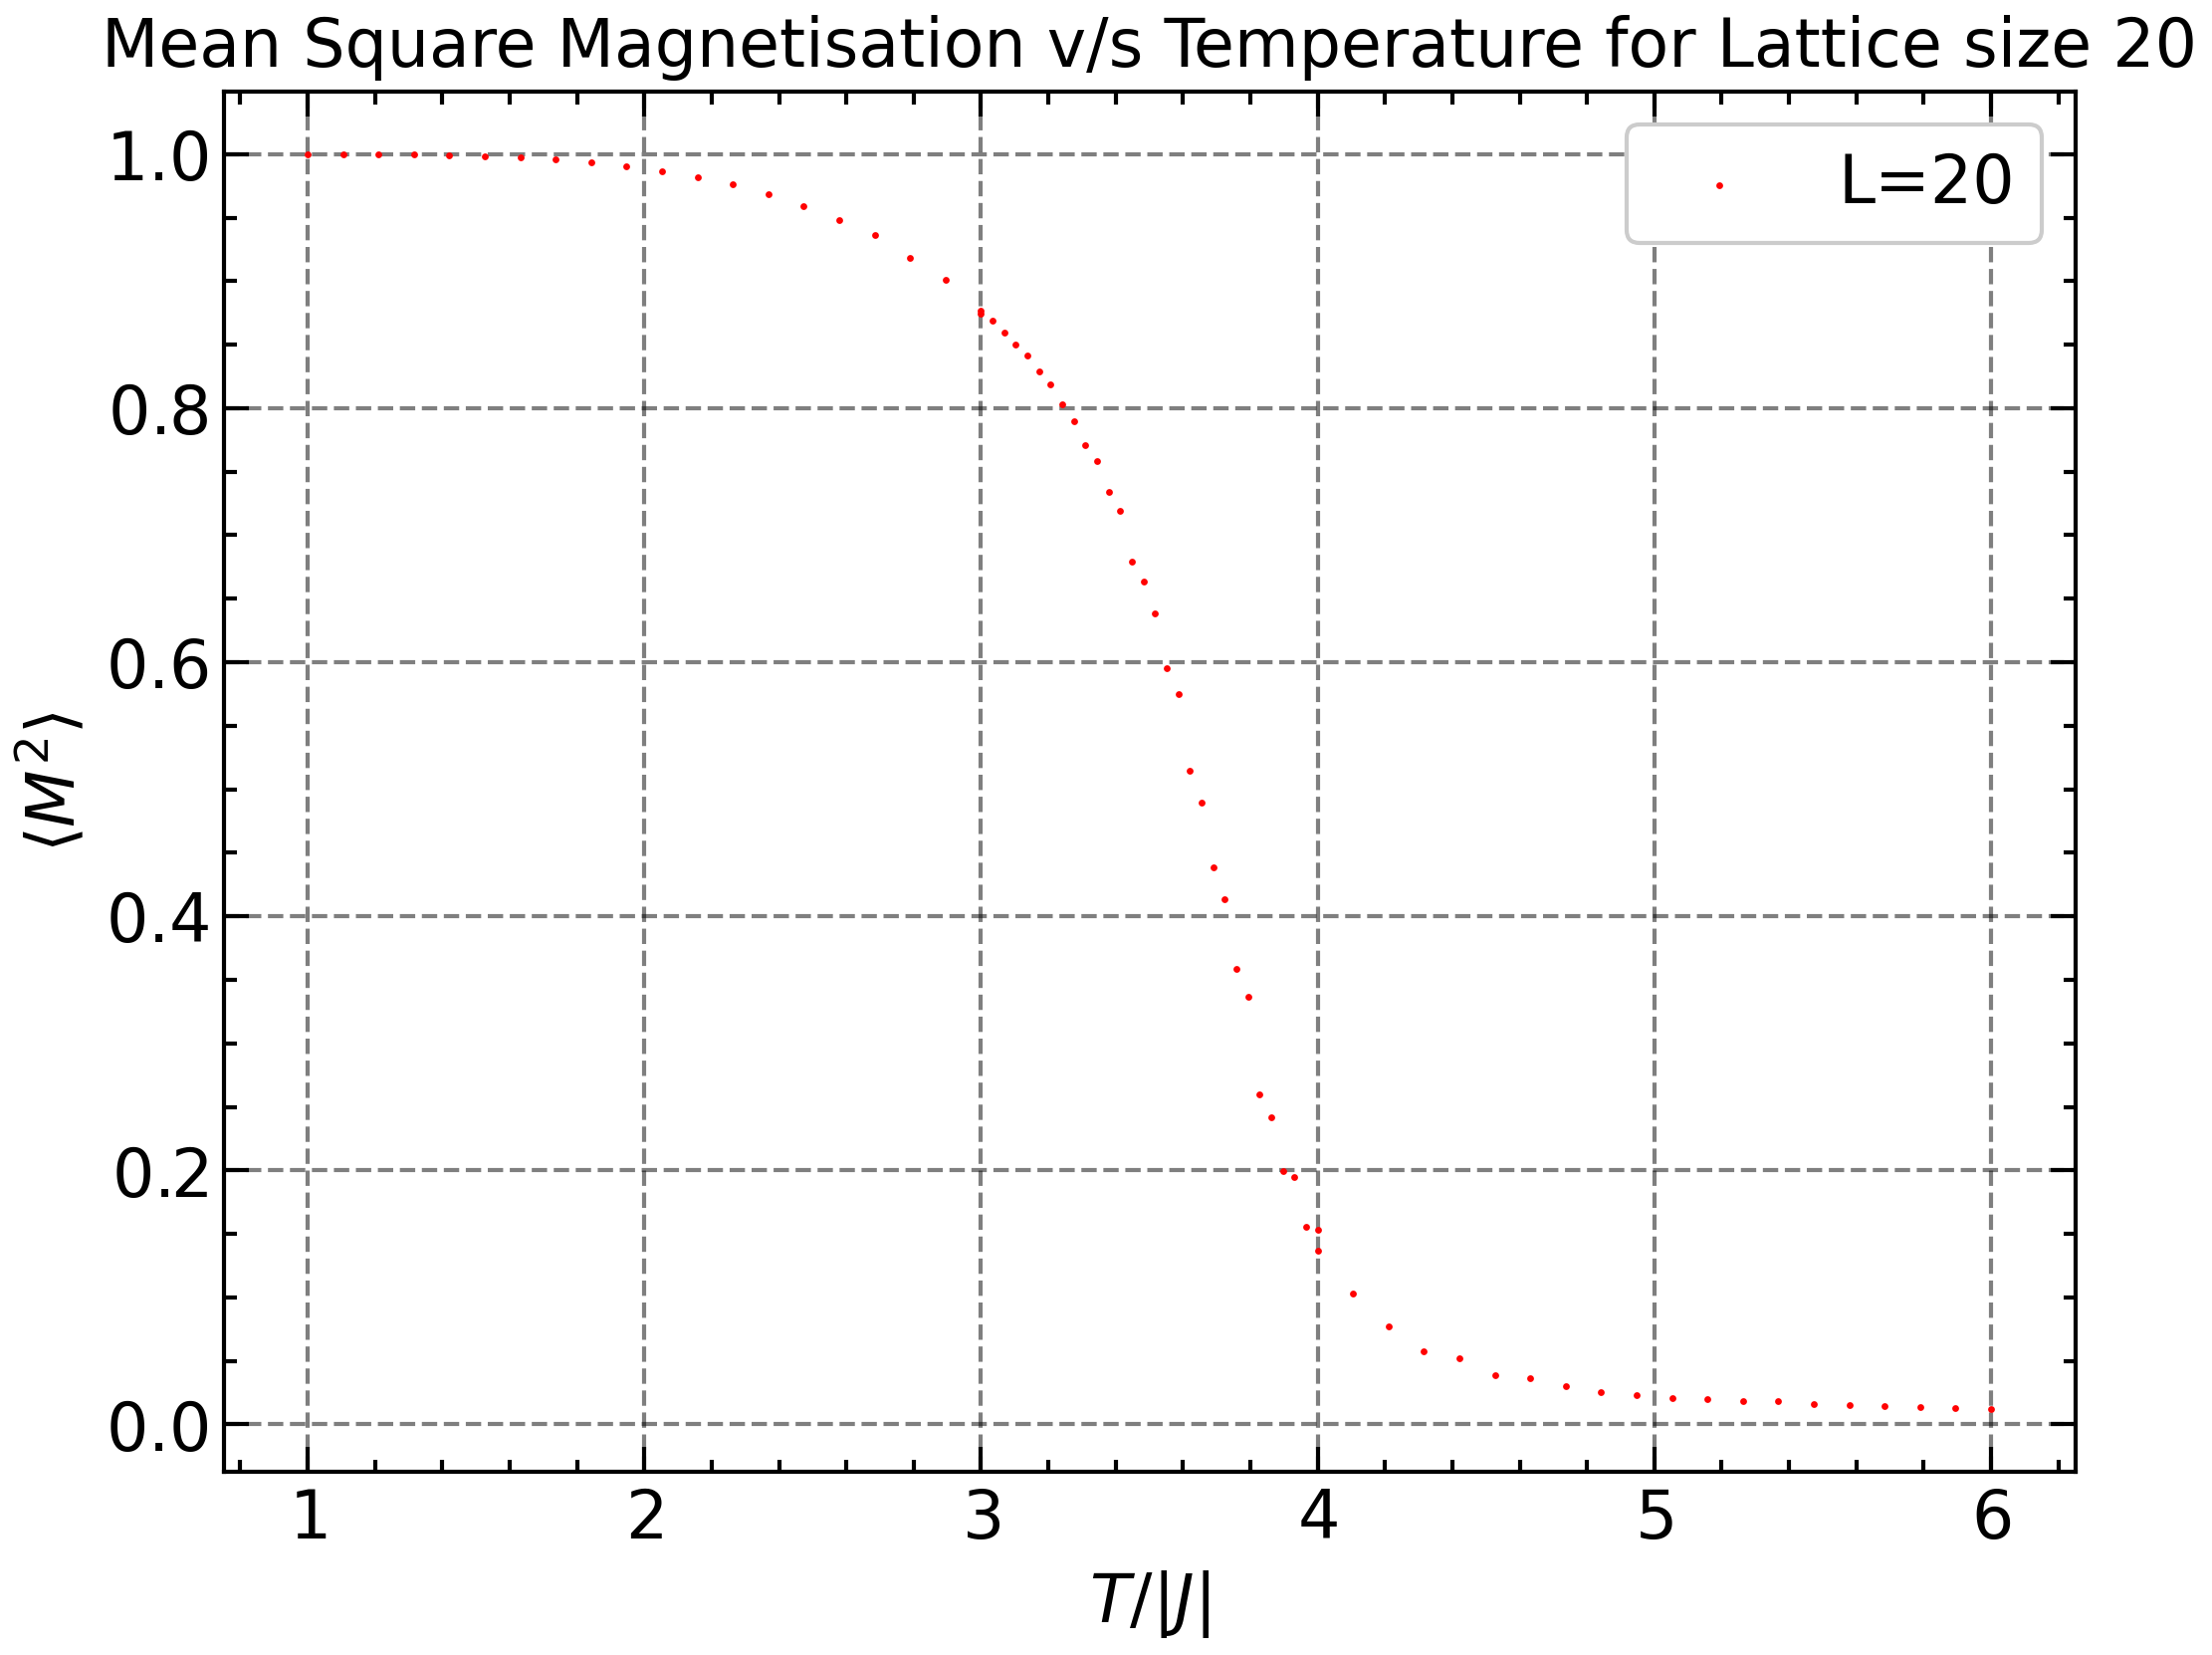

In [4]:
plt.scatter(temps,data_20_fm['<M>'],s=0.4,label='L=20',color='r')
plt.xlabel(r'$T/|J|$')
plt.ylabel(r'$\langle M^2 \rangle$')
plt.title('Mean Square Magnetisation v/s Temperature for Lattice size 20')
plt.legend()
#plt.savefig('lattice_20_m.png',dpi=300)

## 3.1.2 $\textit{Autocorrelation estimation}$

The autocorrelation function at different times can be defined as,

\begin{equation}
    \boxed{\gamma (t) = \frac{[\mathbb{E}\left[\mathcal{O}(s_n) \mathcal{O}(s_{n+1}) \right] - (\mathbb{E}[\mathcal{O}(s)])^2]}{Var(\mathcal{O}(s))}}
\end{equation}


In [18]:
#Define Autocorrelation Function, using the expression above.
def auto_correlation(lattice,J,B,M,beta,time):
  '''
  parameters : lattice : array_like, Input lattice.
               J : float, Spin Coupling constant.
               B : float, External field.
               beta : float, Inverse of temperature.
               time : list, Autocorrelation times
               
  returns    : gammas_m : list, Magnetiation autocorrelation at different times
             : gammas_E : list, Energy autocorrelation at different times
  '''
        
  configuration = lattice.copy()
  L = int(len(configuration))

  mag_sq = np.zeros(M) ; e_sq = np.zeros(M)

  for sample in range(M):
    configuration = metropolis_dynamics(configuration,J,B,beta)
    mag_sq[sample] = np.mean(configuration)**2
    e_sq[sample] = calculate_energy(configuration,J,B)/L**2


  avg_m_sq_2 = np.mean(mag_sq)**2
  var_msq = np.var(mag_sq)
  avg_E_2 = np.mean(e_sq)**2
  var_E = np.var(e_sq)

  gamma_E = [] ; gamma_m = []

  for t in tqdm(range(time)):
    gamma_m.append((np.mean(mag_sq * np.roll(mag_sq,-t)) - avg_m_sq_2)/var_msq)
    gamma_E.append((np.mean(e_sq * np.roll(e_sq,-t)) - avg_E_2)/var_E)

  return gamma_m,gamma_E


In [19]:
from tqdm import tqdm
T = np.array([1.10, 3.52, 5.73]) ; betas = 1/T #Compute autocorrelation at T<T_c , T~T_c and T > T_c
J,B,M = -1,0,2*10**4 # Set J, B and M
lattice = init_lattice(40)
times = 1000 # Timesteps
gammasm = []
gammasE = []
for beta in betas: # Initialize lattice size 40
  gamma_m,gamma_E = auto_correlation(lattice,J,B,M,beta,times)
  gammasm.append(gamma_m),gammasE.append(gamma_E) #


100%|██████████████████████████████████████████████| 1000/1000 [00:00<00:00, 10103.10it/s]


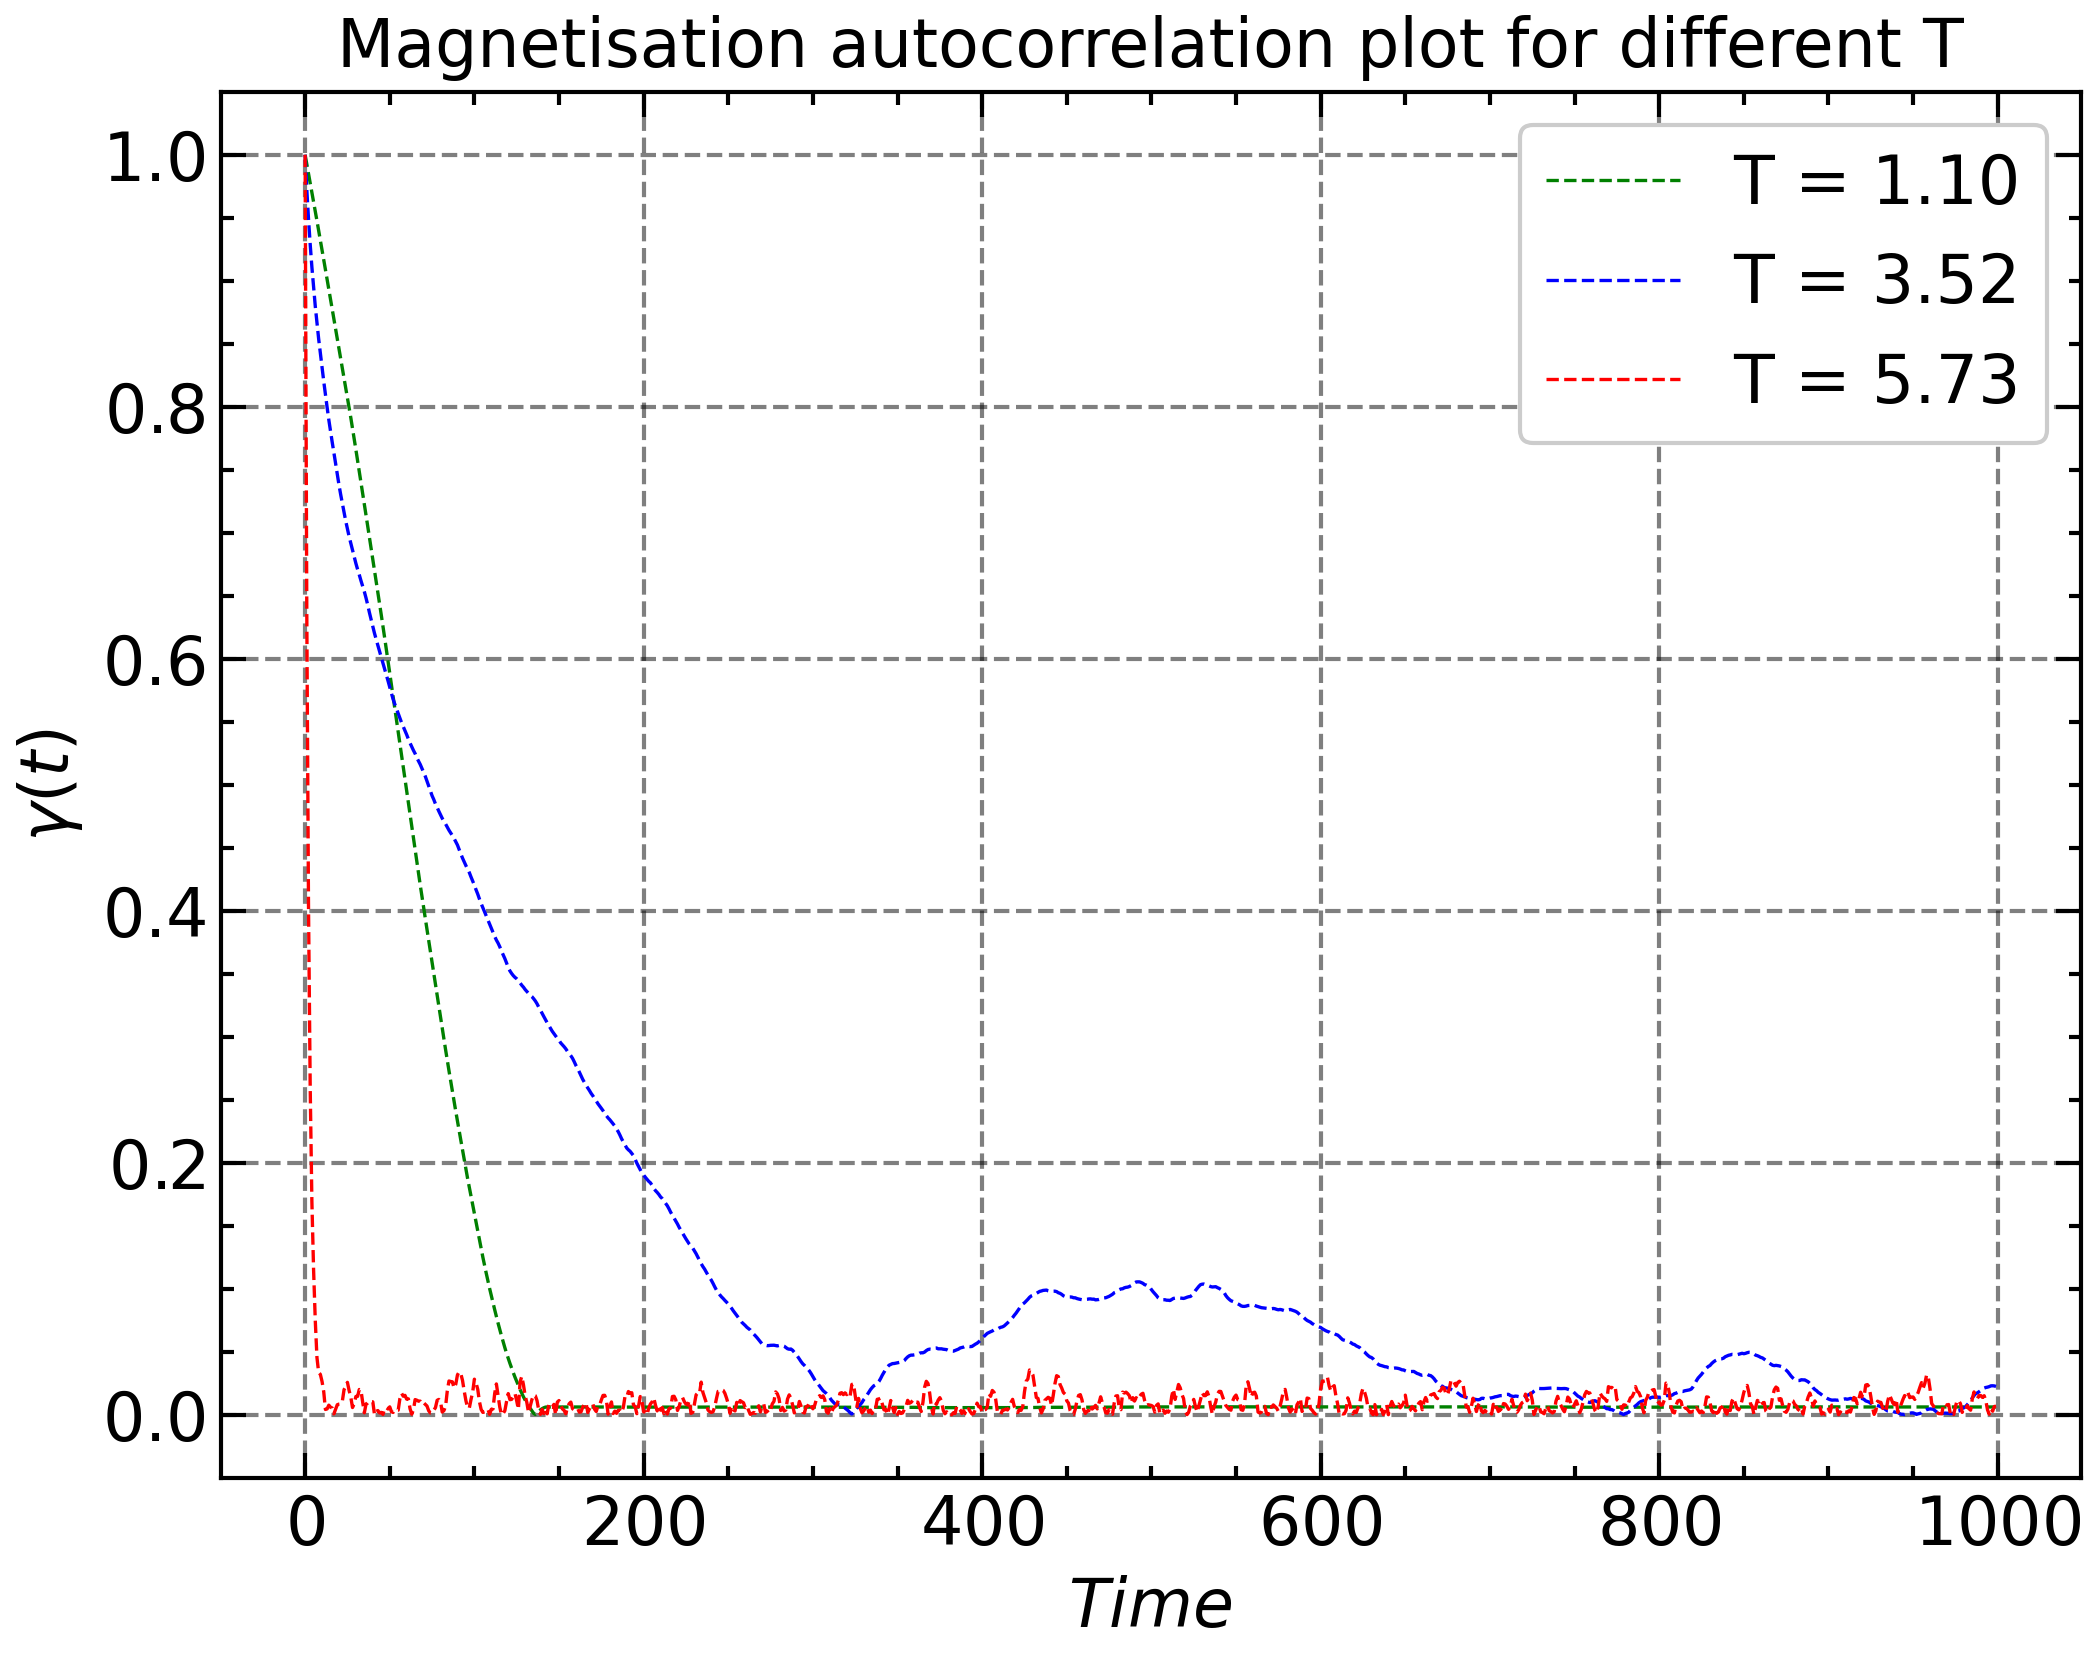

In [29]:
#Stack the arrays
correlations_m = np.vstack(gammasm)
correlations_E = np.vstack(gammasE)

correlations_m = abs(correlations_m)
correlations_E = abs(correlations_E)

times = np.arange(0,1000,1)

plt.plot(times,correlations_m[0],'--',lw=0.80,label='T = 1.10',color='g')
plt.plot(times,correlations_m[1],'--',lw=0.80,label='T = 3.52',color='b')
plt.plot(times,correlations_m[2],'--',lw=0.80,label='T = 5.73',color='r')
plt.xlabel(r'$Time$')
plt.ylabel(r'$\gamma(t)$')
plt.title('Magnetisation autocorrelation plot for different T')
plt.legend(loc='upper right')
#plt.savefig('autocorr_m.png',dpi=300)
plt.show()

In [ ]:
with open('auto_m.npy', 'wb') as f:
    np.save(f, correlations_m)
with open('auto_E.npy', 'wb') as g:
    np.save(g, correlations_E)

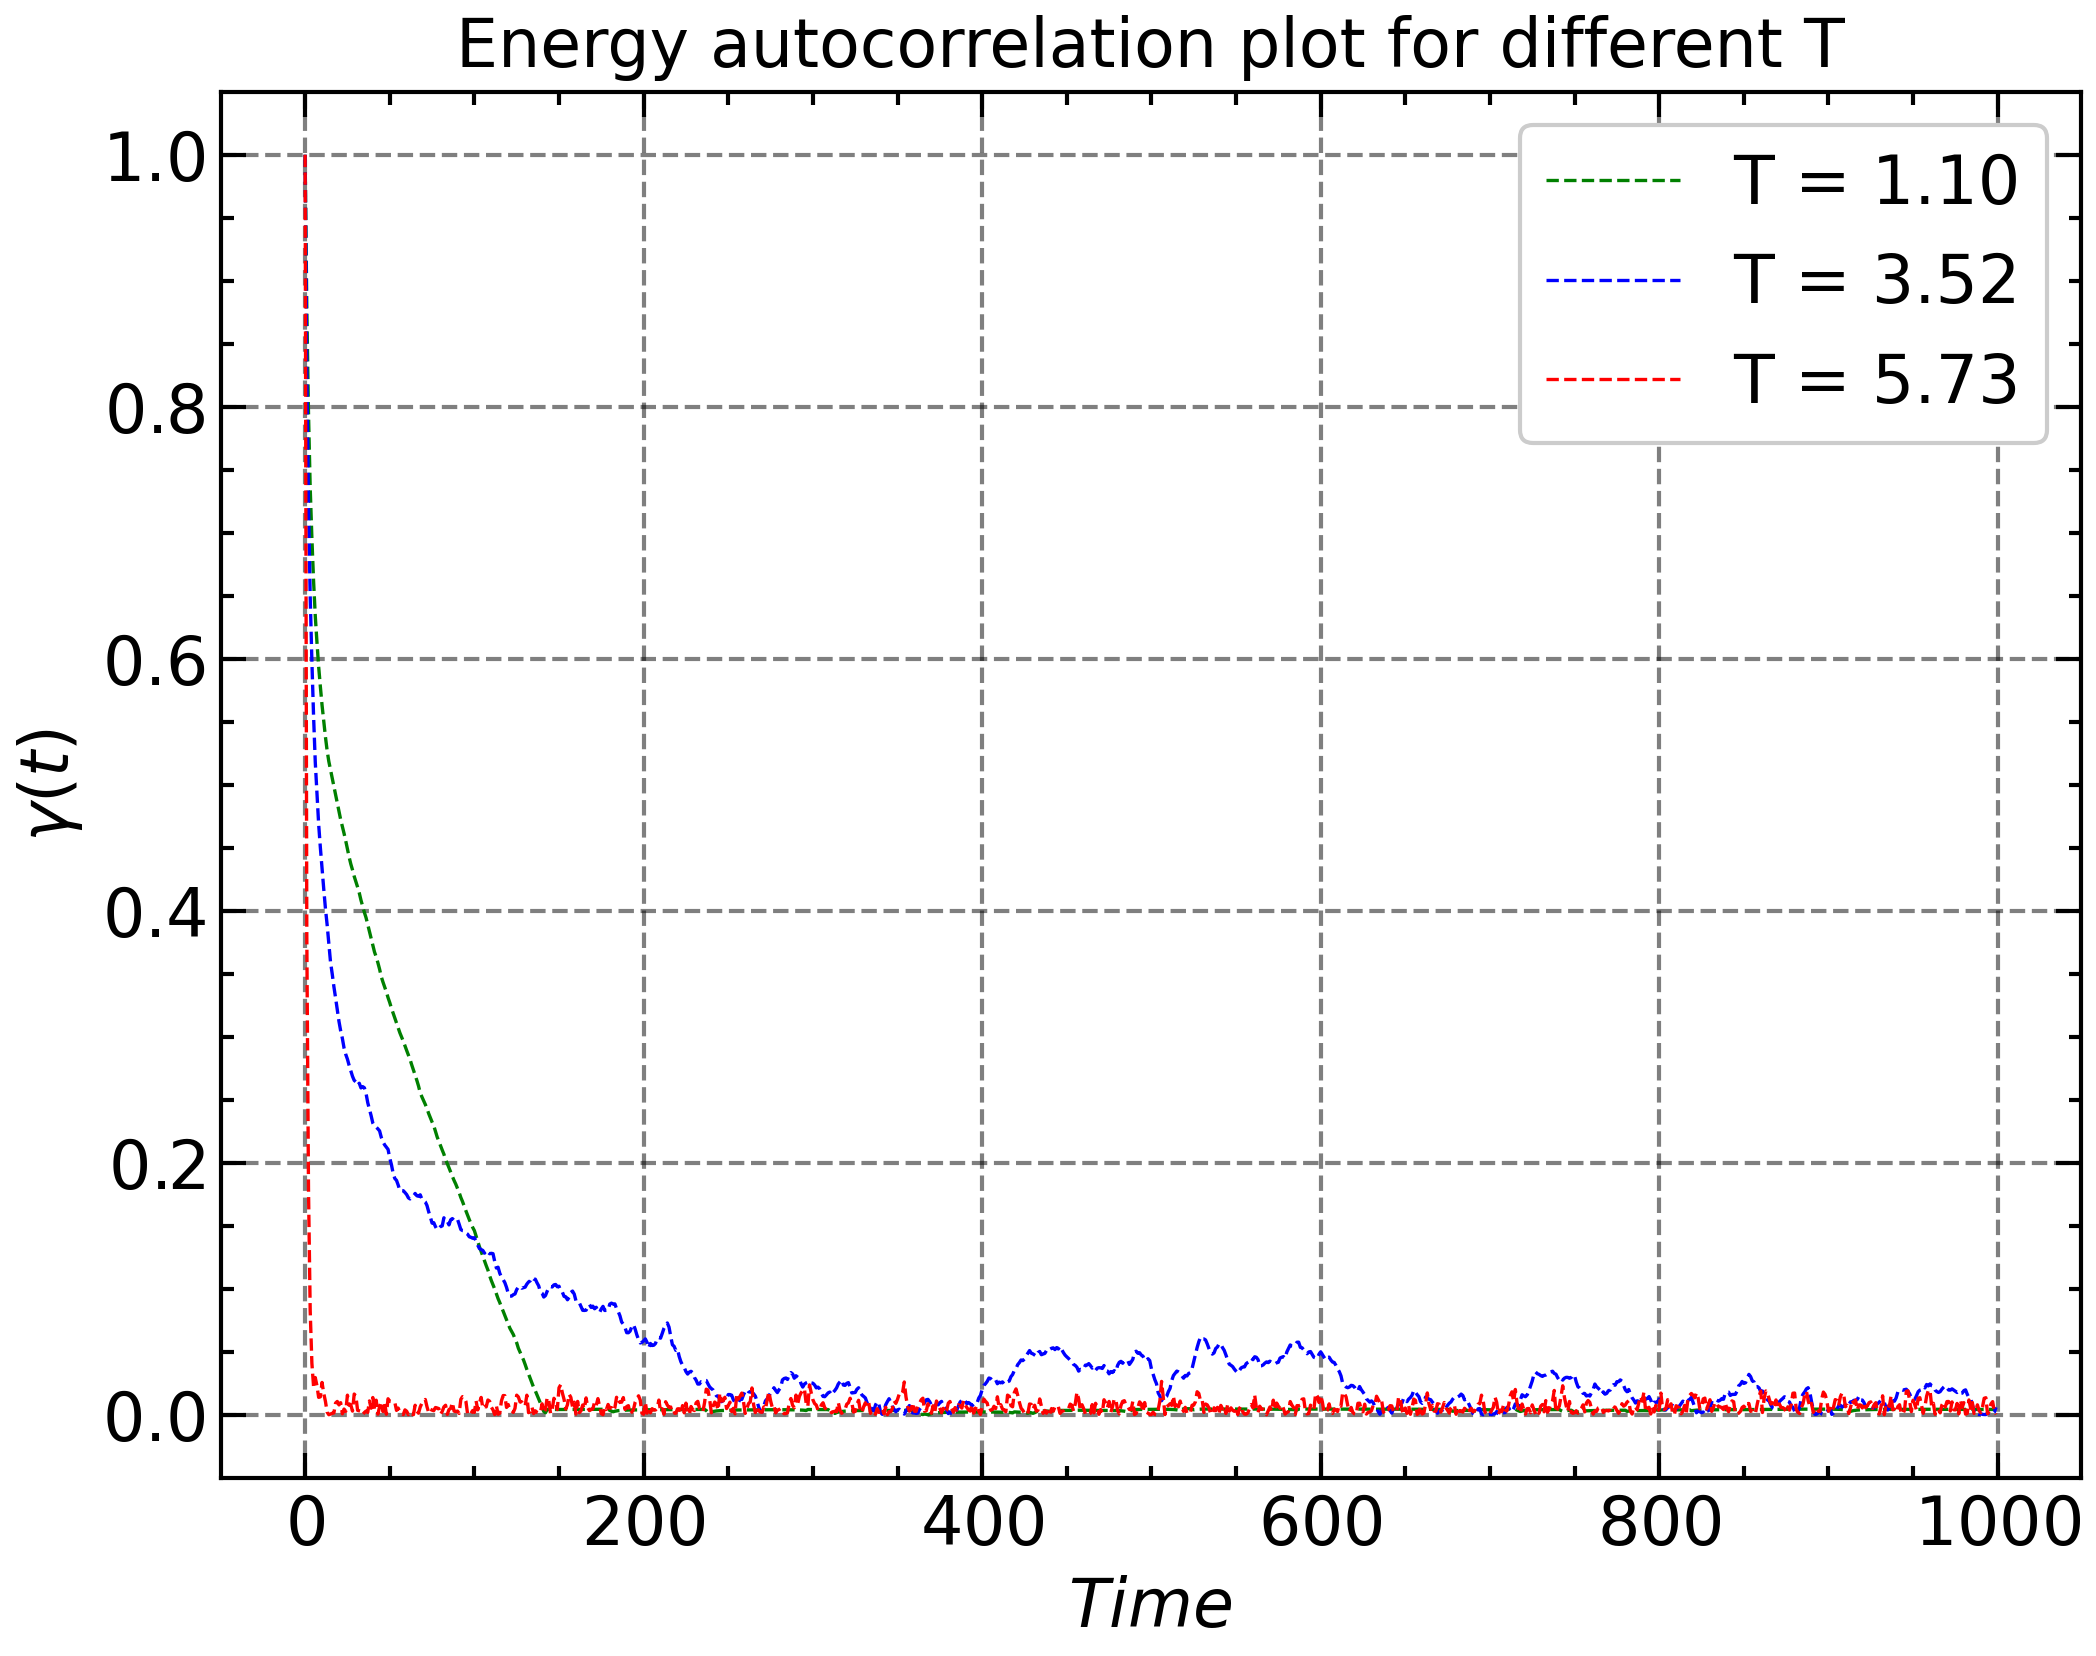

In [28]:
fig, ax = plt.subplots()
ax.plot(times,correlations_E[0],'--',lw=0.80, label='T = 1.10',color='g')
ax.plot(times,correlations_E[1],'--',lw=0.80, label='T = 3.52',color='b')
ax.plot(times,correlations_E[2],'--',lw=0.80, label='T = 5.73',color='r')
ax.set_xlabel(r'$Time$')
ax.set_ylabel(r'$\gamma (t)$')
ax.set_title('Energy autocorrelation plot for different T')
#plt.yscale('log')
ax.legend()
#plt.savefig('autocorr_e.png',dpi=300)
plt.show()


## 3.1.3 $\textit{Binning analysis and autocorrelation time}$

In [30]:
def binning_analyzer(X,k_max):
  '''
  Input = X (ndarray) ; k_max (int)
  returns : error estimates (list)
  code based on the pseudocode provided :
  '''
  M = len(X)
  err = []
  for k in range(1,k_max):
    M_k = M//k
    X_k = X[:int(k * M_k)].reshape(-1,k)
    Xk = np.mean(X_k, axis=1)
    err_est = np.std(Xk)/np.sqrt(M_k)
    err.append(err_est)
  return err

In [31]:
def binned_analysis(lattice,J,B,beta):
  burn_in = 0
  M = 2*10**4
  L = int(len(lattice))

  configuration = lattice.copy()
  L = int(len(configuration))

  mag_sq = np.zeros(M) ; e_sq = np.zeros(M)

  for sample in range(M):
    configuration = metropolis_dynamics(configuration,J,B,beta)
    mag_sq[sample] = np.sum(configuration)/L**2
    e_sq[sample] = calculate_energy(configuration,J,B)/L**2

  mag_sq_2 = mag_sq**2
  e_sq_2 = e_sq**2


  err_m, err_E = binning_analyzer(mag_sq_2,1500),binning_analyzer(e_sq,1500)
  return np.array(err_m),np.array(err_E)

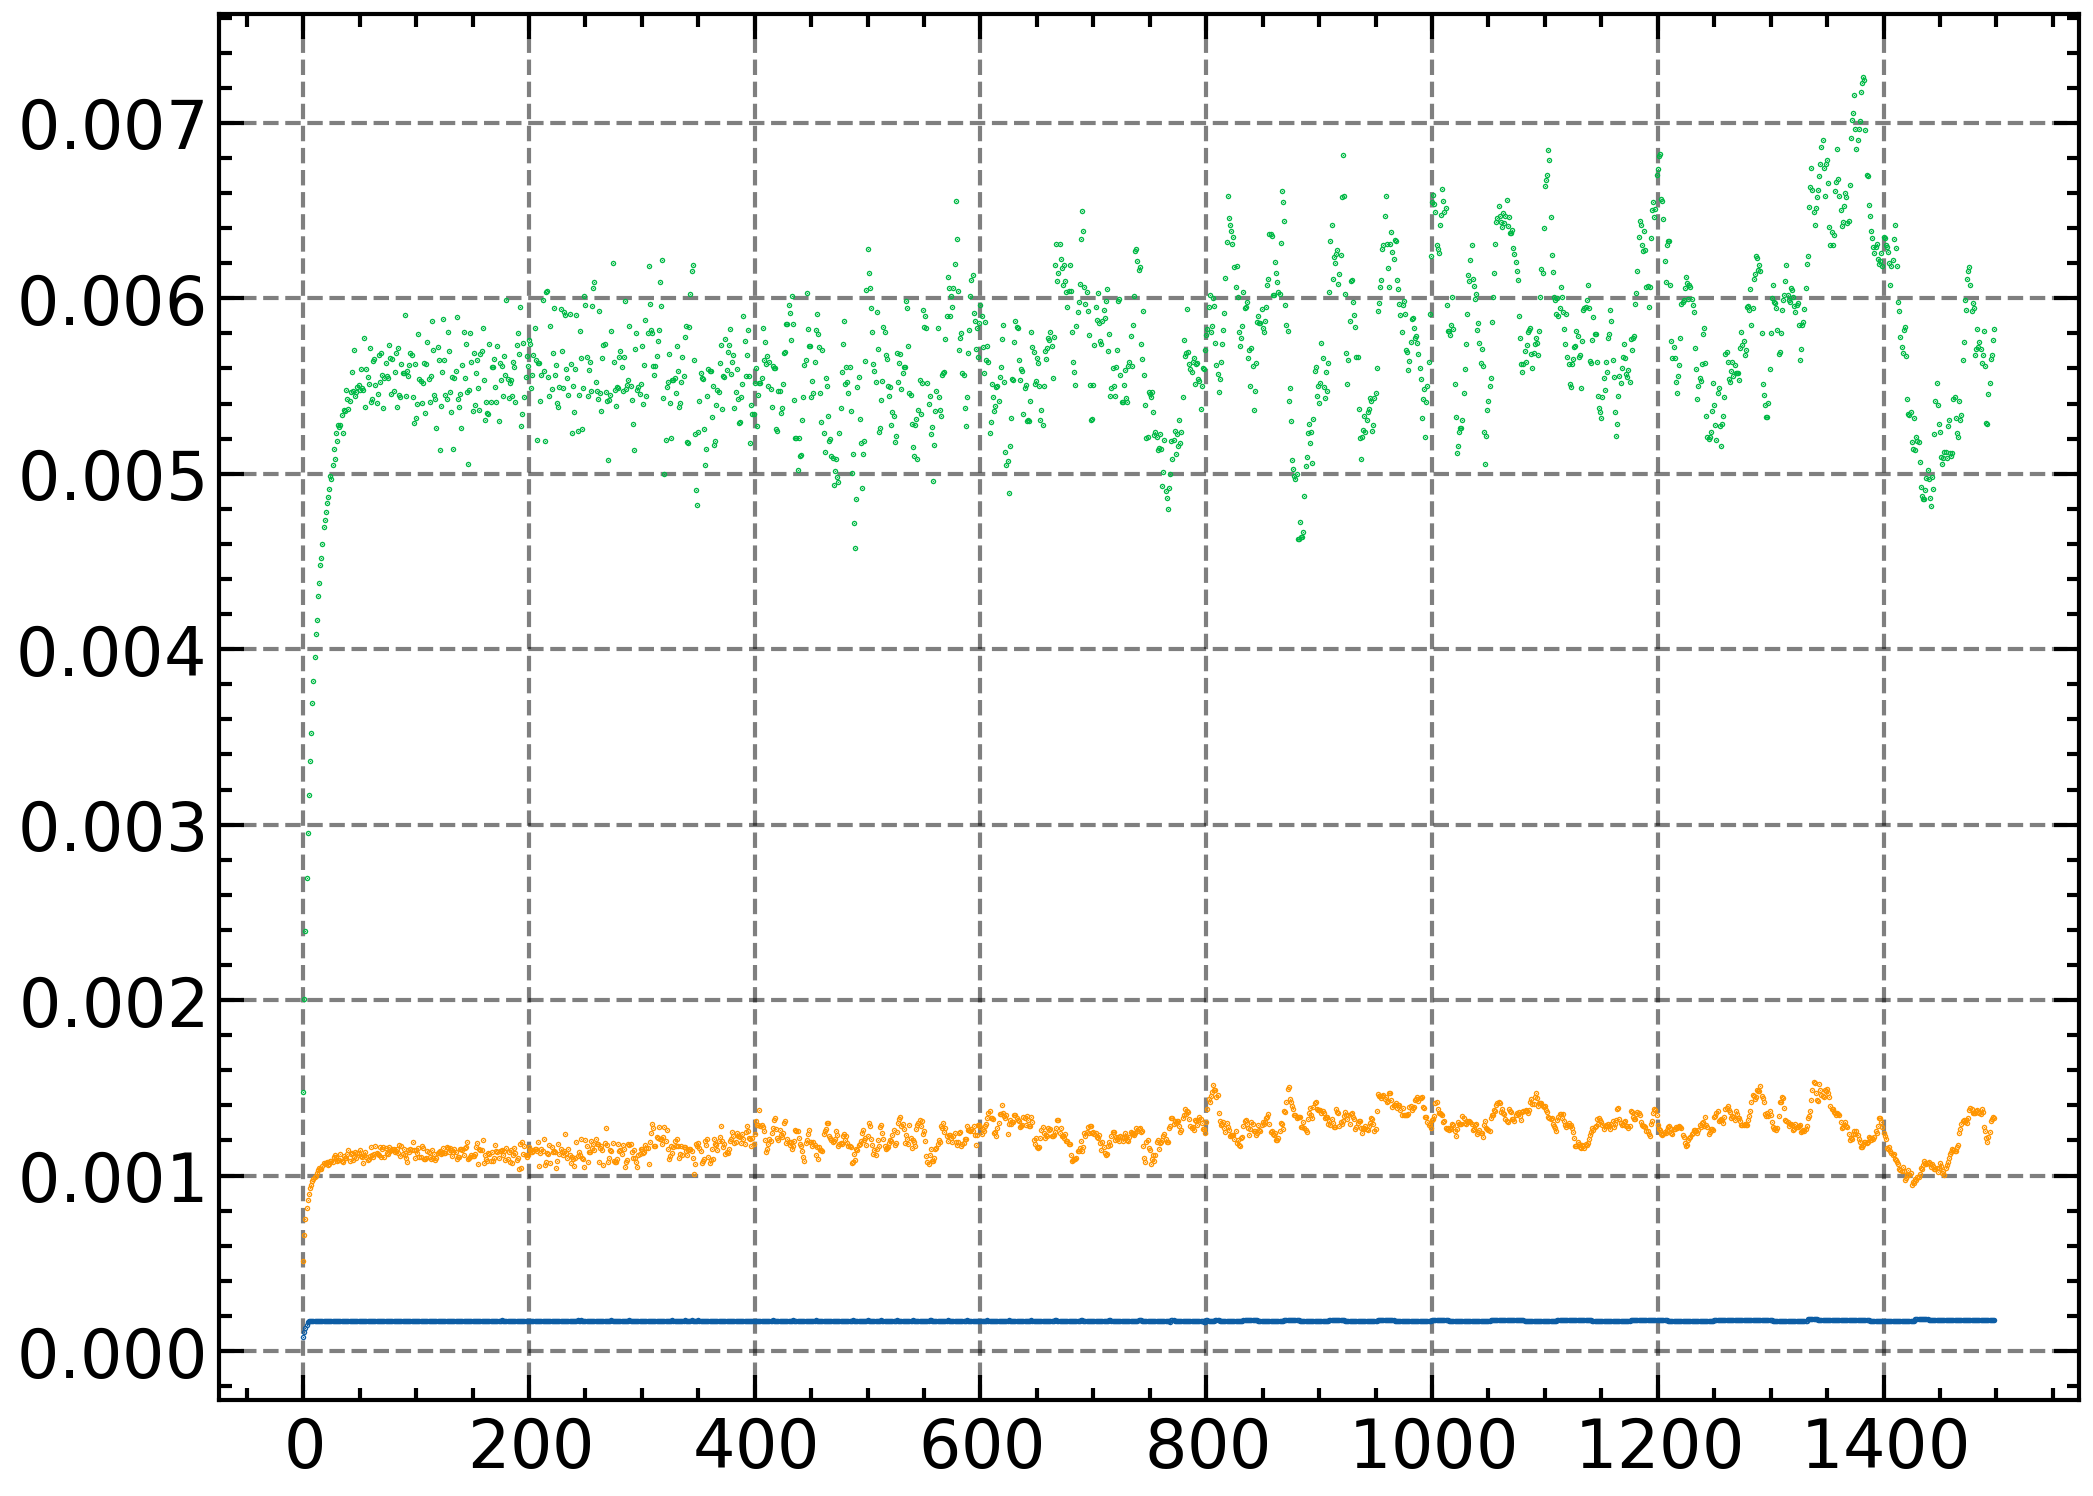

In [32]:
J,B = -1,0
T = np.array([1.10,3.52,5.73]) ; betas = 1/T
bins_lattice_m10 = []  ; bins_lattice_e10 = []
for i in range(len(betas)):
  lattice = init_lattice(10)
  err_m,err_E = binned_analysis(lattice,J,B,betas[i])
  bins_lattice_m10.append(err_m) ; bins_lattice_e10.append(err_E)
  plt.scatter(range(len(err_m)),err_m,s=0.1)

bins_lattice_m10 = np.vstack(bins_lattice_m10) ;
bins_lattice_e10 = np.vstack(bins_lattice_e10)



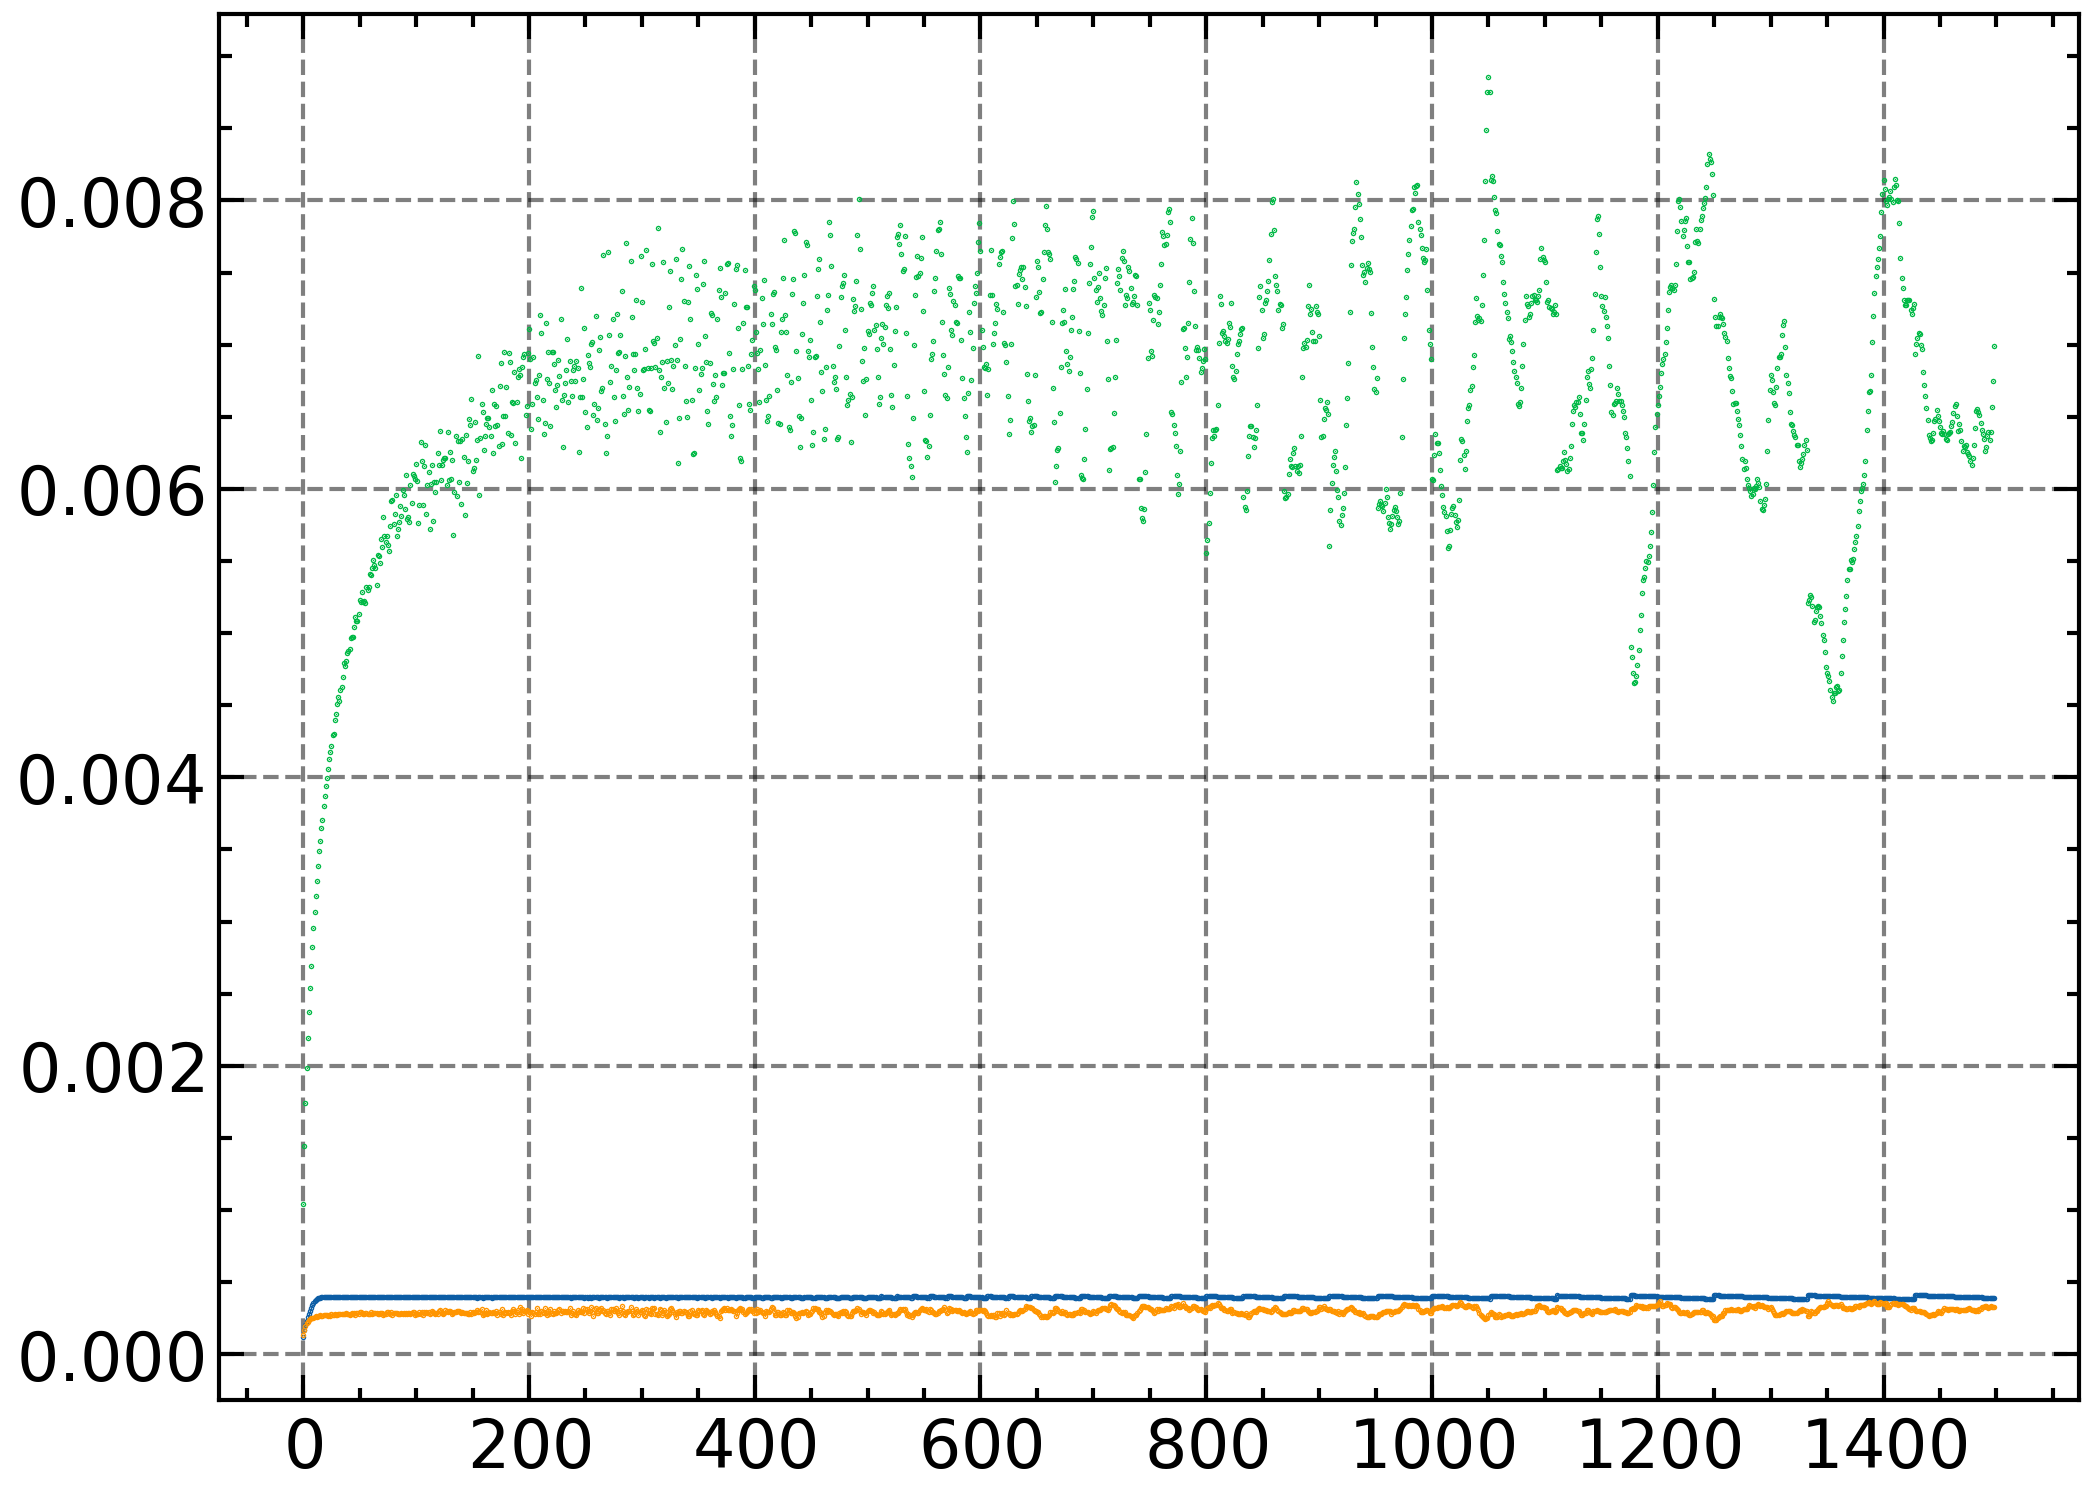

In [34]:
J,B = -1,0
T = np.array([1.10,3.52,5.73]) ; betas = 1/T
bins_lattice_m20 = []  ; bins_lattice_e20 = []
for i in range(len(betas)):
  lattice = init_lattice(20)
  err_m,err_E = binned_analysis(lattice,J,B,betas[i])
  bins_lattice_m20.append(err_m) ; bins_lattice_e20.append(err_E)
  plt.scatter(range(len(err_m)),err_m,s=0.1)

bins_lattice_m20 = np.vstack(bins_lattice_m20) ;
bins_lattice_e20 = np.vstack(bins_lattice_e20)

In [ ]:
with open('bins_m20.npy', 'wb') as f:
    np.save(f, bins_lattice_m20)
with open('bins_e20.npy', 'wb') as g:
    np.save(g, bins_lattice_e20)

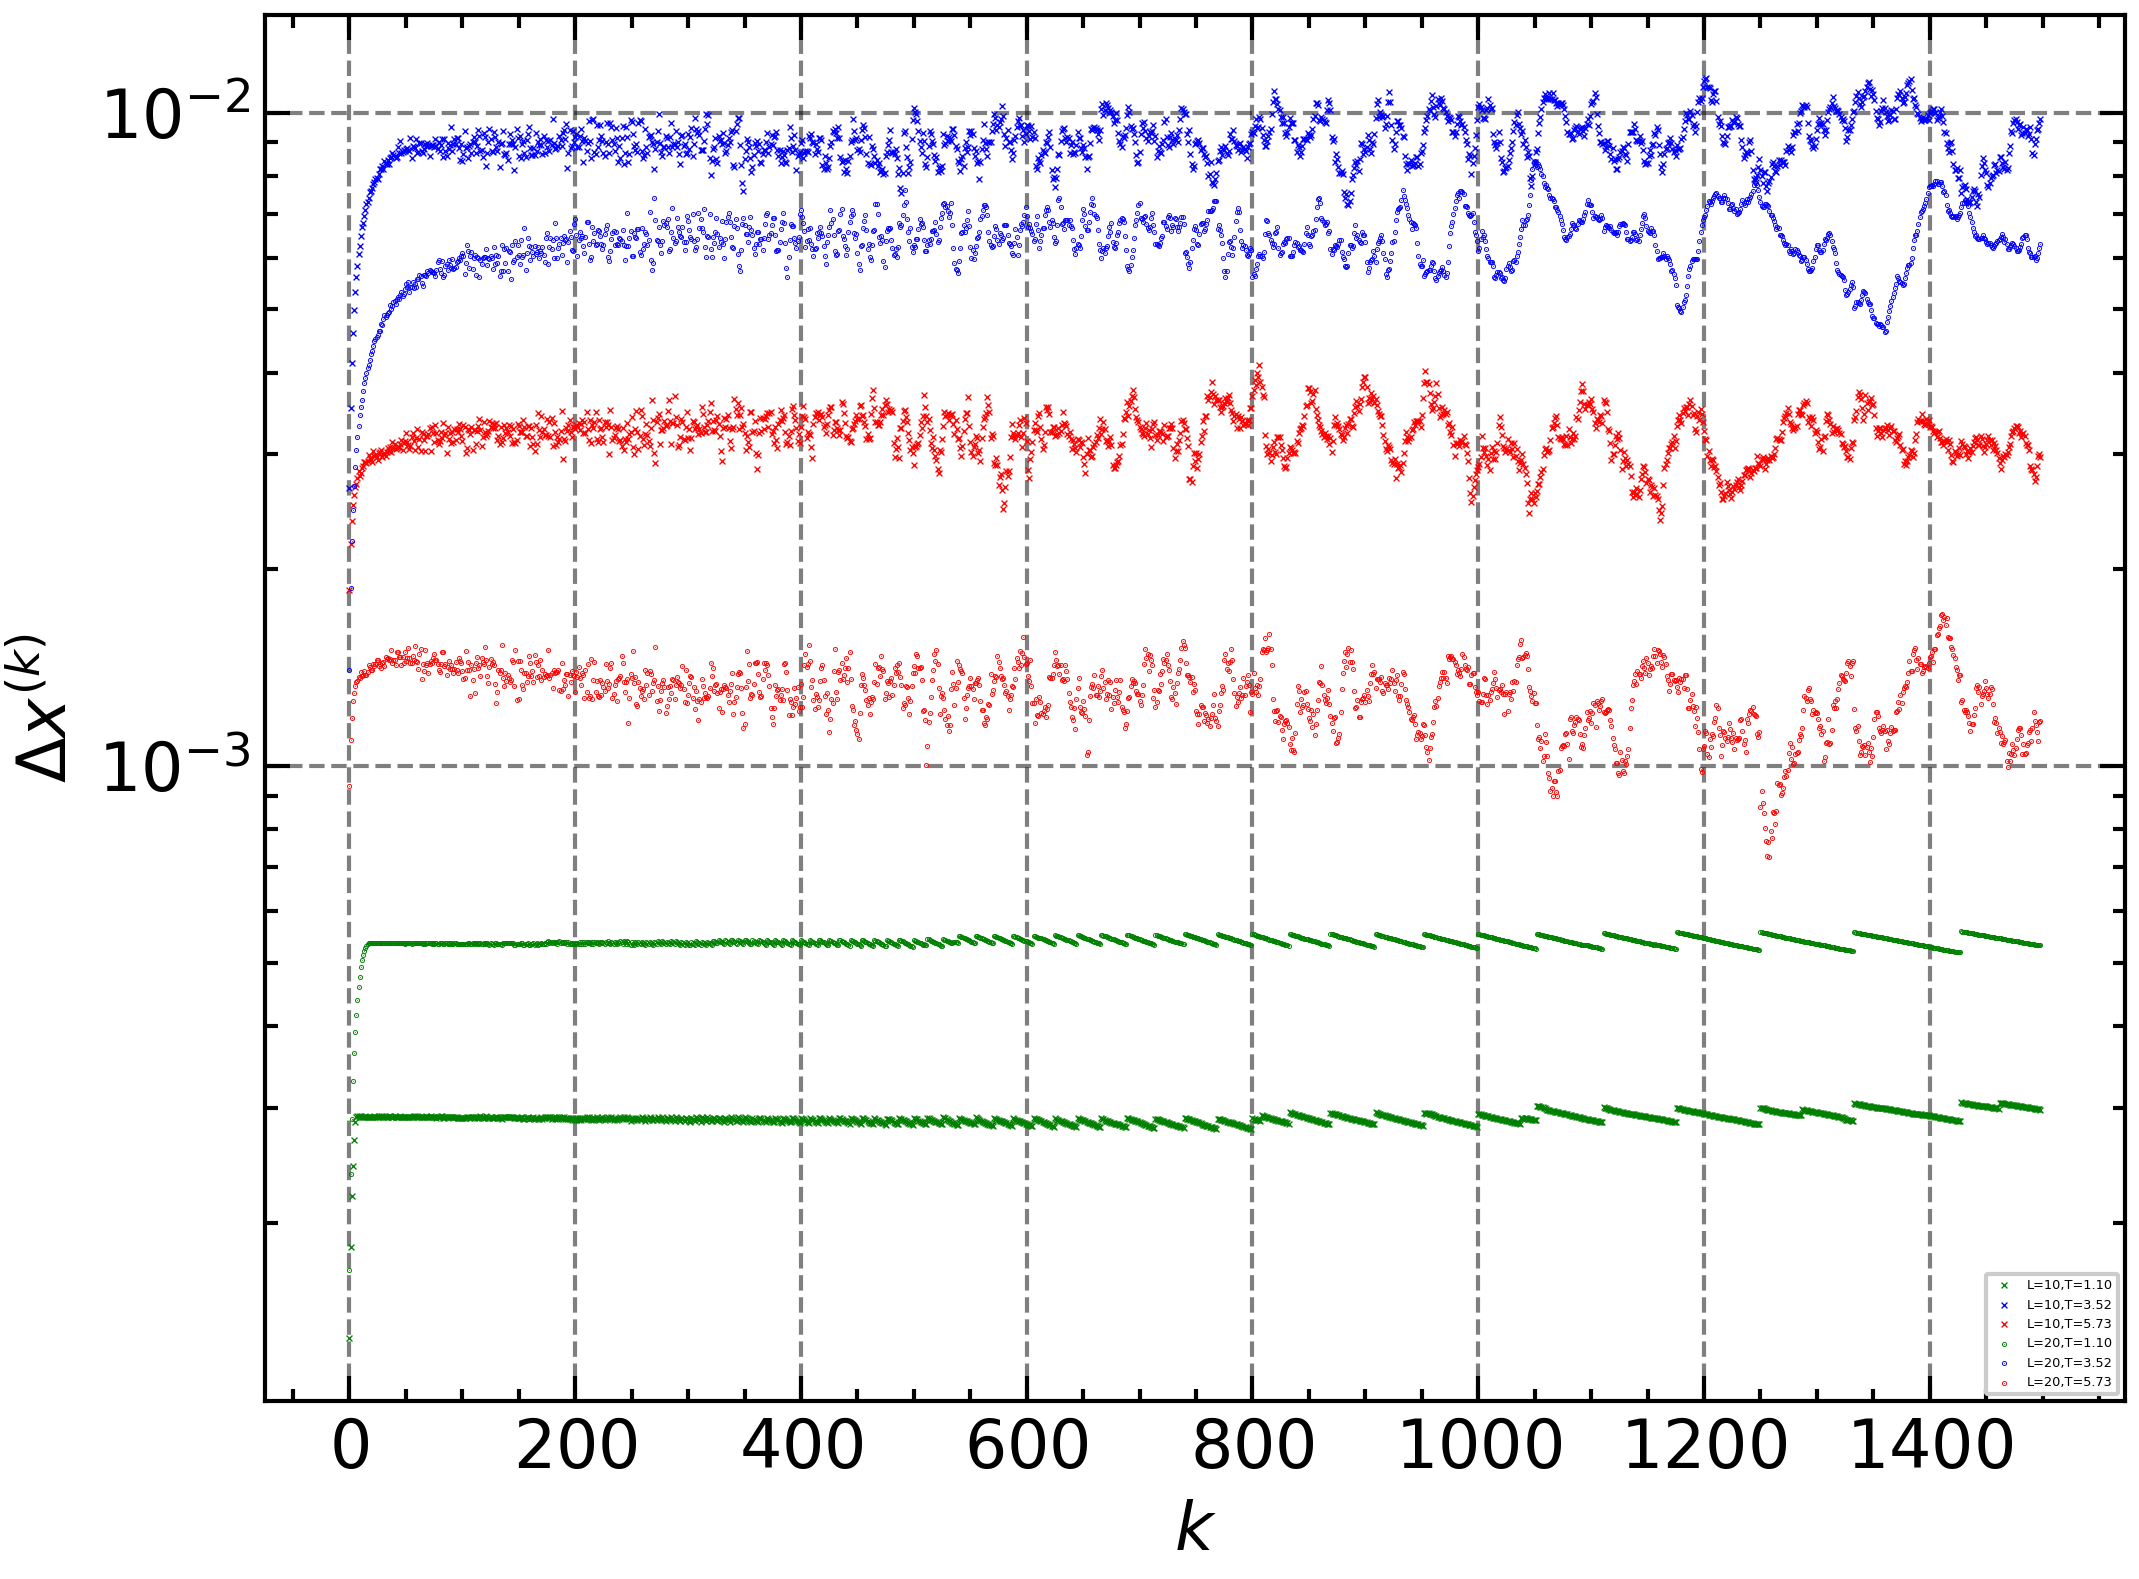

In [39]:
#plot them
plt.scatter(range(1499),bins_lattice_e10[0],s=0.05,marker='x',color='g',label='L=10,T=1.10')
plt.scatter(range(1499),bins_lattice_e10[1],s=0.05,marker='x',color='b',label='L=10,T=3.52')
plt.scatter(range(1499),bins_lattice_e10[2],s=0.05,marker='x',color='r',label='L=10,T=5.73')
plt.scatter(range(1499),bins_lattice_e20[0],s=0.05,color='g',label='L=20,T=1.10')
plt.scatter(range(1499),bins_lattice_e20[1],s=0.05,color='b',label='L=20,T=3.52')
plt.scatter(range(1499),bins_lattice_e20[2],s=0.05,color='r',label='L=20,T=5.73')
#plt.title('Binning Analysis for L=10 and 20 at differnt T')
plt.ylabel(r'$\Delta x^{(k)}$')
plt.xlabel(r'$k$')
plt.yscale('log')
plt.legend(fontsize=3.1)
plt.savefig('binninganalysisenergy.png',dpi=300)

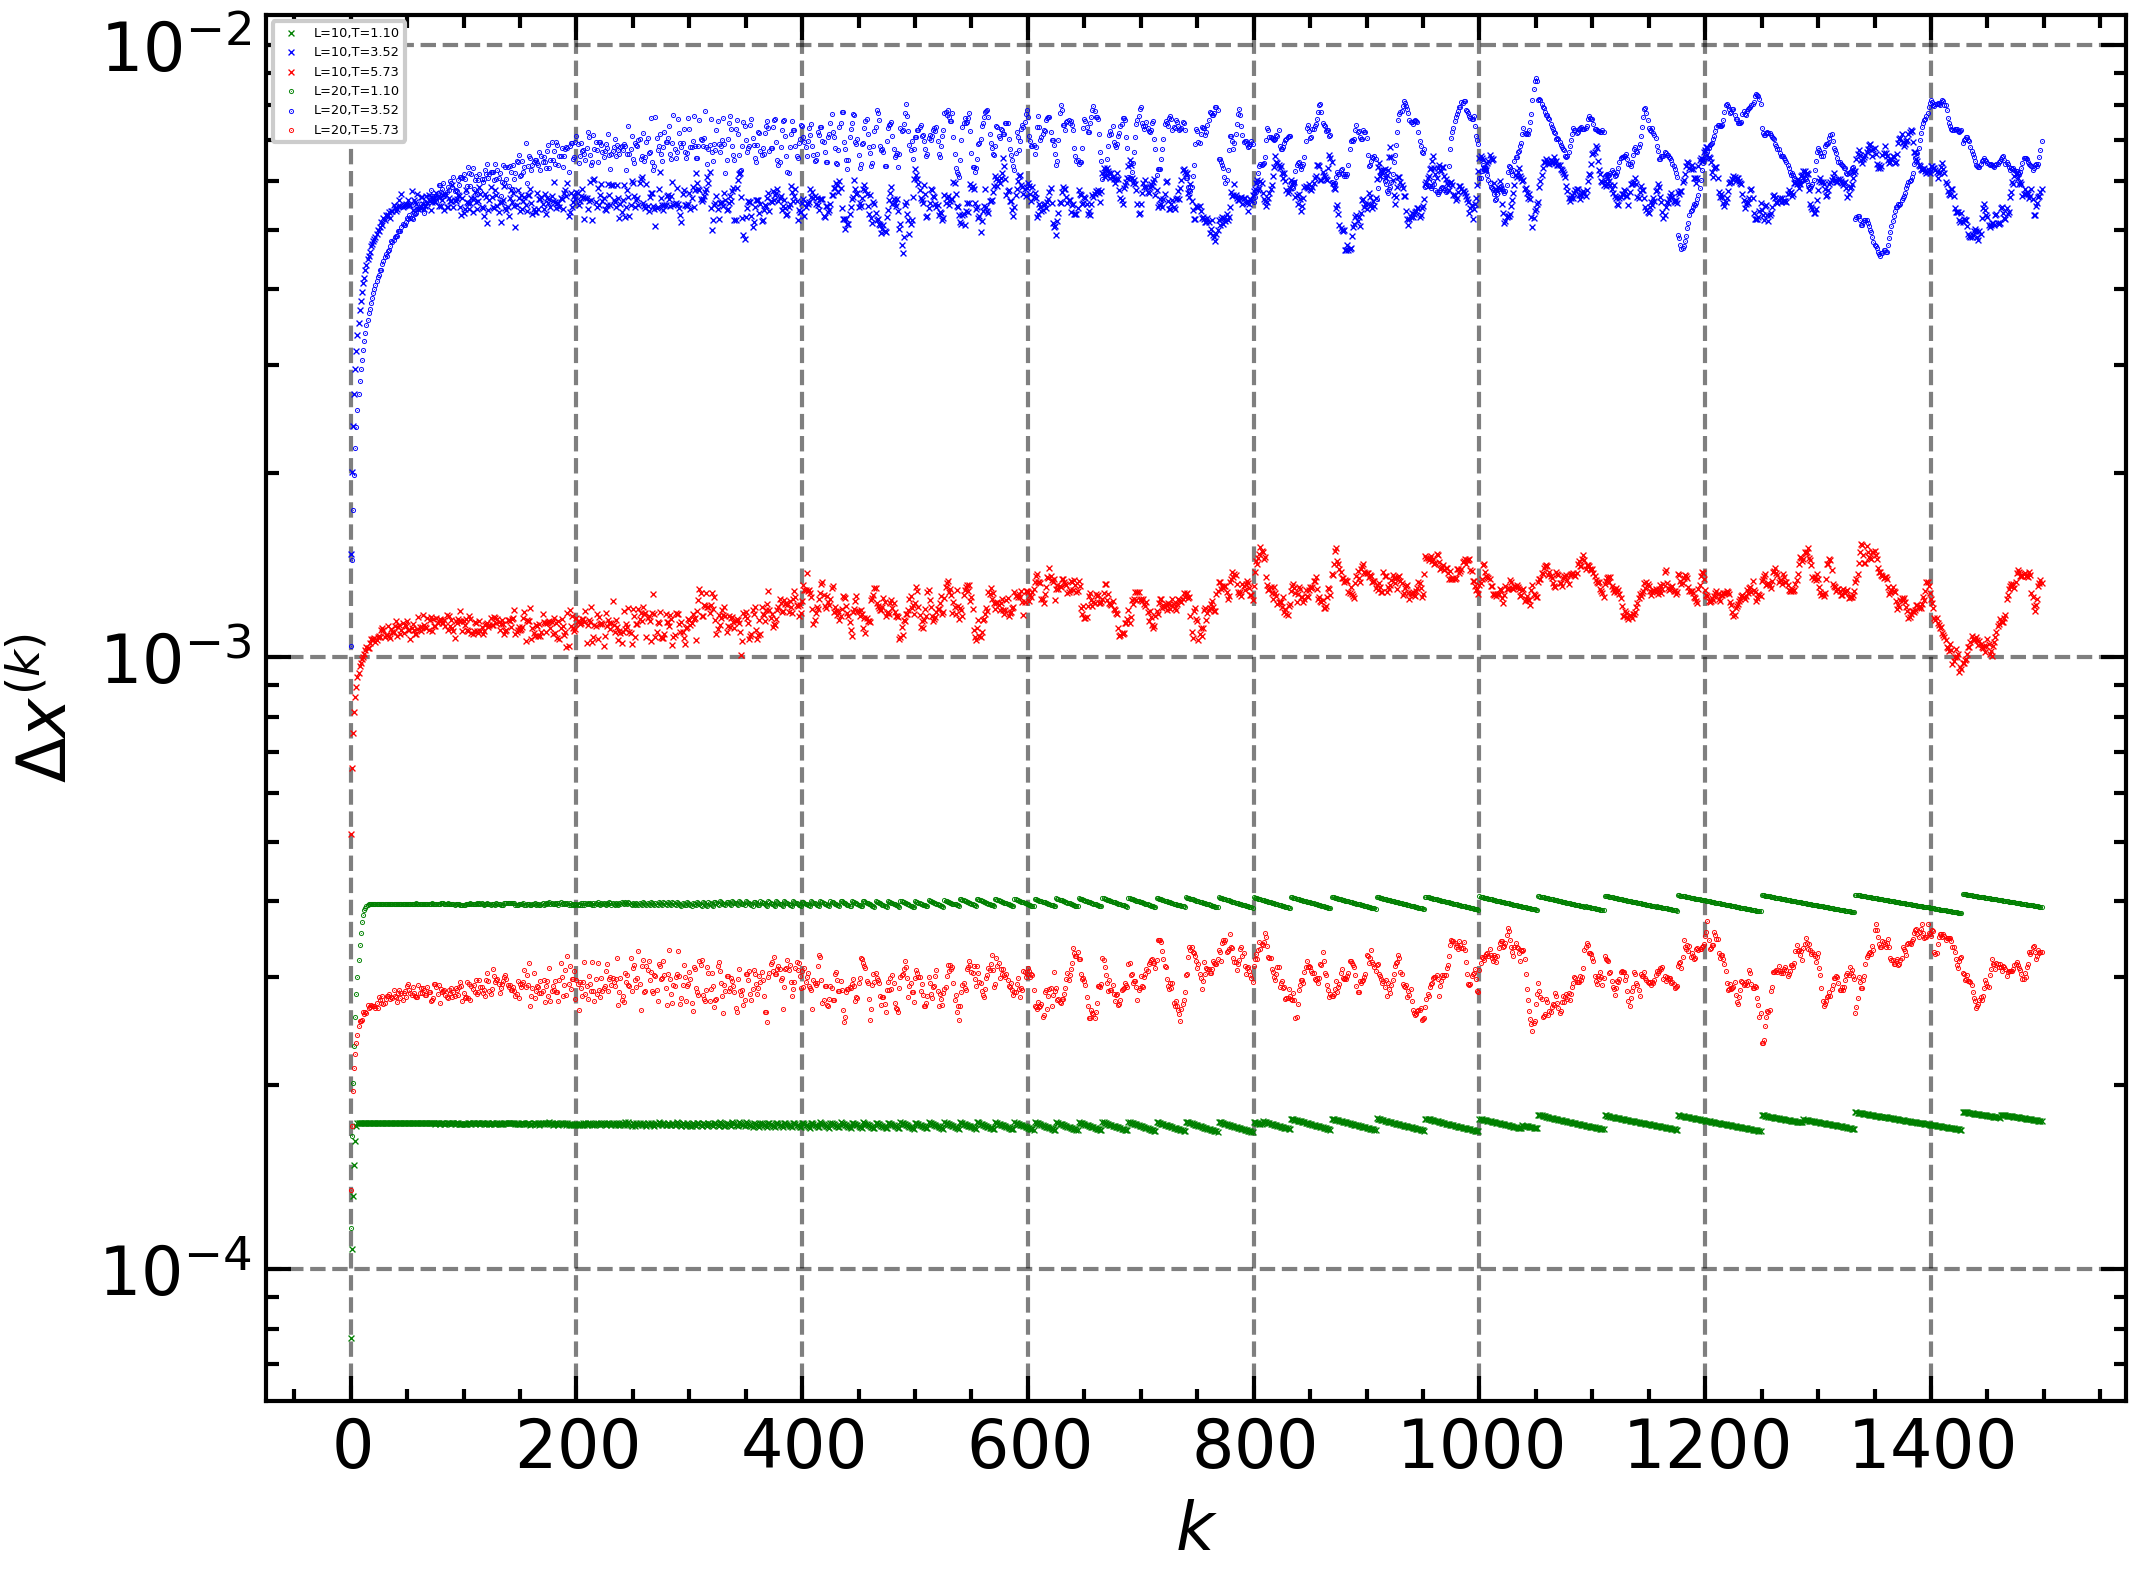

In [38]:
plt.scatter(range(1499),bins_lattice_m10[0],s=0.05,marker='x',color='g',label='L=10,T=1.10')
plt.scatter(range(1499),bins_lattice_m10[1],s=0.05,marker='x',color='b',label='L=10,T=3.52')
plt.scatter(range(1499),bins_lattice_m10[2],s=0.05,marker='x',color='r',label='L=10,T=5.73')
plt.scatter(range(1499),bins_lattice_m20[0],s=0.05,color='g',label='L=20,T=1.10')
plt.scatter(range(1499),bins_lattice_m20[1],s=0.05,color='b',label='L=20,T=3.52')
plt.scatter(range(1499),bins_lattice_m20[2],s=0.05,color='r',label='L=20,T=5.73')
#plt.title('Binning Analysis for L=10 and 20 at differnt T')
plt.ylabel(r'$\Delta x^{(k)}$')
plt.xlabel(r'$k$')
plt.yscale('log')
plt.legend(fontsize=3.1)
plt.savefig('binninganalysismag.png',dpi=300)

The autocorrelation time ($\tau$) can be defined as,

\begin{equation}
\boxed{\tau = \frac{1}{2}\left[\left(\frac{\Delta x^{(k)}}{\Delta x^{(1)}}\right)^2 - 1 \right]}
\end{equation}

In [40]:
#Function to calculate autocorrelation time.
def calculate_auto_corr_time(bins,T):
  '''
  parameters : bins, array_like, error estimates for different course graining sizes k
             : T, int, temperature index
  returns    : tau, float, autocorrelation time.
  '''  
  tau = 0.5*((bins[T][-1]/bins[T][1])**2 - 1)
  return tau

taus_10_m = [] ; taus_20_m = []
taus_10_e = [] ; taus_20_e = []
for i in range(3):
  tau_10 = calculate_auto_corr_time(bins_lattice_m10,i)
  taus_10_m.append(tau_10)
  tau_20 = calculate_auto_corr_time(bins_lattice_m20,i)
  taus_20_m.append(tau_20)

  tau_10 = calculate_auto_corr_time(bins_lattice_e10,i)
  taus_10_e.append(tau_10)
  tau_20 = calculate_auto_corr_time(bins_lattice_e20,i)
  taus_20_e.append(tau_20)

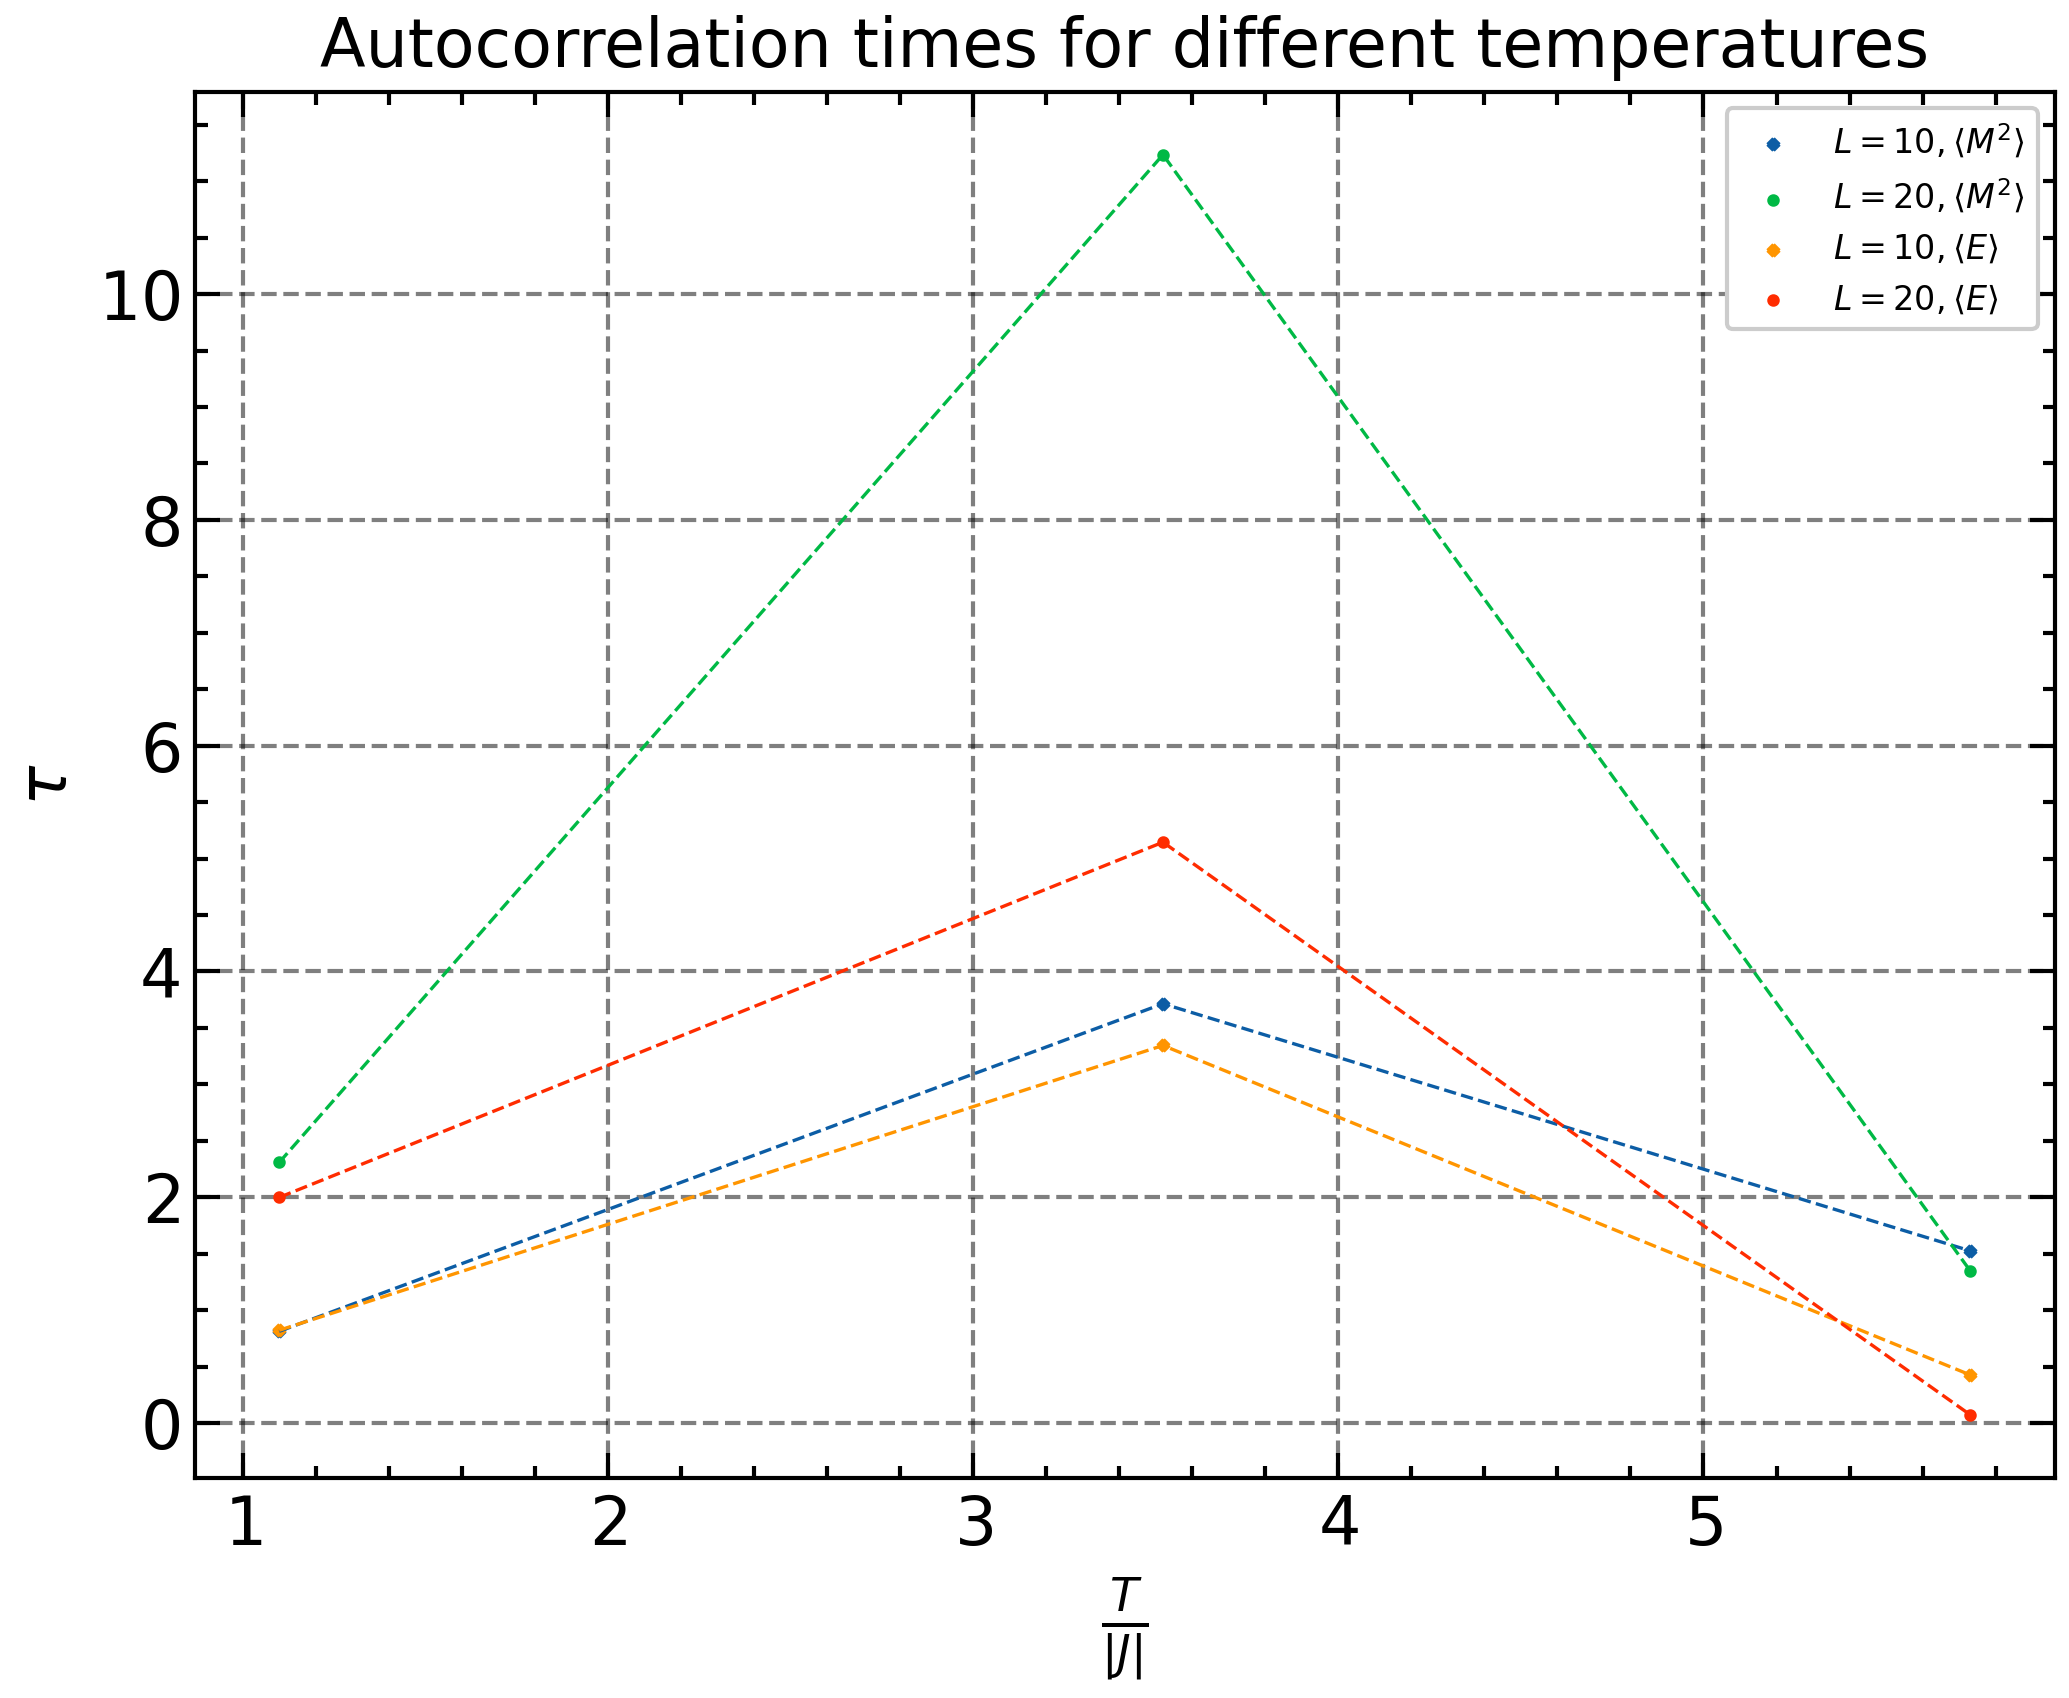

In [156]:
T = np.array([1.10,3.52,5.73])
plt.plot(T,taus_10_m,'--',lw=0.8)
plt.plot(T,taus_20_m,'--',lw=0.8)
plt.plot(T,taus_10_e,'--',lw=0.8)
plt.plot(T,taus_20_e,'--',lw=0.8)
plt.scatter(T,taus_10_m,marker='x',s=4,label=r'$L = 10, \langle M^2 \rangle$')
plt.scatter(T,taus_20_m,s=4,label=r'$L = 20, \langle M^2 \rangle$')
plt.scatter(T,taus_10_e,marker='x',s=4,label=r'$L = 10, \langle E \rangle$')
plt.scatter(T,taus_20_e,s=4,label=r'$L = 20, \langle E \rangle$')
plt.ylabel(r'$\tau$')
plt.xlabel(r'$\frac{T}{|J|}$')
plt.title('Autocorrelation times for different temperatures')
plt.legend(fontsize=8)
#plt.savefig('autocorrelations_fm.png',dpi=300)

In [46]:
#Print all the autocorrelation times for all runs.
taus_10_m = np.array(taus_10_m)
taus_20_m = np.array(taus_20_m)
taus_10_e = np.array(taus_10_e)
taus_20_e = np.array(taus_20_e)
taus1020_m = np.vstack([taus_10_m,taus_20_m])
taus1020_e = np.vstack([taus_10_e,taus_20_e])
L = [10,20]
for i in range(2):
  for j in range(3):
    print(f'Magnetisation autocorrelation time for lattice size {L[i]} at Temp {T[j]} = {np.round(taus1020_m[i][j],2)}')
    print(f'Energy autocorrelation time for lattice size {L[i]} at Temp {T[j]} = {np.round(taus1020_e[i][j],2)}')  

Magnetisation autocorrelation time for lattice size 10 at Temp 1.1 = 0.81
Energy autocorrelation time for lattice size 10 at Temp 1.1 = 0.82
Magnetisation autocorrelation time for lattice size 10 at Temp 3.52 = 3.71
Energy autocorrelation time for lattice size 10 at Temp 3.52 = 3.34
Magnetisation autocorrelation time for lattice size 10 at Temp 5.73 = 1.53
Energy autocorrelation time for lattice size 10 at Temp 5.73 = 0.43
Magnetisation autocorrelation time for lattice size 20 at Temp 1.1 = 2.31
Energy autocorrelation time for lattice size 20 at Temp 1.1 = 2.0
Magnetisation autocorrelation time for lattice size 20 at Temp 3.52 = 11.23
Energy autocorrelation time for lattice size 20 at Temp 3.52 = 5.14
Magnetisation autocorrelation time for lattice size 20 at Temp 5.73 = 1.35
Energy autocorrelation time for lattice size 20 at Temp 5.73 = 0.07


## 3.1.4 $\textit{Mean square magnetisation for different lattices}$

In [3]:
#Loading all the datasets that are previously computed using the code using cluster computing.
temps = np.concatenate([np.linspace(1,3,20),np.linspace(3,4,30),np.linspace(4,6,20)])
data_10_fm = pd.read_csv('datafiles/lattice_obs_10.csv') # L = 10
data_20_fm = pd.read_csv('datafiles/lattice_obs_20.csv') # L = 20
data_40_fm = pd.read_csv('datafiles/lattice_obs_40.csv') # L = 40
data_80_fm = pd.read_csv('datafiles/lattice_obs_80.csv') # L = 80

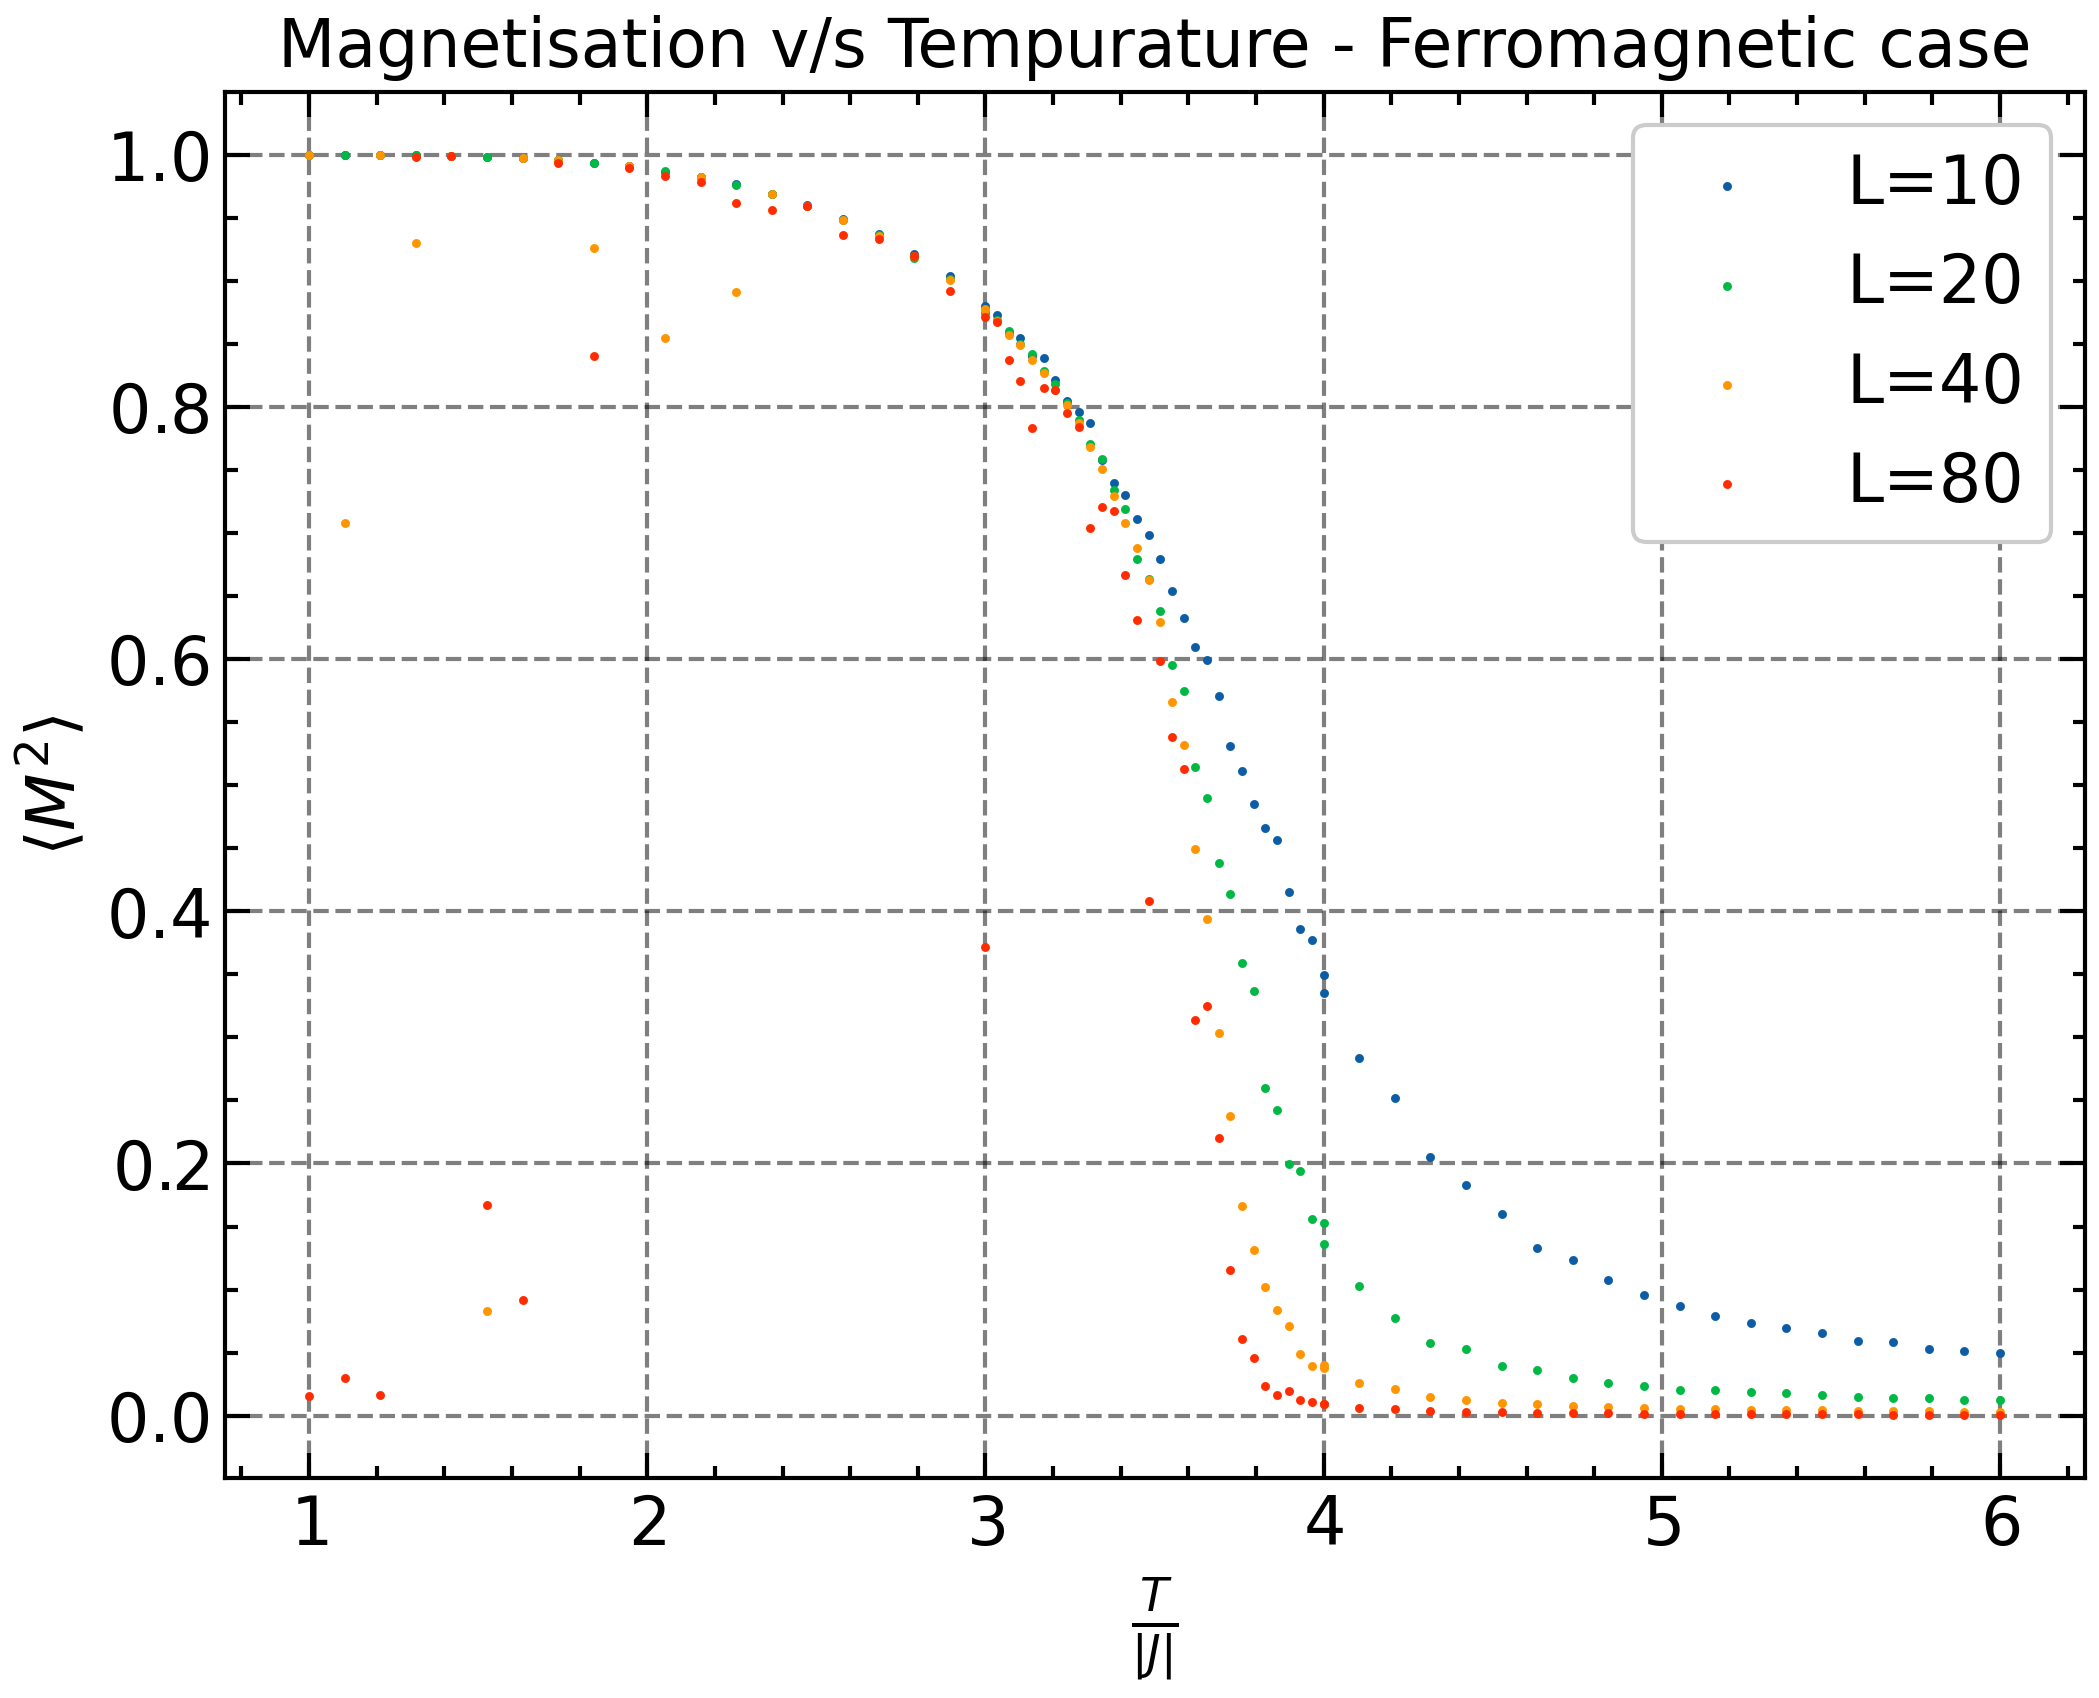

In [4]:
#plot mean square magnetisation for all lattice sizes to see the effect of system size in the curves.
plt.scatter(temps,data_10_fm['<M>'],s=1.3,label='L=10')
plt.scatter(temps,data_20_fm['<M>'],s=1.3,label='L=20')
plt.scatter(temps,data_40_fm['<M>'],s=1.3,label='L=40')
plt.scatter(temps,data_80_fm['<M>'],s=1.3,label='L=80')
plt.title("Magnetisation v/s Tempurature - Ferromagnetic case")
#plt.axvline(x=3.64,lw=0.1,color='r',label='T_c = 3.64')
plt.xlabel(r'$\frac{T}{|J|}$')
plt.ylabel(r'$\langle M^2 \rangle$')
plt.legend()
#plt.savefig('mvst.png',dpi=300)

## 3.1.5 $\textit{Calculation of specific heat}$

$\textbf{The specific heat can be defined as,}$

\begin{equation}
\boxed{C_v = \frac{\langle E^2 \rangle - \langle E \rangle^2}{T^2}}
\end{equation}

In [5]:
#calculate specific heats from all datasets using the defintion above

c_v_10_fm = (data_10_fm['<E_2>'] - data_10_fm['<E>']**2)/temps**2
c_v_20_fm = (data_20_fm['<E_2>'] - data_20_fm['<E>']**2)/temps**2
c_v_40_fm = (data_40_fm['<E_2>'] - data_40_fm['<E>']**2)/temps**2
c_v_80_fm = (data_80_fm['<E_2>'] - data_80_fm['<E>']**2)/temps**2

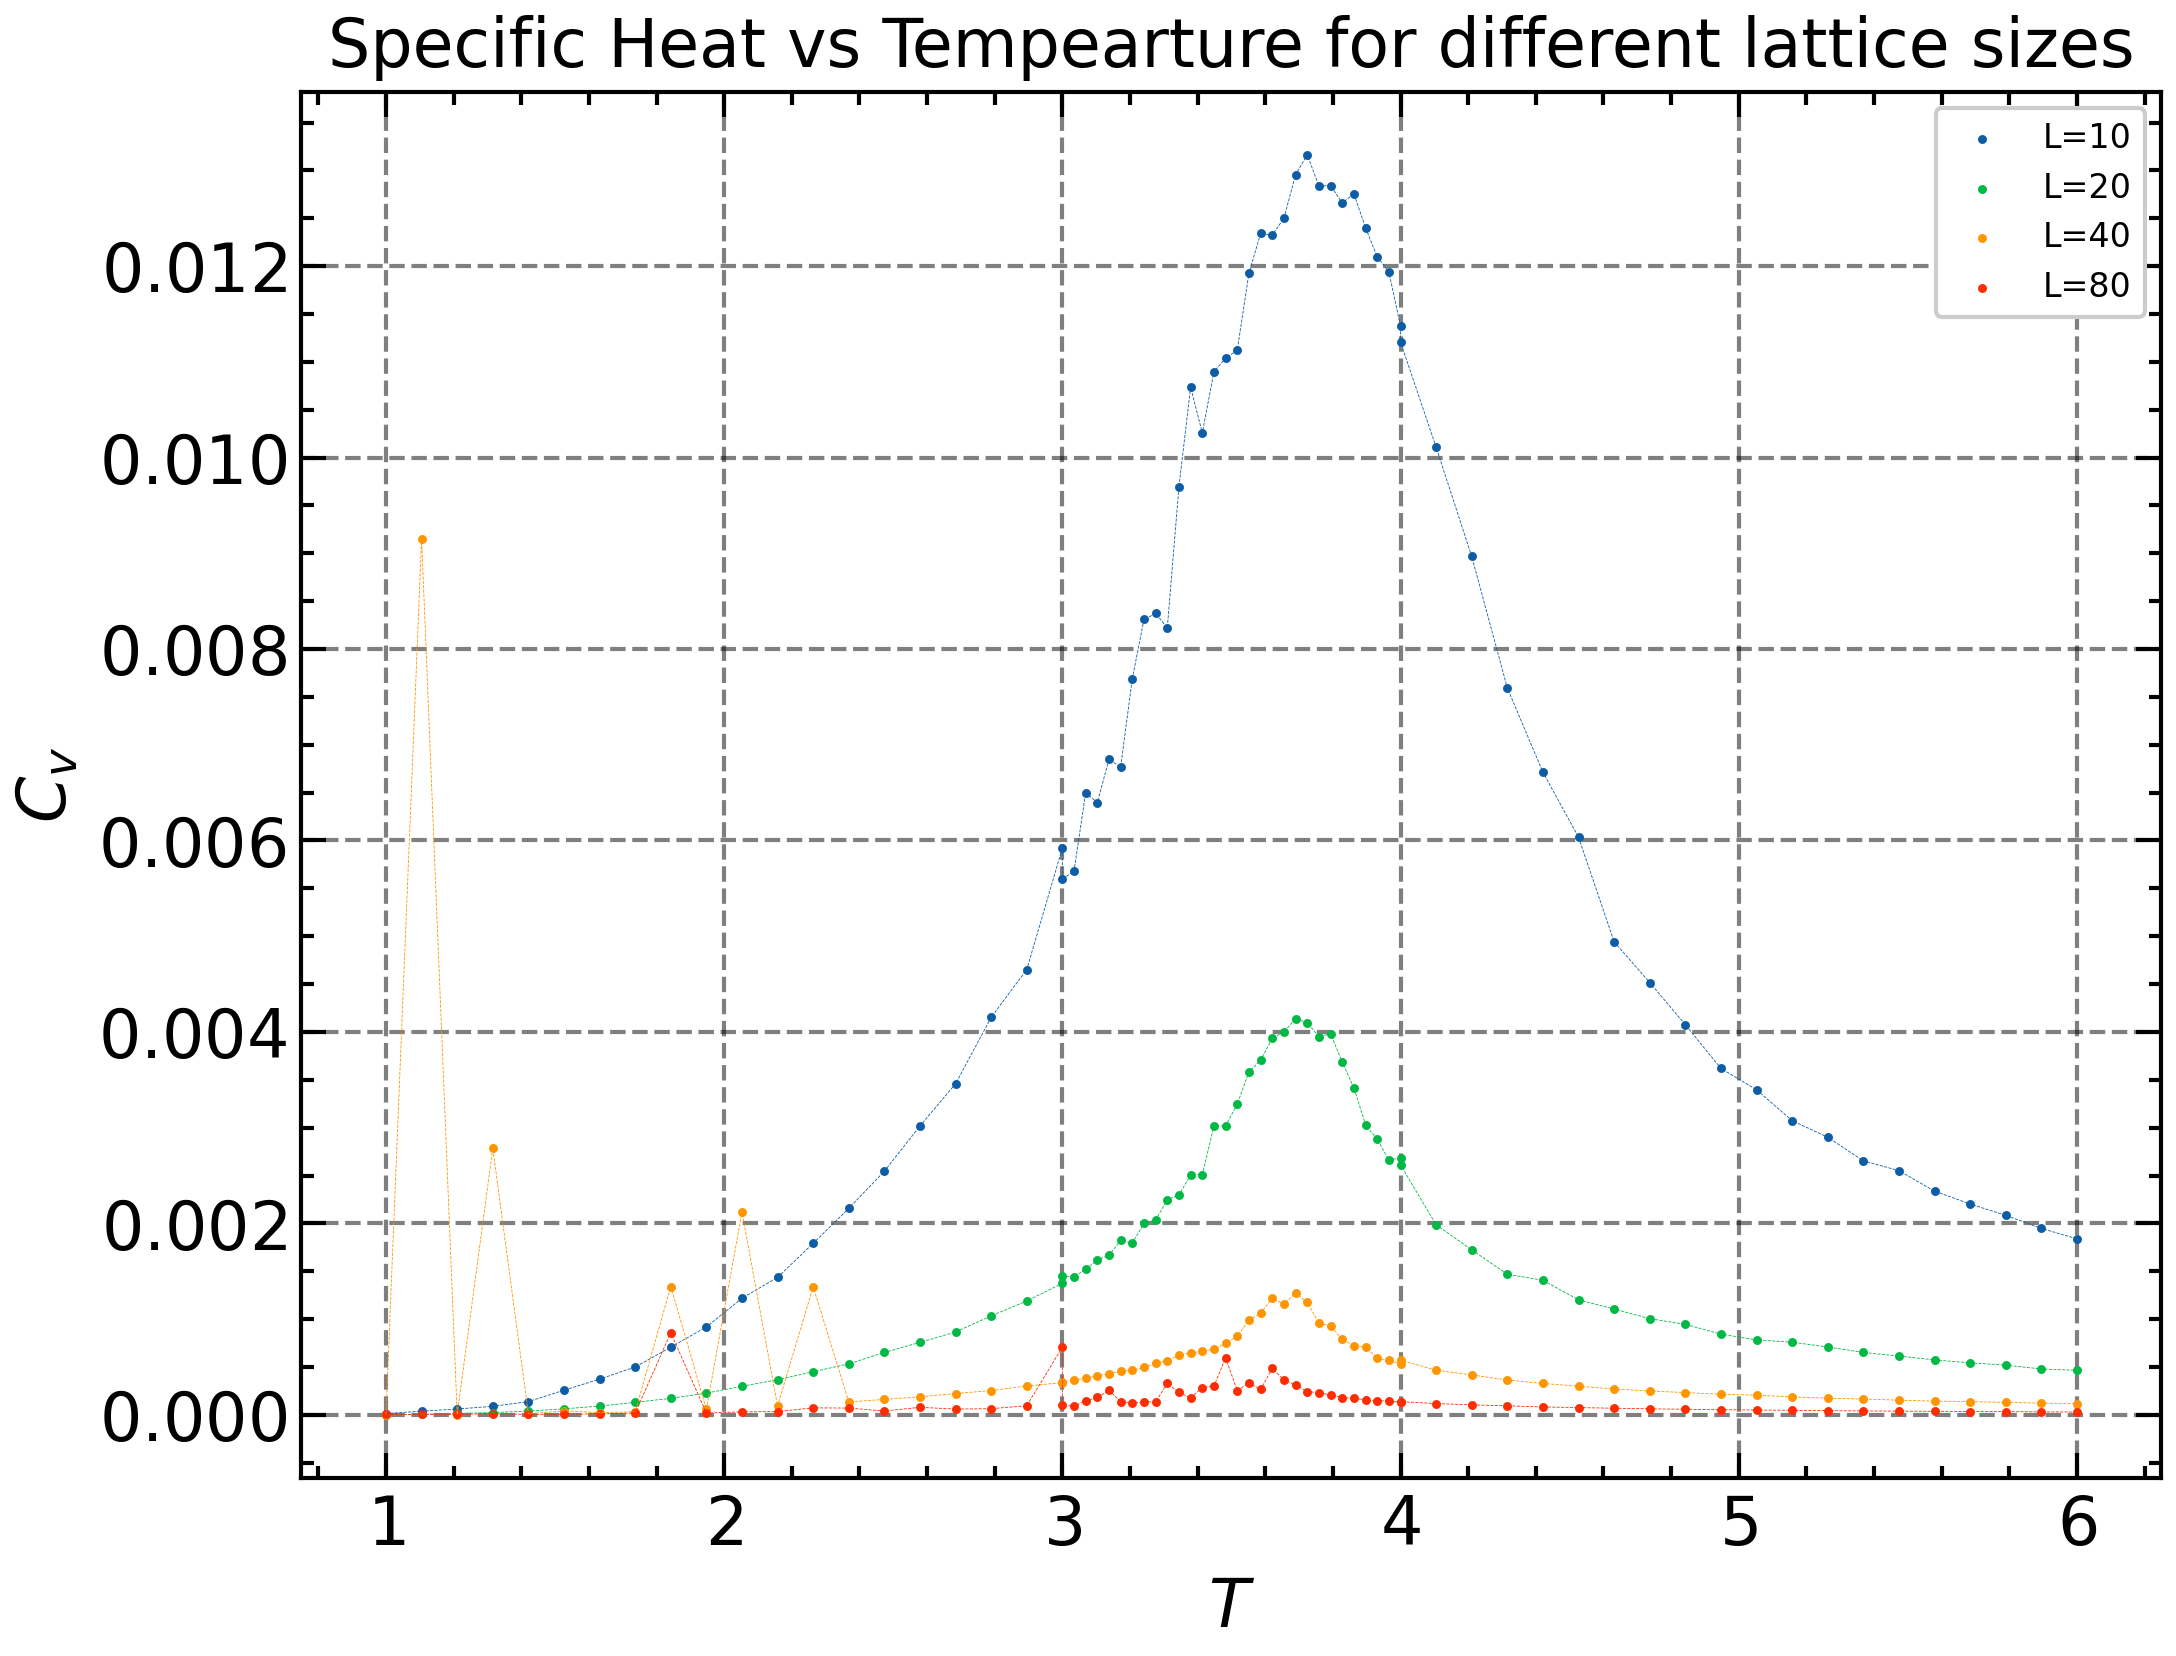

In [6]:
#plot them
plt.plot(temps,c_v_10_fm,'--',lw=0.2)
plt.plot(temps,c_v_20_fm,'--',lw=0.2)
plt.plot(temps,c_v_40_fm,'--',lw=0.2)
plt.plot(temps,c_v_80_fm,'--',lw=0.2)

plt.scatter(temps,c_v_10_fm,s=1.3,label='L=10')
plt.scatter(temps,c_v_20_fm,s=1.3,label='L=20')
plt.scatter(temps,c_v_40_fm,s=1.3,label='L=40')
plt.scatter(temps,c_v_80_fm,s=1.3,label='L=80')
plt.title('Specific Heat vs Tempearture for different lattice sizes')
plt.ylabel(r'$C_v$') ;
plt.xlabel(r'$T$')
plt.legend(loc='upper right',facecolor="white",fontsize=8)
#plt.savefig('specific_heat_fm_norm.png',dpi=300)

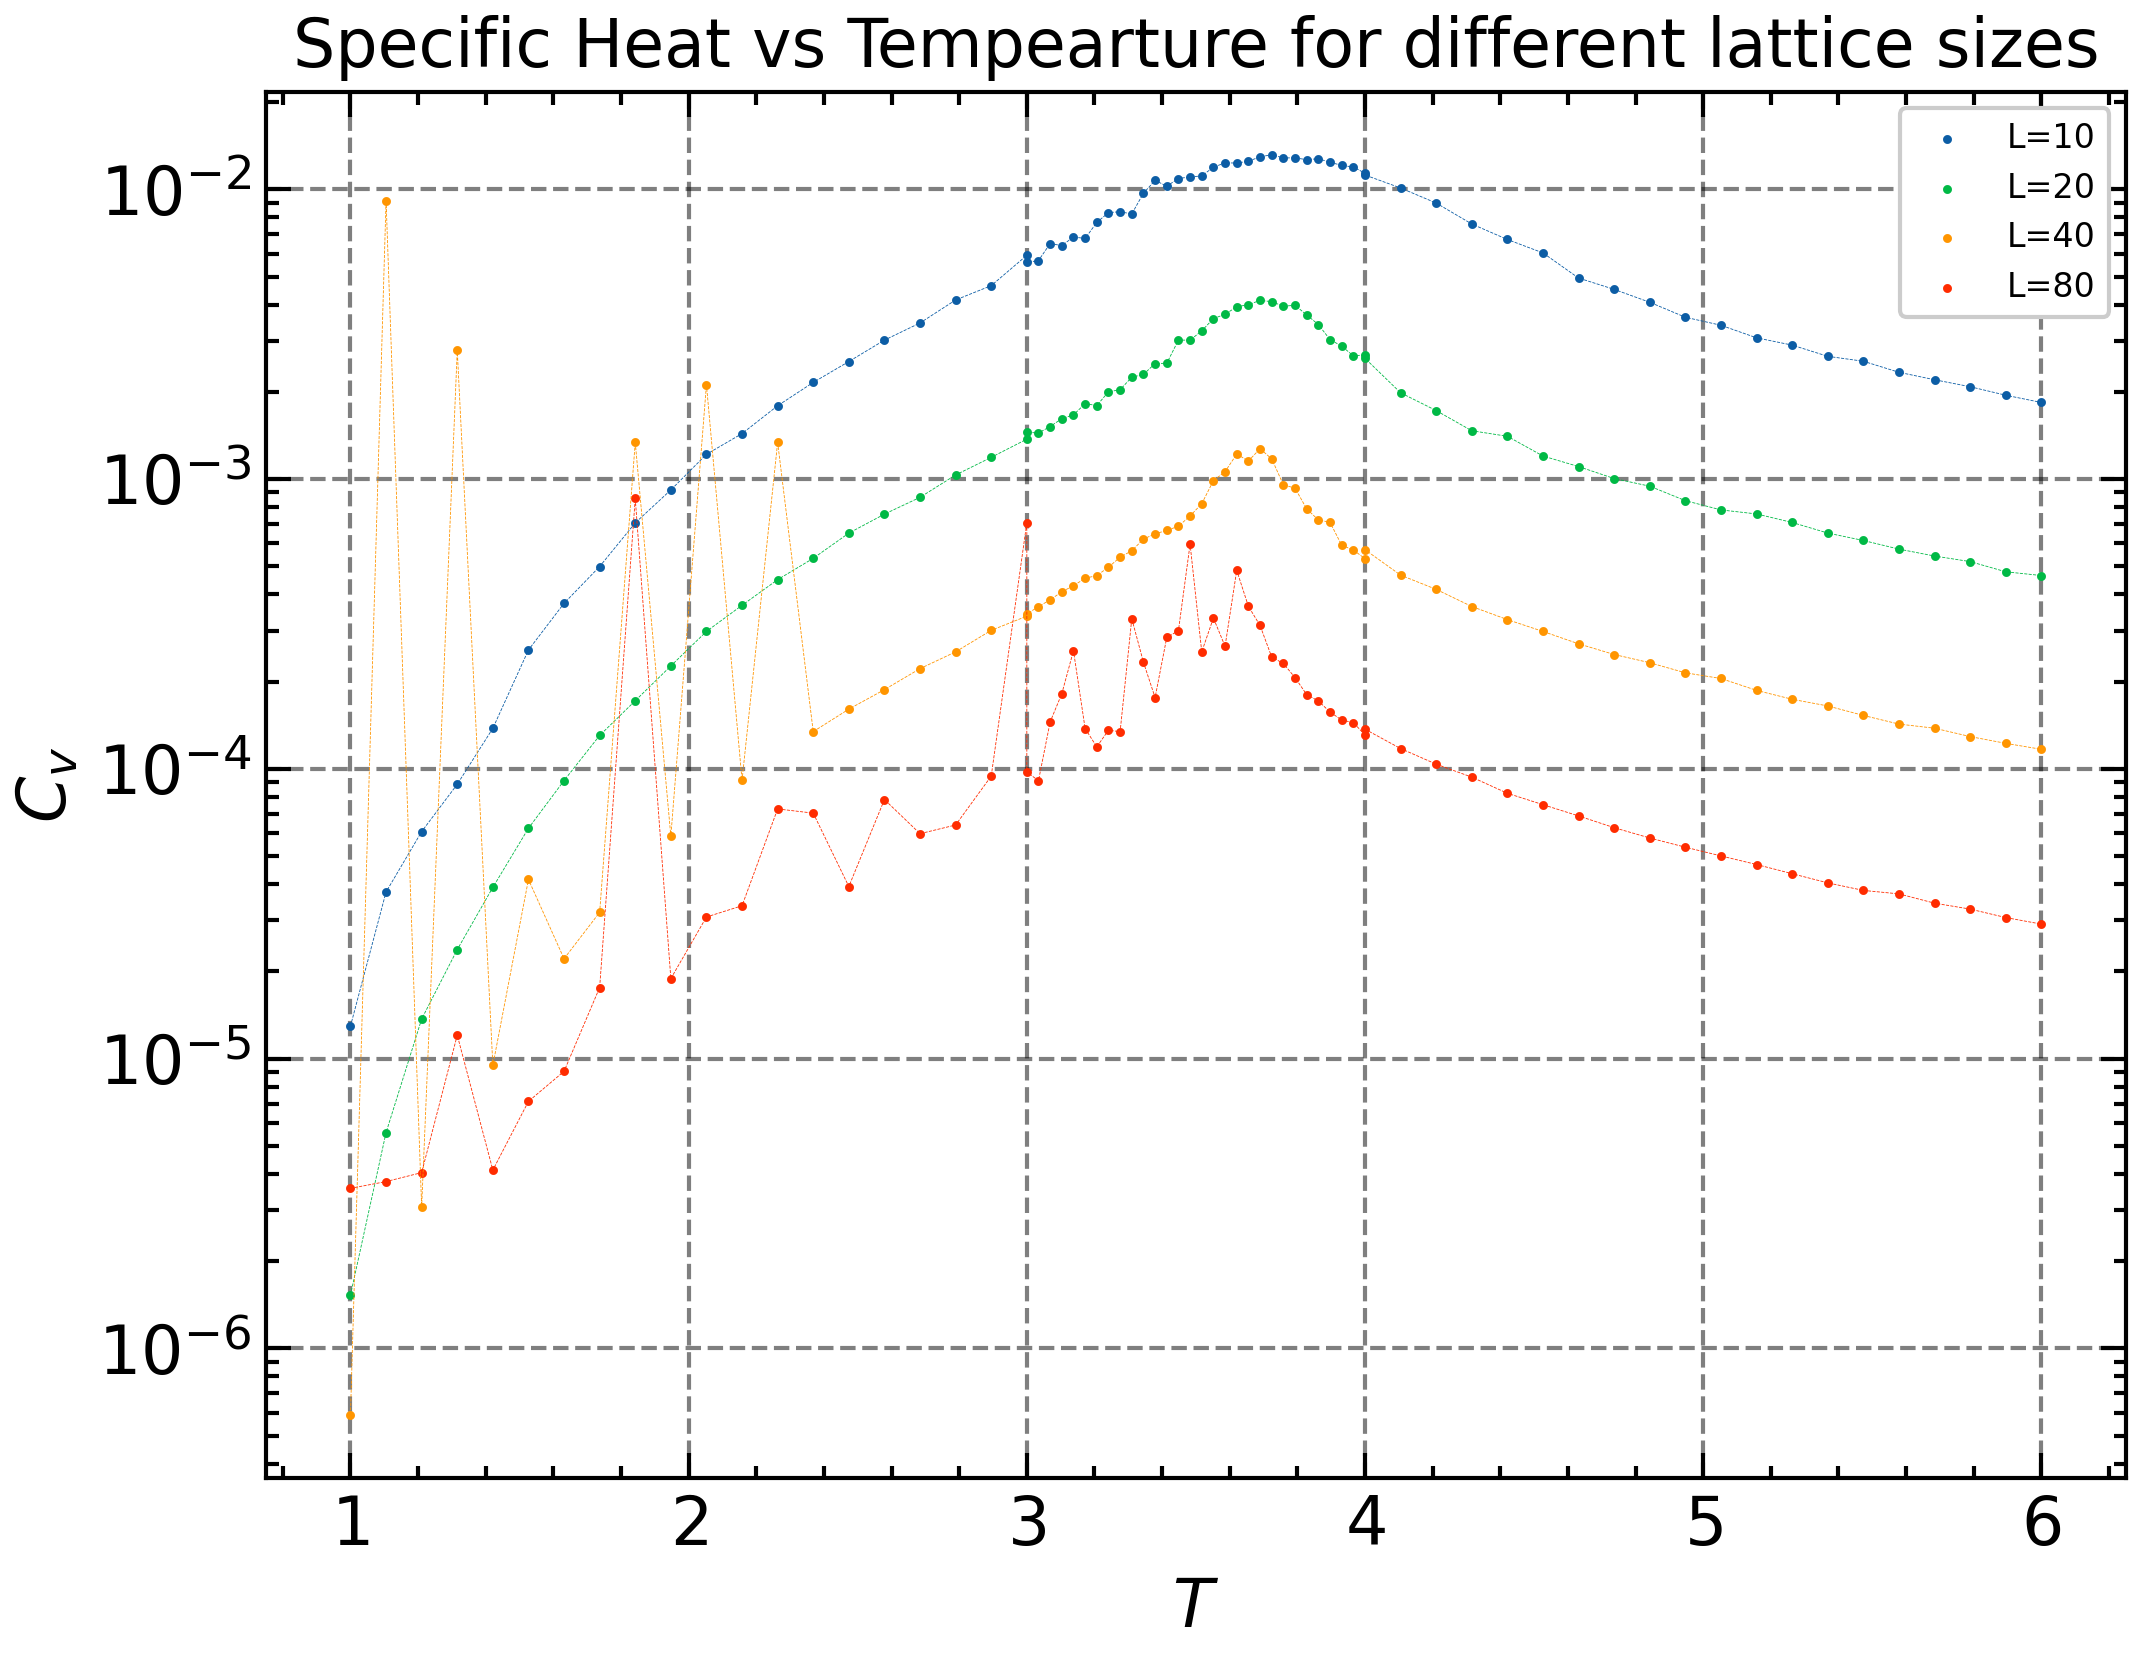

In [145]:
#plot them - log axis
plt.plot(temps,c_v_10_fm,'--',lw=0.2)
plt.plot(temps,c_v_20_fm,'--',lw=0.2)
plt.plot(temps,c_v_40_fm,'--',lw=0.2)
plt.plot(temps,c_v_80_fm,'--',lw=0.2)

plt.scatter(temps,c_v_10_fm,s=1.3,label='L=10')
plt.scatter(temps,c_v_20_fm,s=1.3,label='L=20')
plt.scatter(temps,c_v_40_fm,s=1.3,label='L=40')
plt.scatter(temps,c_v_80_fm,s=1.3,label='L=80')
plt.title('Specific Heat vs Tempearture for different lattice sizes')
plt.ylabel(r'$C_v$') ;
plt.xlabel(r'$T$')
plt.yscale('log')
#plt.grid()
plt.legend(loc='upper right',facecolor="white",fontsize=8)

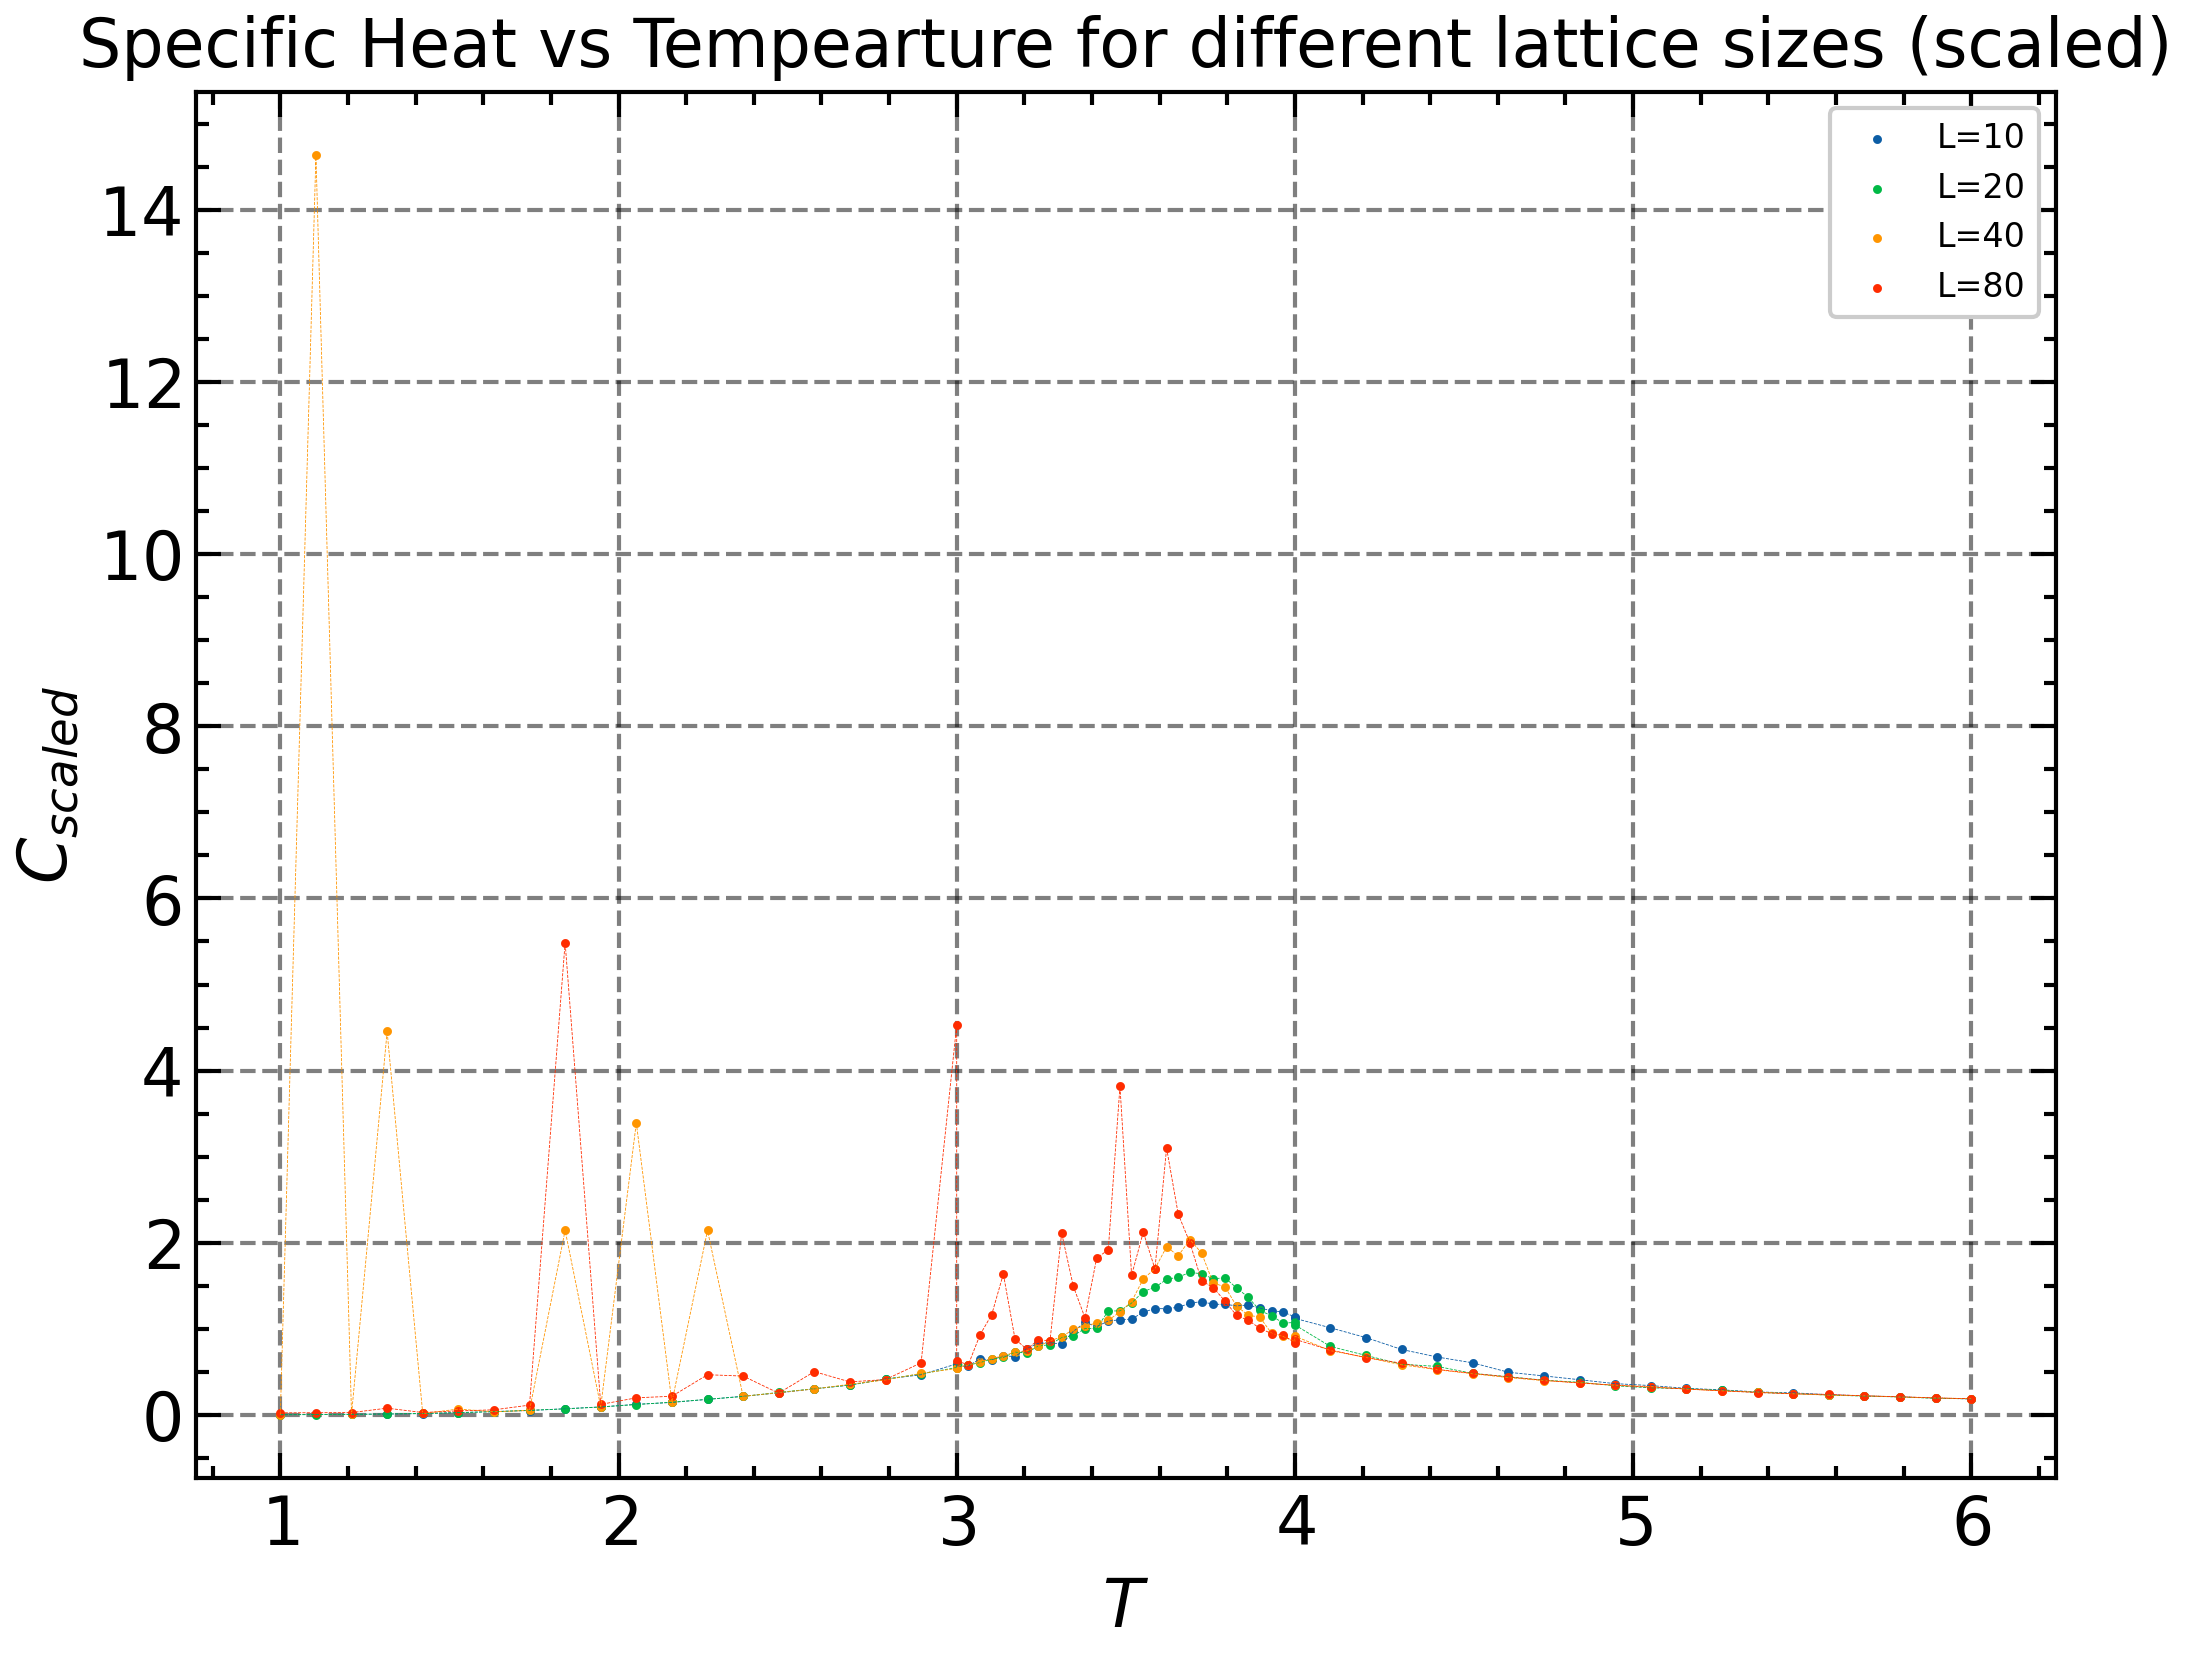

In [8]:
#plot them - log axis
plt.plot(temps,c_v_10_fm*10**2,'--',lw=0.2)
plt.plot(temps,c_v_20_fm*20**2,'--',lw=0.2)
plt.plot(temps,c_v_40_fm*40**2,'--',lw=0.2)
plt.plot(temps,c_v_80_fm*80**2,'--',lw=0.2)

plt.scatter(temps,c_v_10_fm*10**2,s=1.3,label='L=10')
plt.scatter(temps,c_v_20_fm*20**2,s=1.3,label='L=20')
plt.scatter(temps,c_v_40_fm*40**2,s=1.3,label='L=40')
plt.scatter(temps,c_v_80_fm*80**2,s=1.3,label='L=80')
plt.title('Specific Heat vs Tempearture for different lattice sizes (scaled)')
plt.ylabel(r'$C_{scaled}$') ;
plt.xlabel(r'$T$')
plt.legend(loc='upper right',facecolor="white",fontsize=8)
#plt.savefig('specific_heat_fm_norm_scaled.png',dpi=300)

# ANTI FERROMAGNET J>0 B=0

## 3.2.1 $\textit{Binning analysis and autocorrelation times}$

In [88]:
#Create a temperature grid that is evenly spaced in the logarithmic scale.
n = np.arange(-12,28,2)
T = 2**(n/4)
print(T)

[ 0.125       0.1767767   0.25        0.35355339  0.5         0.70710678
  1.          1.41421356  2.          2.82842712  4.          5.65685425
  8.         11.3137085  16.         22.627417   32.         45.254834
 64.         90.50966799]


In [77]:
J,B = 1,0 # Change coupling to positive ie, antiferromagnet.
betas = 1/T
bins_lattice_m_afm_10 = []  ; bins_lattice_e_afm_10 = []
lattice = init_lattice(10)
for i in tqdm(range(len(betas))):
  err_m,err_E = binned_analysis(lattice,J,B,betas[i])
  bins_lattice_m_afm_10.append(err_m) ; bins_lattice_e_afm_10.append(err_E)
  #plt.scatter(range(len(err_m)),err_m,s=0.1)

bins_lattice_m_afm_10 = np.vstack(bins_lattice_m_afm_10) ;
bins_lattice_e_afm_10 = np.vstack(bins_lattice_e_afm_10)



100%|█████████████████████████████████████████████████████| 20/20 [00:38<00:00,  1.92s/it]


In [78]:
J,B = 1,0
bins_lattice_m_afm_20 = []  ; bins_lattice_e_afm_20 = []
lattice = init_lattice(20)
for i in tqdm(range(len(betas))):  
  err_m,err_E = binned_analysis(lattice,J,B,betas[i])
  bins_lattice_m_afm_20.append(err_m) ; bins_lattice_e_afm_20.append(err_E)
  #plt.scatter(range(len(err_m)),err_m,s=0.1)

bins_lattice_m_afm_20 = np.vstack(bins_lattice_m_afm_20) ;
bins_lattice_e_afm_20 = np.vstack(bins_lattice_e_afm_20)


100%|█████████████████████████████████████████████████████| 20/20 [03:46<00:00, 11.32s/it]


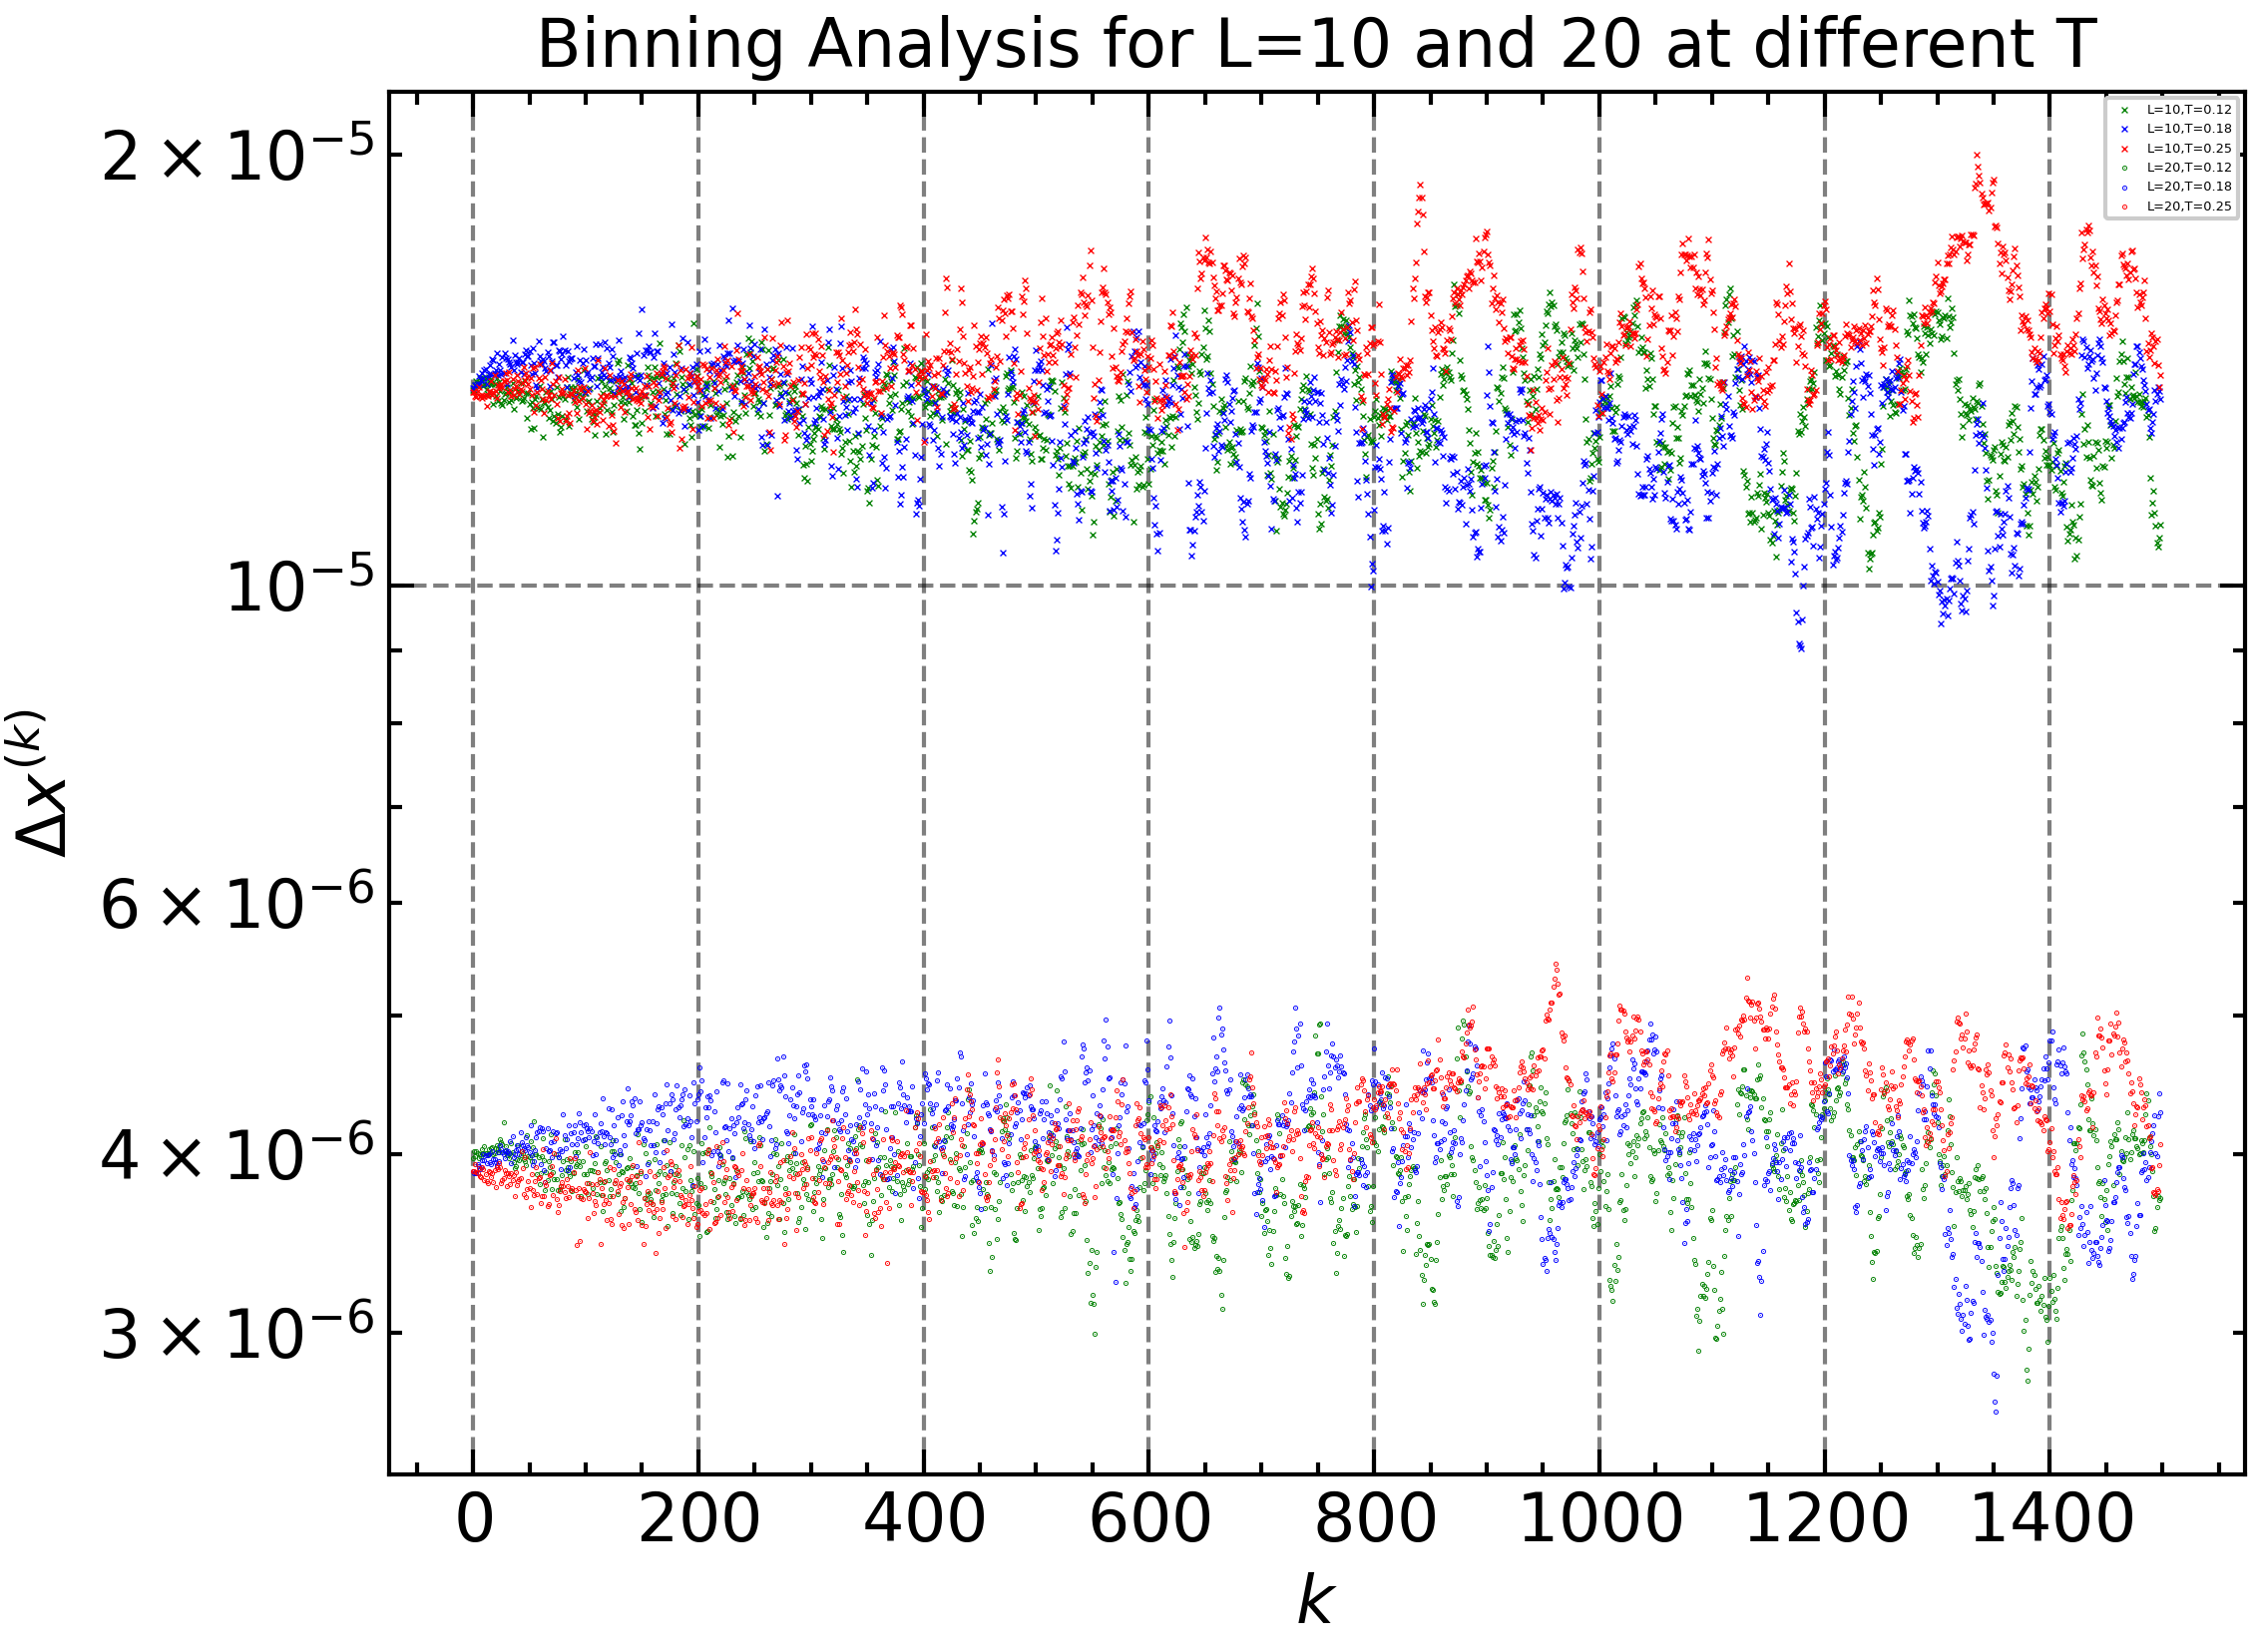

In [85]:
plt.scatter(range(1499),bins_lattice_m_afm_10[0],s=0.05,marker='x',color='g',label=f'L=10,T={np.round(T[0],2)}')
plt.scatter(range(1499),bins_lattice_m_afm_10[1],s=0.05,marker='x',color='b',label=f'L=10,T={np.round(T[1],2)}')
plt.scatter(range(1499),bins_lattice_m_afm_10[2],s=0.05,marker='x',color='r',label=f'L=10,T={np.round(T[2],2)}')
plt.scatter(range(1499),bins_lattice_m_afm_20[0],s=0.05,color='g',label= f'L=20,T={np.round(T[0],2)}')
plt.scatter(range(1499),bins_lattice_m_afm_20[1],s=0.05,color='b',label=f'L=20,T={np.round(T[1],2)}')
plt.scatter(range(1499),bins_lattice_m_afm_20[2],s=0.05,color='r',label=f'L=20,T={np.round(T[2],2)}')
plt.title('Binning Analysis for L=10 and 20 at different T')
plt.ylabel(r'$\Delta x^{(k)}$')
plt.xlabel(r'$k$')
plt.yscale('log')
plt.legend(fontsize=3.1)
#plt.savefig('binanalysis_afm.png',dpi=300)


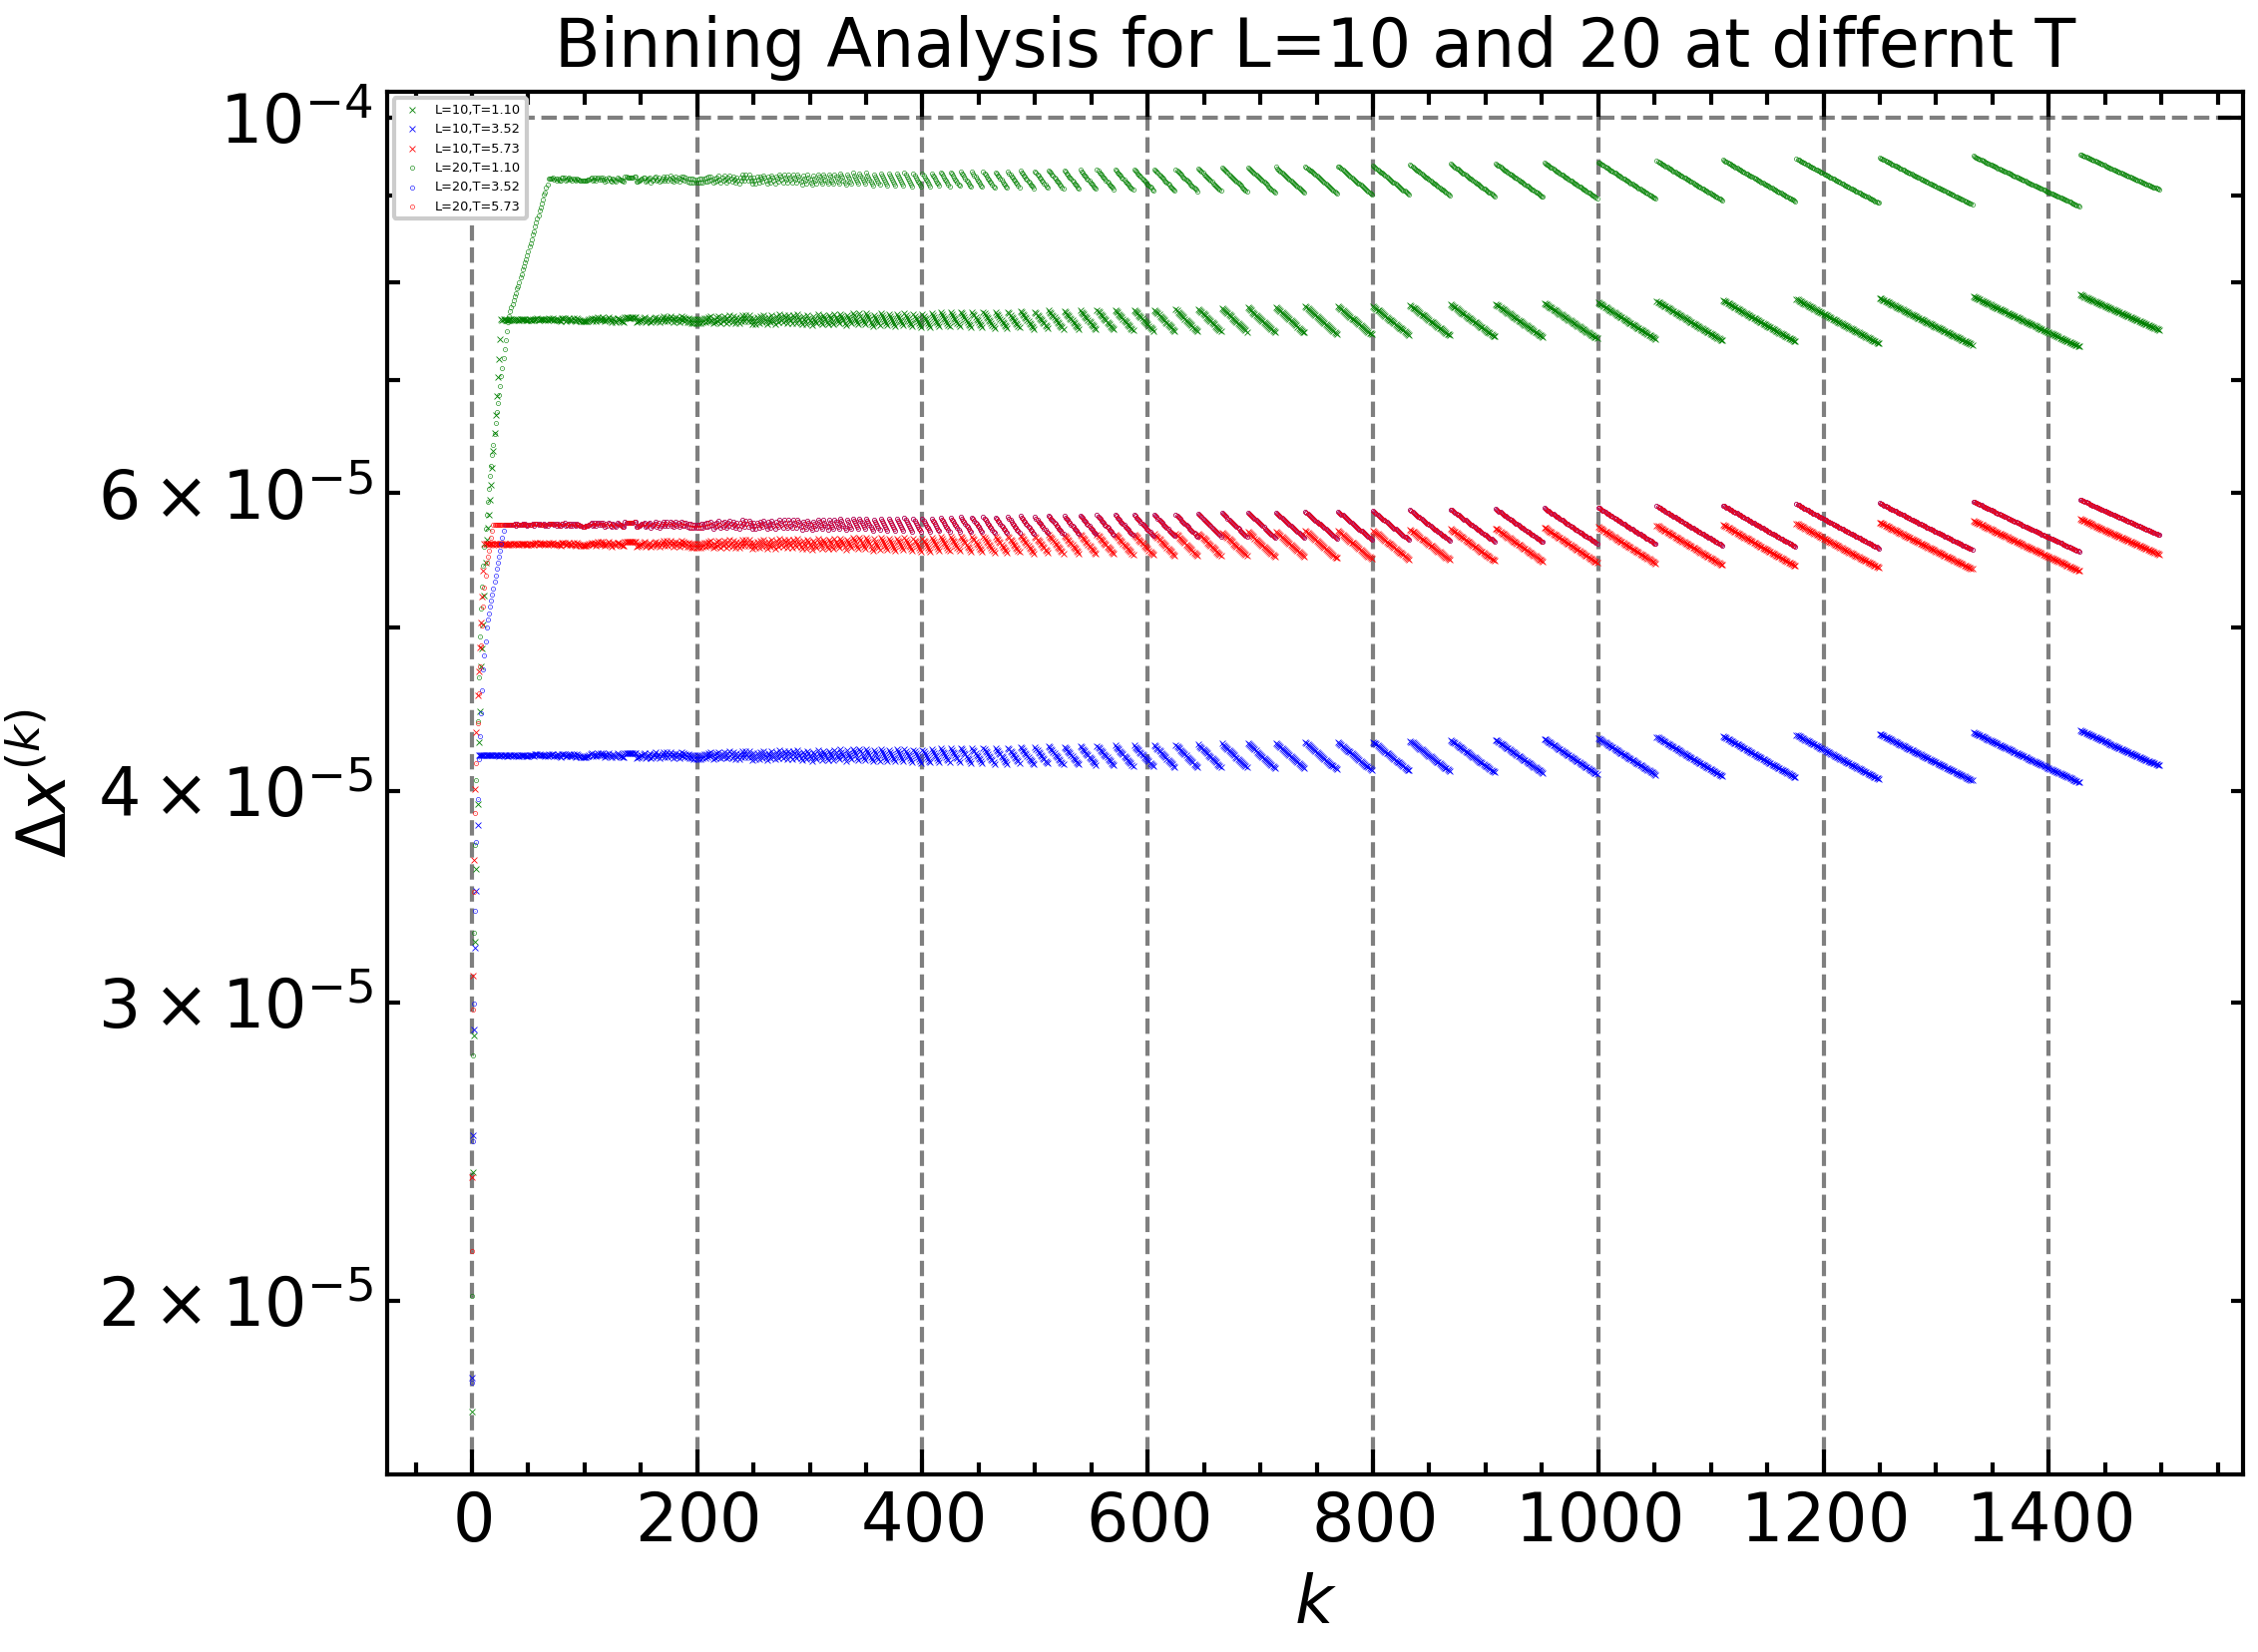

In [79]:
plt.scatter(range(1499),bins_lattice_e_afm_10[0],s=0.02,marker='x',color='g',label='L=10,T=1.10')
plt.scatter(range(1499),bins_lattice_e_afm_10[1],s=0.02,marker='x',color='b',label='L=10,T=3.52')
plt.scatter(range(1499),bins_lattice_e_afm_10[2],s=0.02,marker='x',color='r',label='L=10,T=5.73')
plt.scatter(range(1499),bins_lattice_e_afm_20[0],s=0.02,color='g',label='L=20,T=1.10')
plt.scatter(range(1499),bins_lattice_e_afm_20[1],s=0.02,color='b',label='L=20,T=3.52')
plt.scatter(range(1499),bins_lattice_e_afm_20[2],s=0.02,color='r',label='L=20,T=5.73')
plt.title('Binning Analysis for L=10 and 20 at differnt T')
plt.ylabel(r'$\Delta x^{(k)}$')
plt.xlabel(r'$k$')
plt.yscale('log')
plt
plt.legend(fontsize=3.1)

In [ ]:
with open('bins_m_afm_20.npy', 'wb') as f:
    np.save(f, bins_lattice_m_afm_20)
with open('bins_e_afm_20.npy', 'wb') as g:
    np.save(g, bins_lattice_e_afm_20)

In [86]:
taus_10_afm_m = [] ; taus_20_afm_m = []
taus_10_afm_e = [] ; taus_20_afm_e = []
for i in range(len(T)):
  tau_10 = calculate_auto_corr_time(bins_lattice_m_afm_10,i)
  taus_10_afm_m.append(tau_10)
  tau_20 = calculate_auto_corr_time(bins_lattice_m_afm_20,i)
  taus_20_afm_m.append(tau_20)

  tau_10 = calculate_auto_corr_time(bins_lattice_e_afm_10,i)
  taus_10_afm_e.append(tau_10)
  tau_20 = calculate_auto_corr_time(bins_lattice_e_afm_20,i)
  taus_20_afm_e.append(tau_20)

Text(0.5, 1.0, 'Autocorrelation times for different temperatures and lattice sizes')

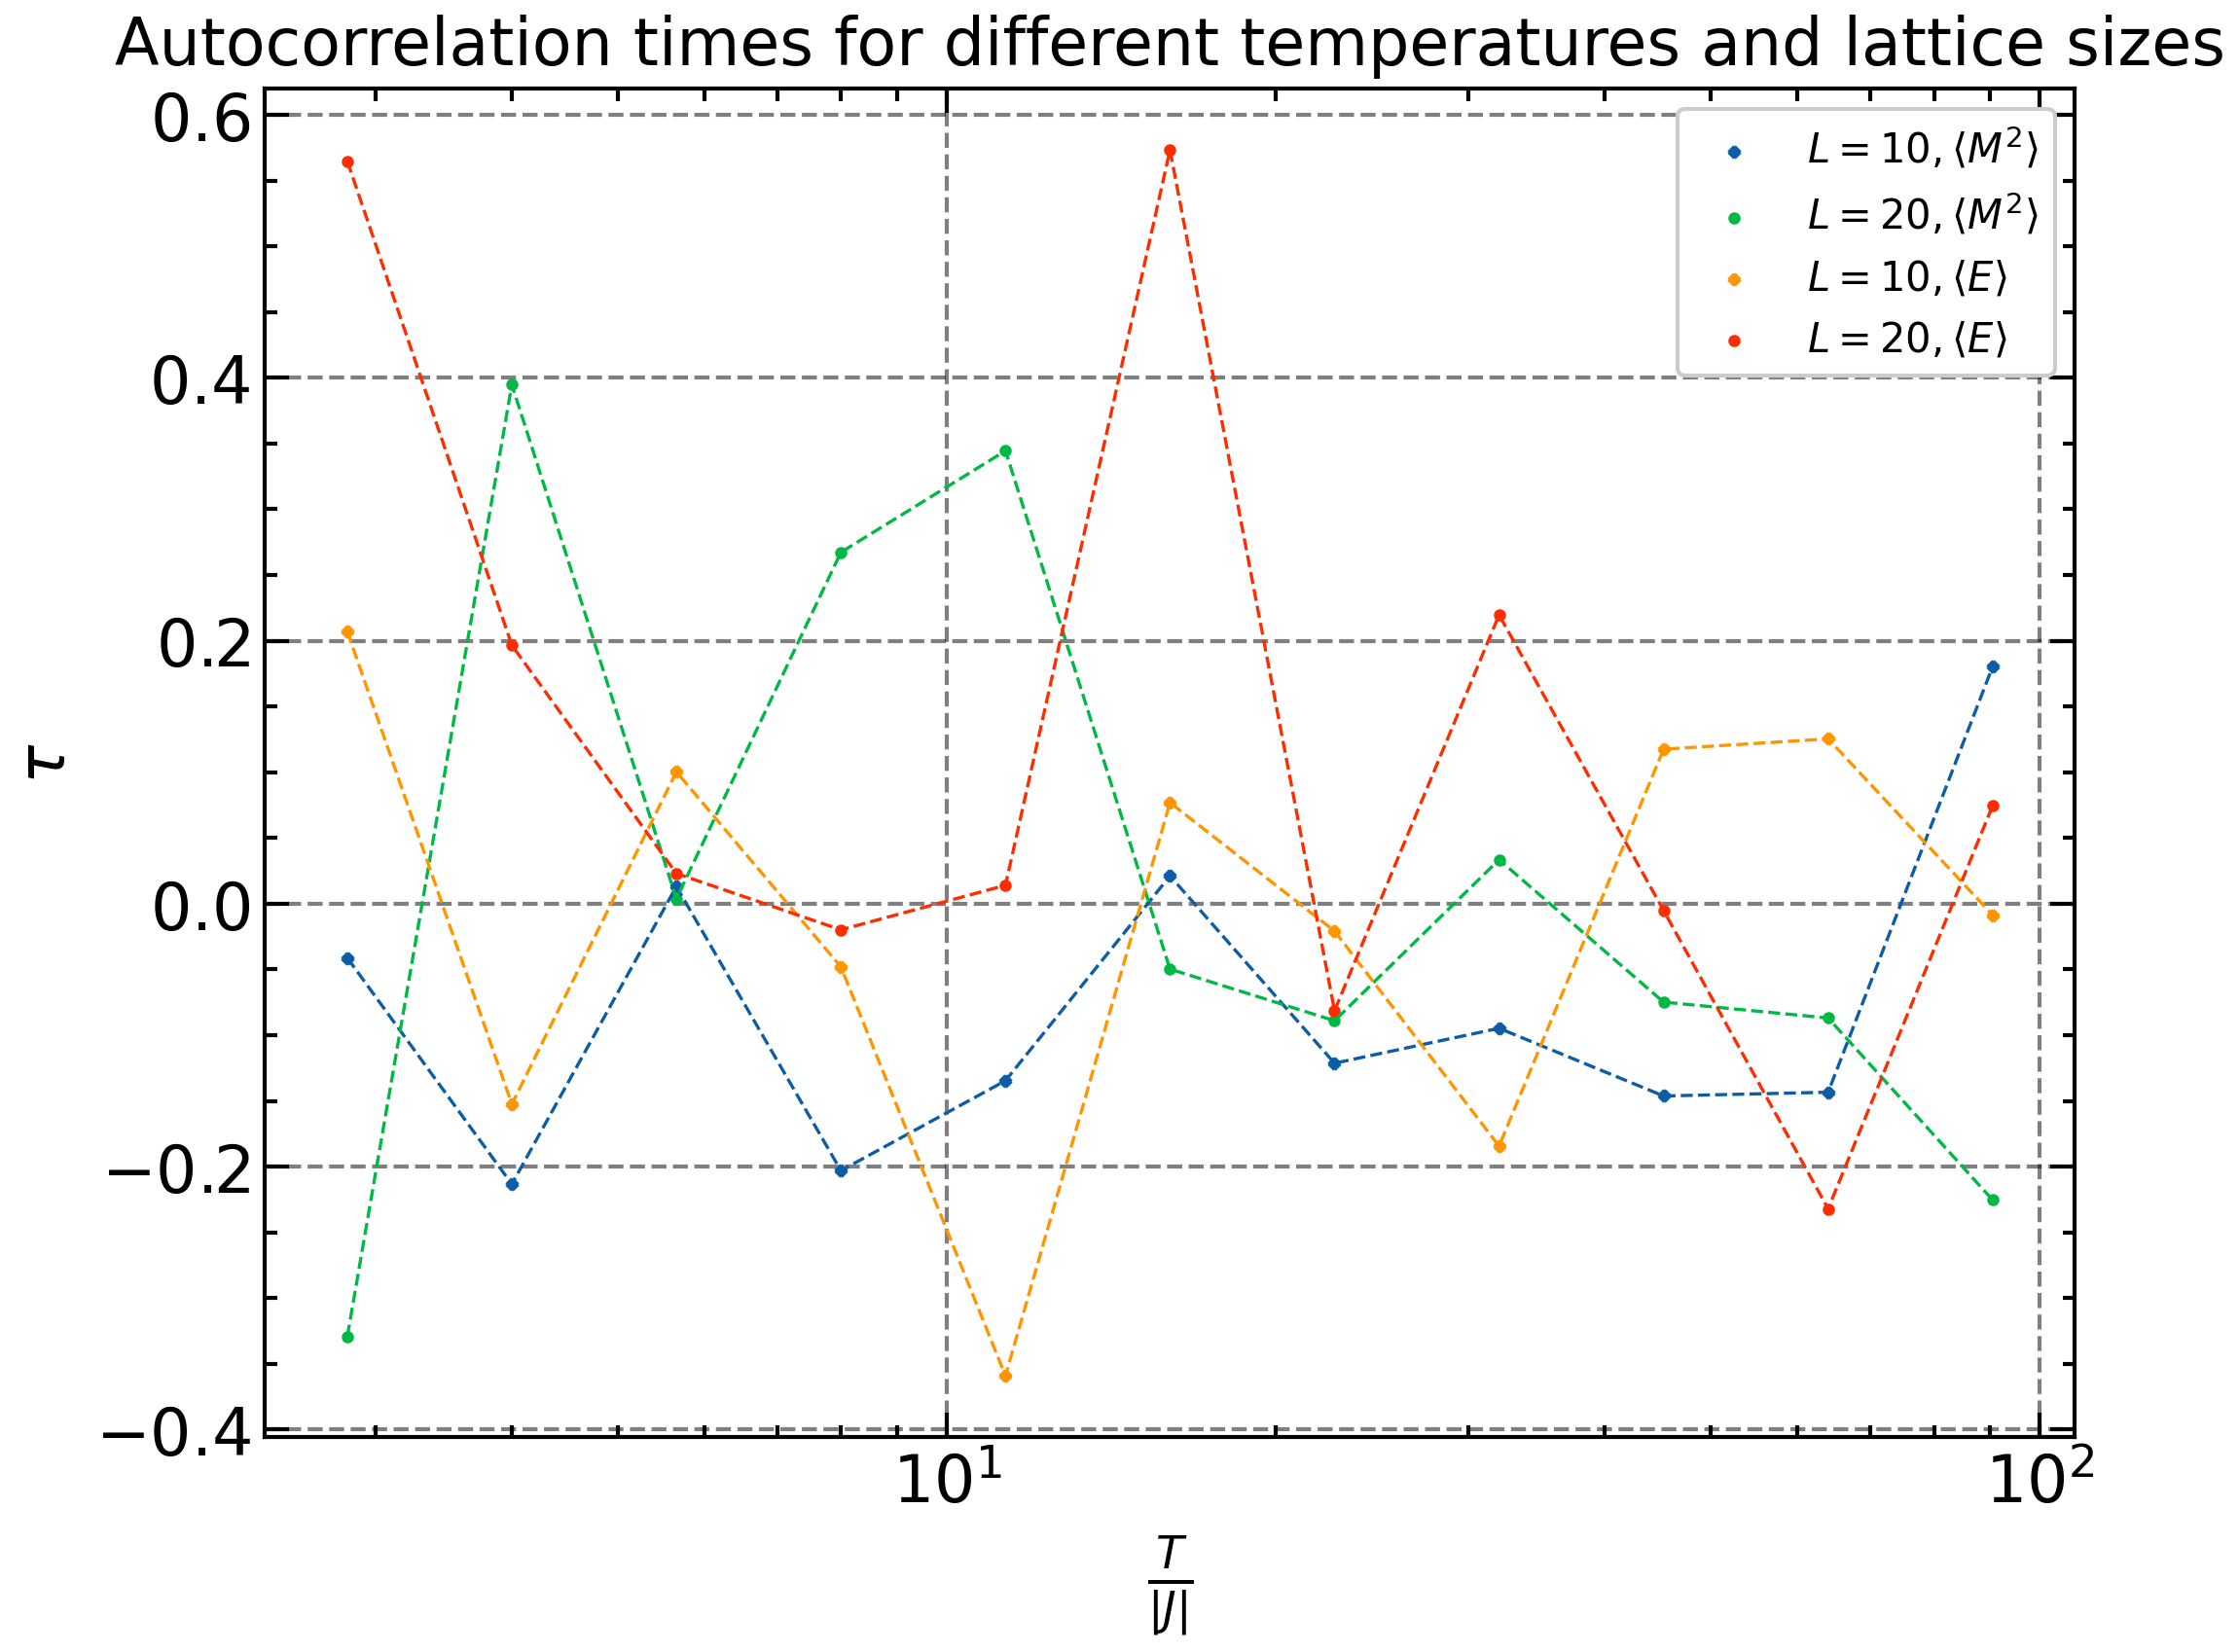

In [139]:
plt.plot(T[9:len(T)],taus_10_afm_m[9:len(T)],'--',lw=0.8)
plt.plot(T[9:len(T)],taus_20_afm_m[9:len(T)],'--',lw=0.8)
plt.plot(T[9:len(T)],taus_10_afm_e[9:len(T)],'--',lw=0.8)
plt.plot(T[9:len(T)],taus_20_afm_e[9:len(T)],'--',lw=0.8)
plt.scatter(T[9:len(T)],taus_10_afm_m[9:len(T)],marker='x',s=4,label=r'$L = 10, \langle M^2 \rangle$')
plt.scatter(T[9:len(T)],taus_20_afm_m[9:len(T)],s=4,label=r'$L = 20, \langle M^2 \rangle$')
plt.scatter(T[9:len(T)],taus_10_afm_e[9:len(T)],marker='x',s=4,label=r'$L = 10, \langle E \rangle$')
plt.scatter(T[9:len(T)],taus_20_afm_e[9:len(T)],s=4,label=r'$L = 20, \langle E \rangle$')
plt.ylabel(r'$\tau$')
plt.xlabel(r'$\frac{T}{|J|}$')
plt.xscale('log')
plt.legend(fontsize=10)
plt.title('Autocorrelation times for different temperatures and lattice sizes')
#plt.savefig('autocorrelations_afm.png',dpi=300)

In [92]:
taus_10_afm_e = np.array(taus_10_afm_e)
taus_20_afm_e = np.array(taus_20_afm_e)
taus_10_afm_m = np.array(taus_10_afm_m)
taus_20_afm_m = np.array(taus_20_afm_m)

taus1020_afm_m = np.vstack([taus_10_afm_m,taus_20_afm_m])
taus1020_afm_e = np.vstack([taus_10_afm_e,taus_20_afm_e])
L = [10,20]
for i in range(2):
  for j in range(len(T)):
    print(f'Energy autocorrelation time for lattice size {L[i]} at Temp {np.round(T[j],2)} = {np.round(taus1020_afm_e[i][j],2)}')
    print(f'Magnetisation autocorrelation time for lattice size {L[i]} at Temp {np.round(T[j],2)} = {np.round(taus1020_afm_m[i][j],2)}')

Energy autocorrelation time for lattice size 10 at Temp 0.12 = 4.45
Magnetisation autocorrelation time for lattice size 10 at Temp 0.12 = -0.18
Energy autocorrelation time for lattice size 10 at Temp 0.18 = 0.87
Magnetisation autocorrelation time for lattice size 10 at Temp 0.18 = -0.02
Energy autocorrelation time for lattice size 10 at Temp 0.25 = 1.08
Magnetisation autocorrelation time for lattice size 10 at Temp 0.25 = 0.03
Energy autocorrelation time for lattice size 10 at Temp 0.35 = 0.83
Magnetisation autocorrelation time for lattice size 10 at Temp 0.35 = -0.06
Energy autocorrelation time for lattice size 10 at Temp 0.5 = 6.34
Magnetisation autocorrelation time for lattice size 10 at Temp 0.5 = 0.5
Energy autocorrelation time for lattice size 10 at Temp 0.71 = 7.75
Magnetisation autocorrelation time for lattice size 10 at Temp 0.71 = 0.04
Energy autocorrelation time for lattice size 10 at Temp 1.0 = 1.56
Magnetisation autocorrelation time for lattice size 10 at Temp 1.0 = -0.03


## 3.2.2 $\textit{Calculation of specific heat}$


In [9]:
#Load the pre computed datasets to perform analysis.
data_10_afm = pd.read_csv('datafiles/lattice_obs_antiferro_10.csv') # L = 10
data_20_afm = pd.read_csv('datafiles/lattice_obs_antiferro_20.csv') # L = 20
data_40_afm = pd.read_csv('datafiles/lattice_obs_antiferro_40.csv') # L = 40
data_80_afm = pd.read_csv('datafiles/lattice_obs_antiferro_80.csv') # L = 80

In [10]:
#calculate specific heats from all datasets using the defintion above
n = np.arange(-12,28,2)
temps = 2**(n/4)

c_v_10_afm = (data_10_afm['<E_2>'] - data_10_afm['<E>']**2)/temps**2
c_v_20_afm = (data_20_afm['<E_2>'] - data_20_afm['<E>']**2)/temps**2
c_v_40_afm = (data_40_afm['<E_2>'] - data_40_afm['<E>']**2)/temps**2
c_v_80_afm = (data_80_afm['<E_2>'] - data_80_afm['<E>']**2)/temps**2

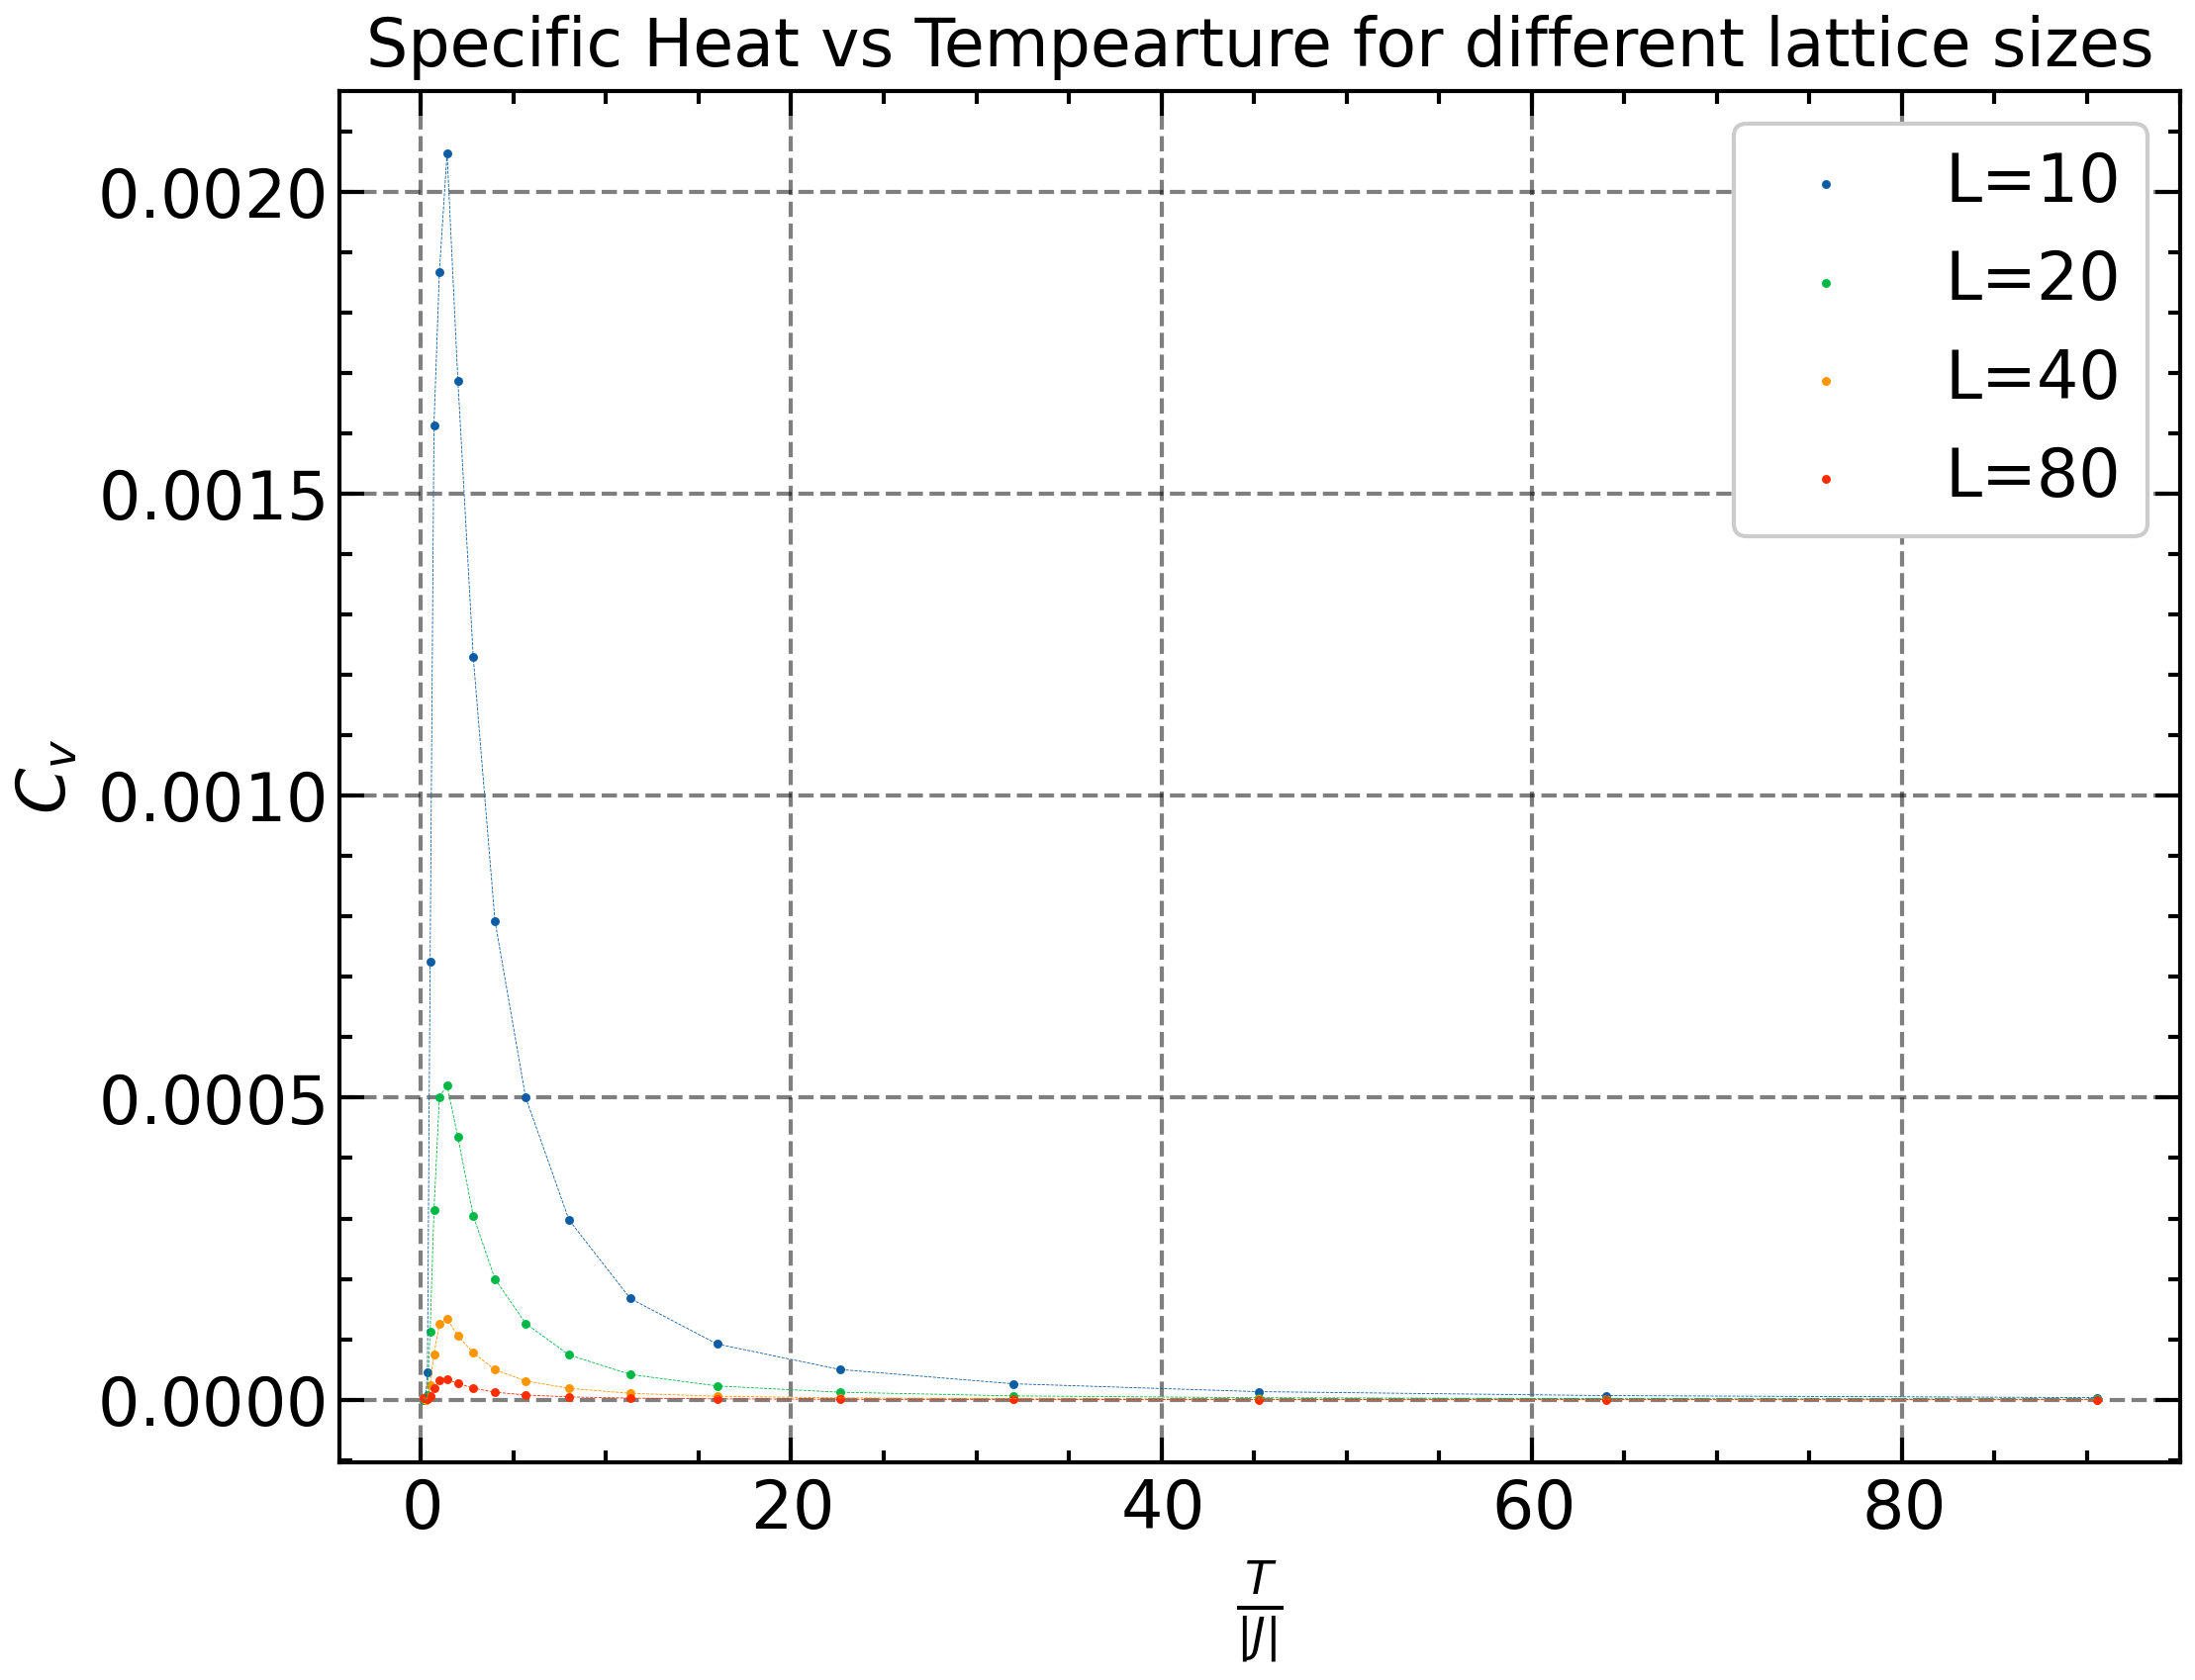

In [11]:
plt.plot(temps,c_v_10_afm,'--',lw=0.2)
plt.plot(temps,c_v_20_afm,'--',lw=0.2)
plt.plot(temps,c_v_40_afm,'--',lw=0.2)
plt.plot(temps,c_v_80_afm,'--',lw=0.2)
plt.scatter(temps,c_v_10_afm,s=1.3,label='L=10')
plt.scatter(temps,c_v_20_afm,s=1.3,label='L=20')
plt.scatter(temps,c_v_40_afm,s=1.3,label='L=40')
plt.scatter(temps,c_v_80_afm,s=1.3,label='L=80')
plt.title('Specific Heat vs Tempearture for different lattice sizes')
plt.ylabel(r'$C_v$') ;
plt.xlabel(r'$\frac{T}{|J|}$')
#plt.xscale('log')
#plt.yscale('log')
plt.legend()
#plt.savefig('specific_heat_afm_norm.png',dpi=300)

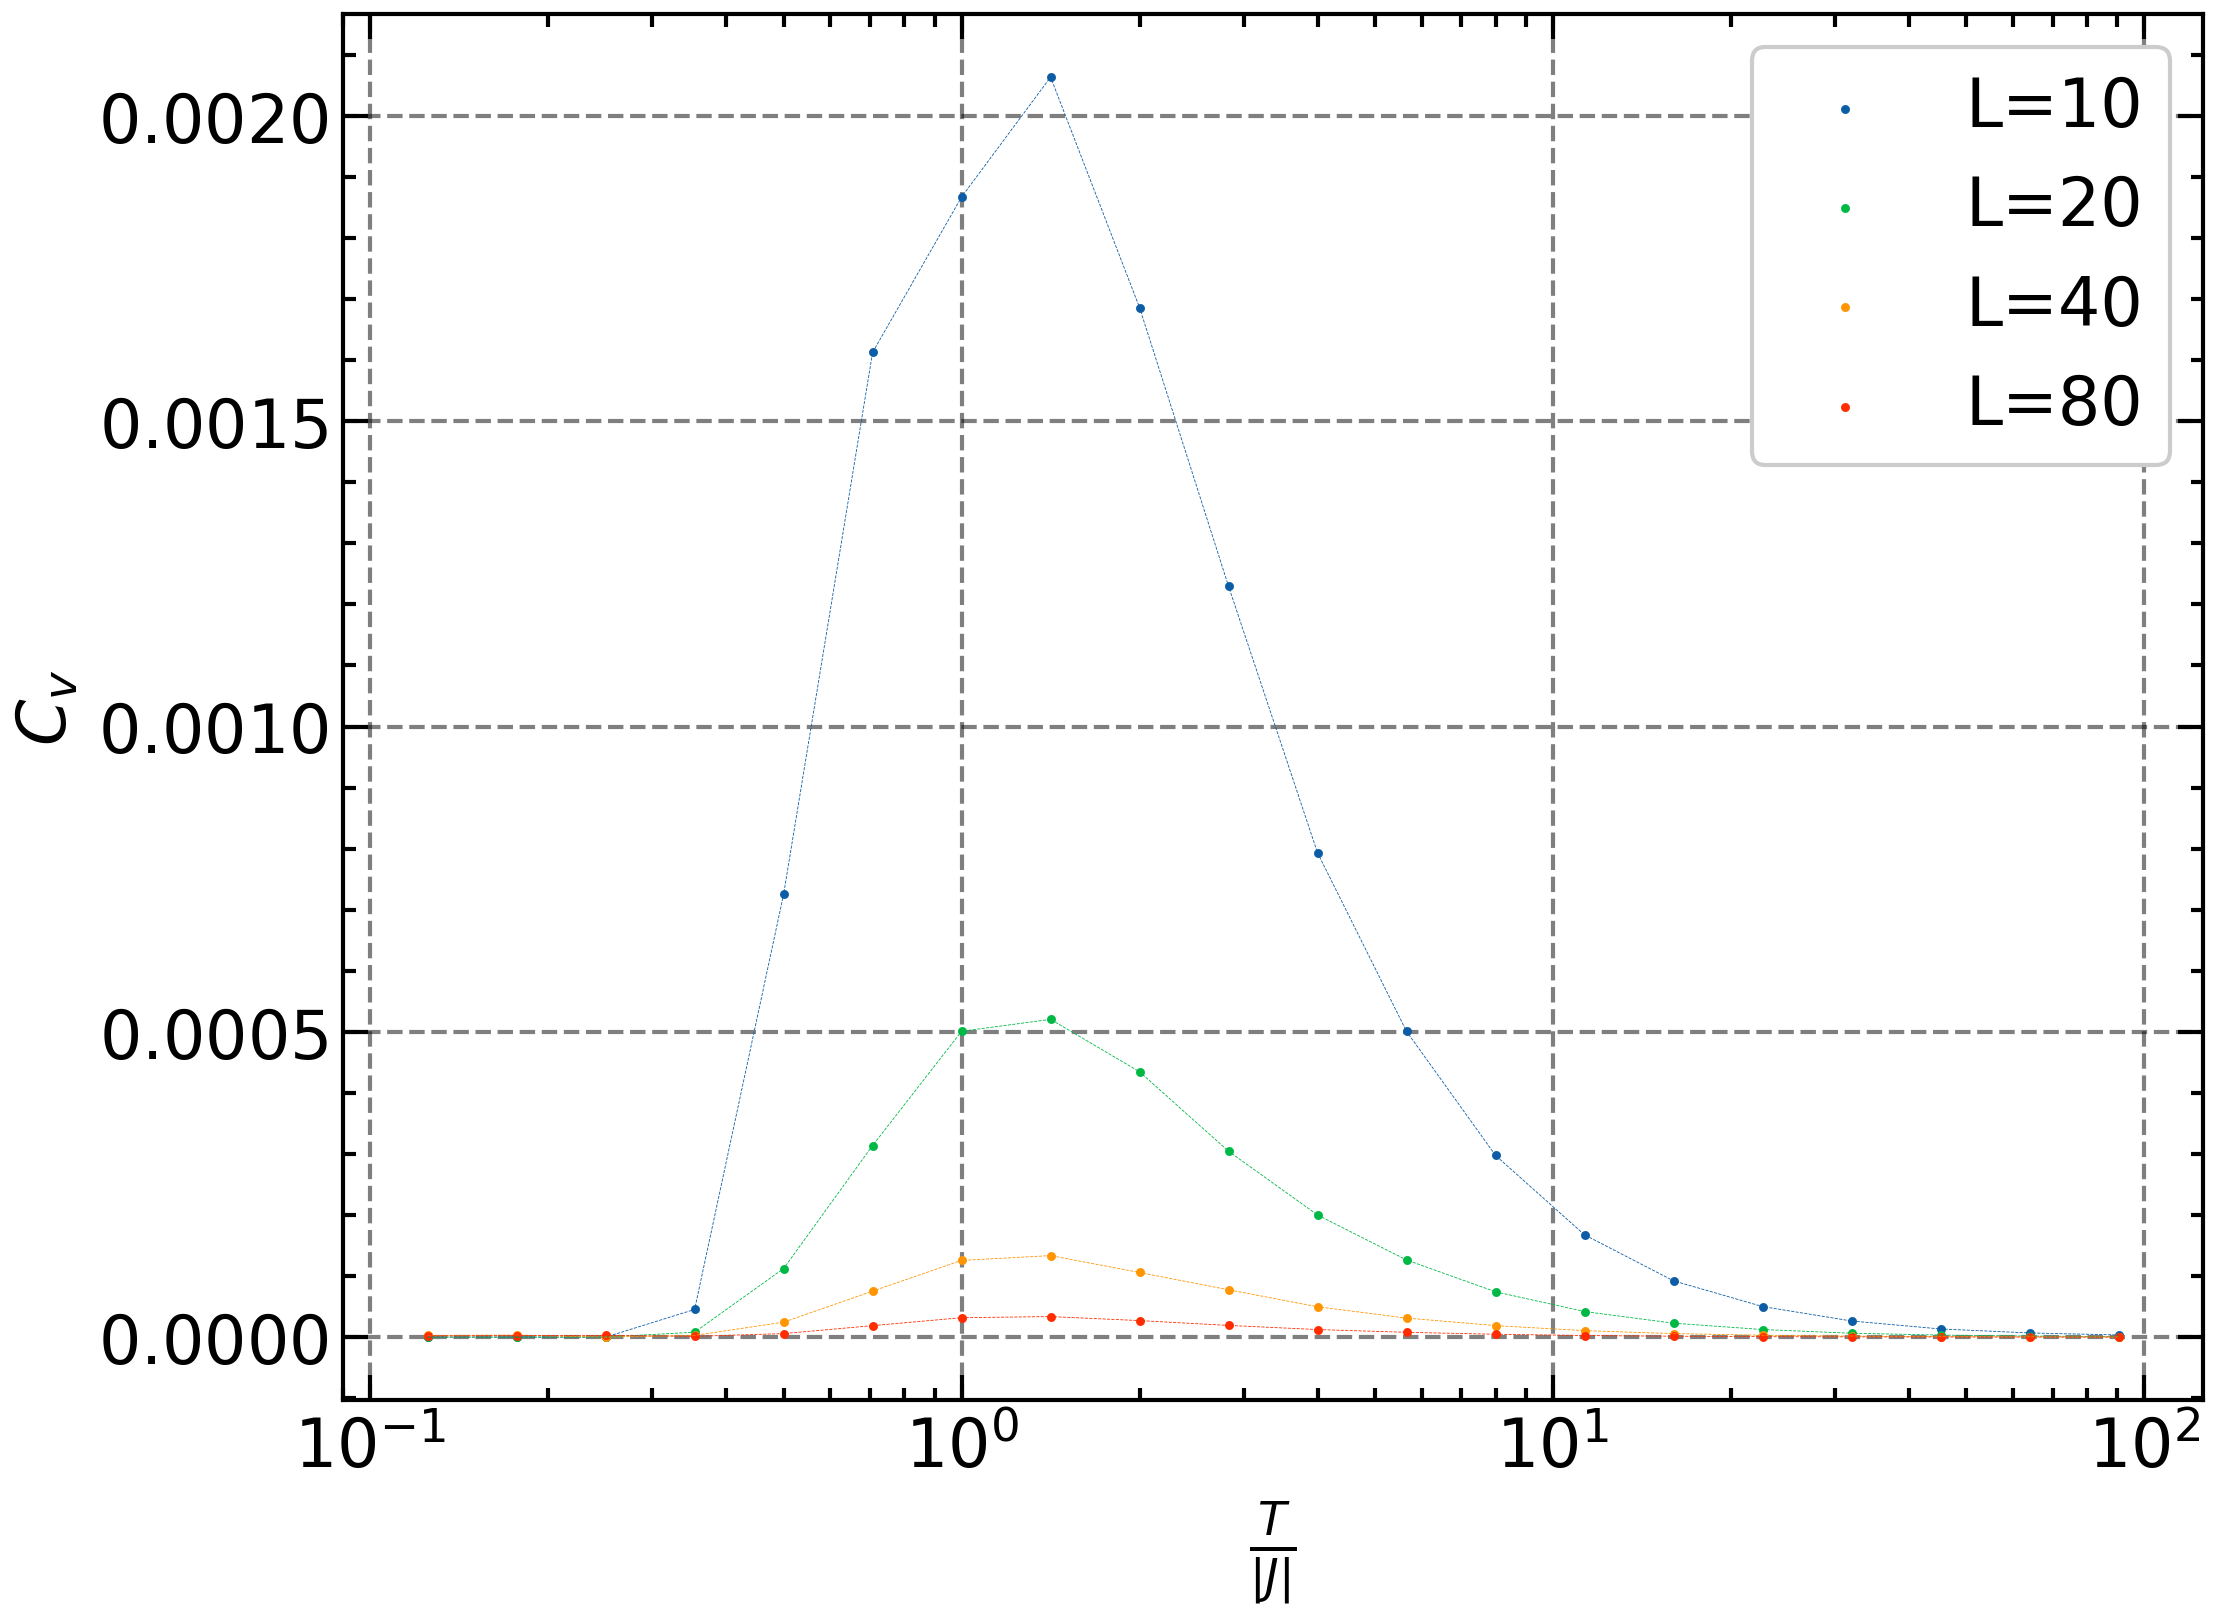

In [23]:
plt.plot(temps,c_v_10_afm,'--',lw=0.2)
plt.plot(temps,c_v_20_afm,'--',lw=0.2)
plt.plot(temps,c_v_40_afm,'--',lw=0.2)
plt.plot(temps,c_v_80_afm,'--',lw=0.2)
plt.scatter(temps,c_v_10_afm,s=1.3,label='L=10')
plt.scatter(temps,c_v_20_afm,s=1.3,label='L=20')
plt.scatter(temps,c_v_40_afm,s=1.3,label='L=40')
plt.scatter(temps,c_v_80_afm,s=1.3,label='L=80')
#plt.title('Specific Heat vs Tempearture for different lattice sizes')
plt.ylabel(r'$C_v$') ;
plt.xlabel(r'$\frac{T}{|J|}$')
#plt.xscale('log')
plt.xscale('log')
plt.legend()
plt.savefig('specific_heat_afm_log.png',dpi=300)

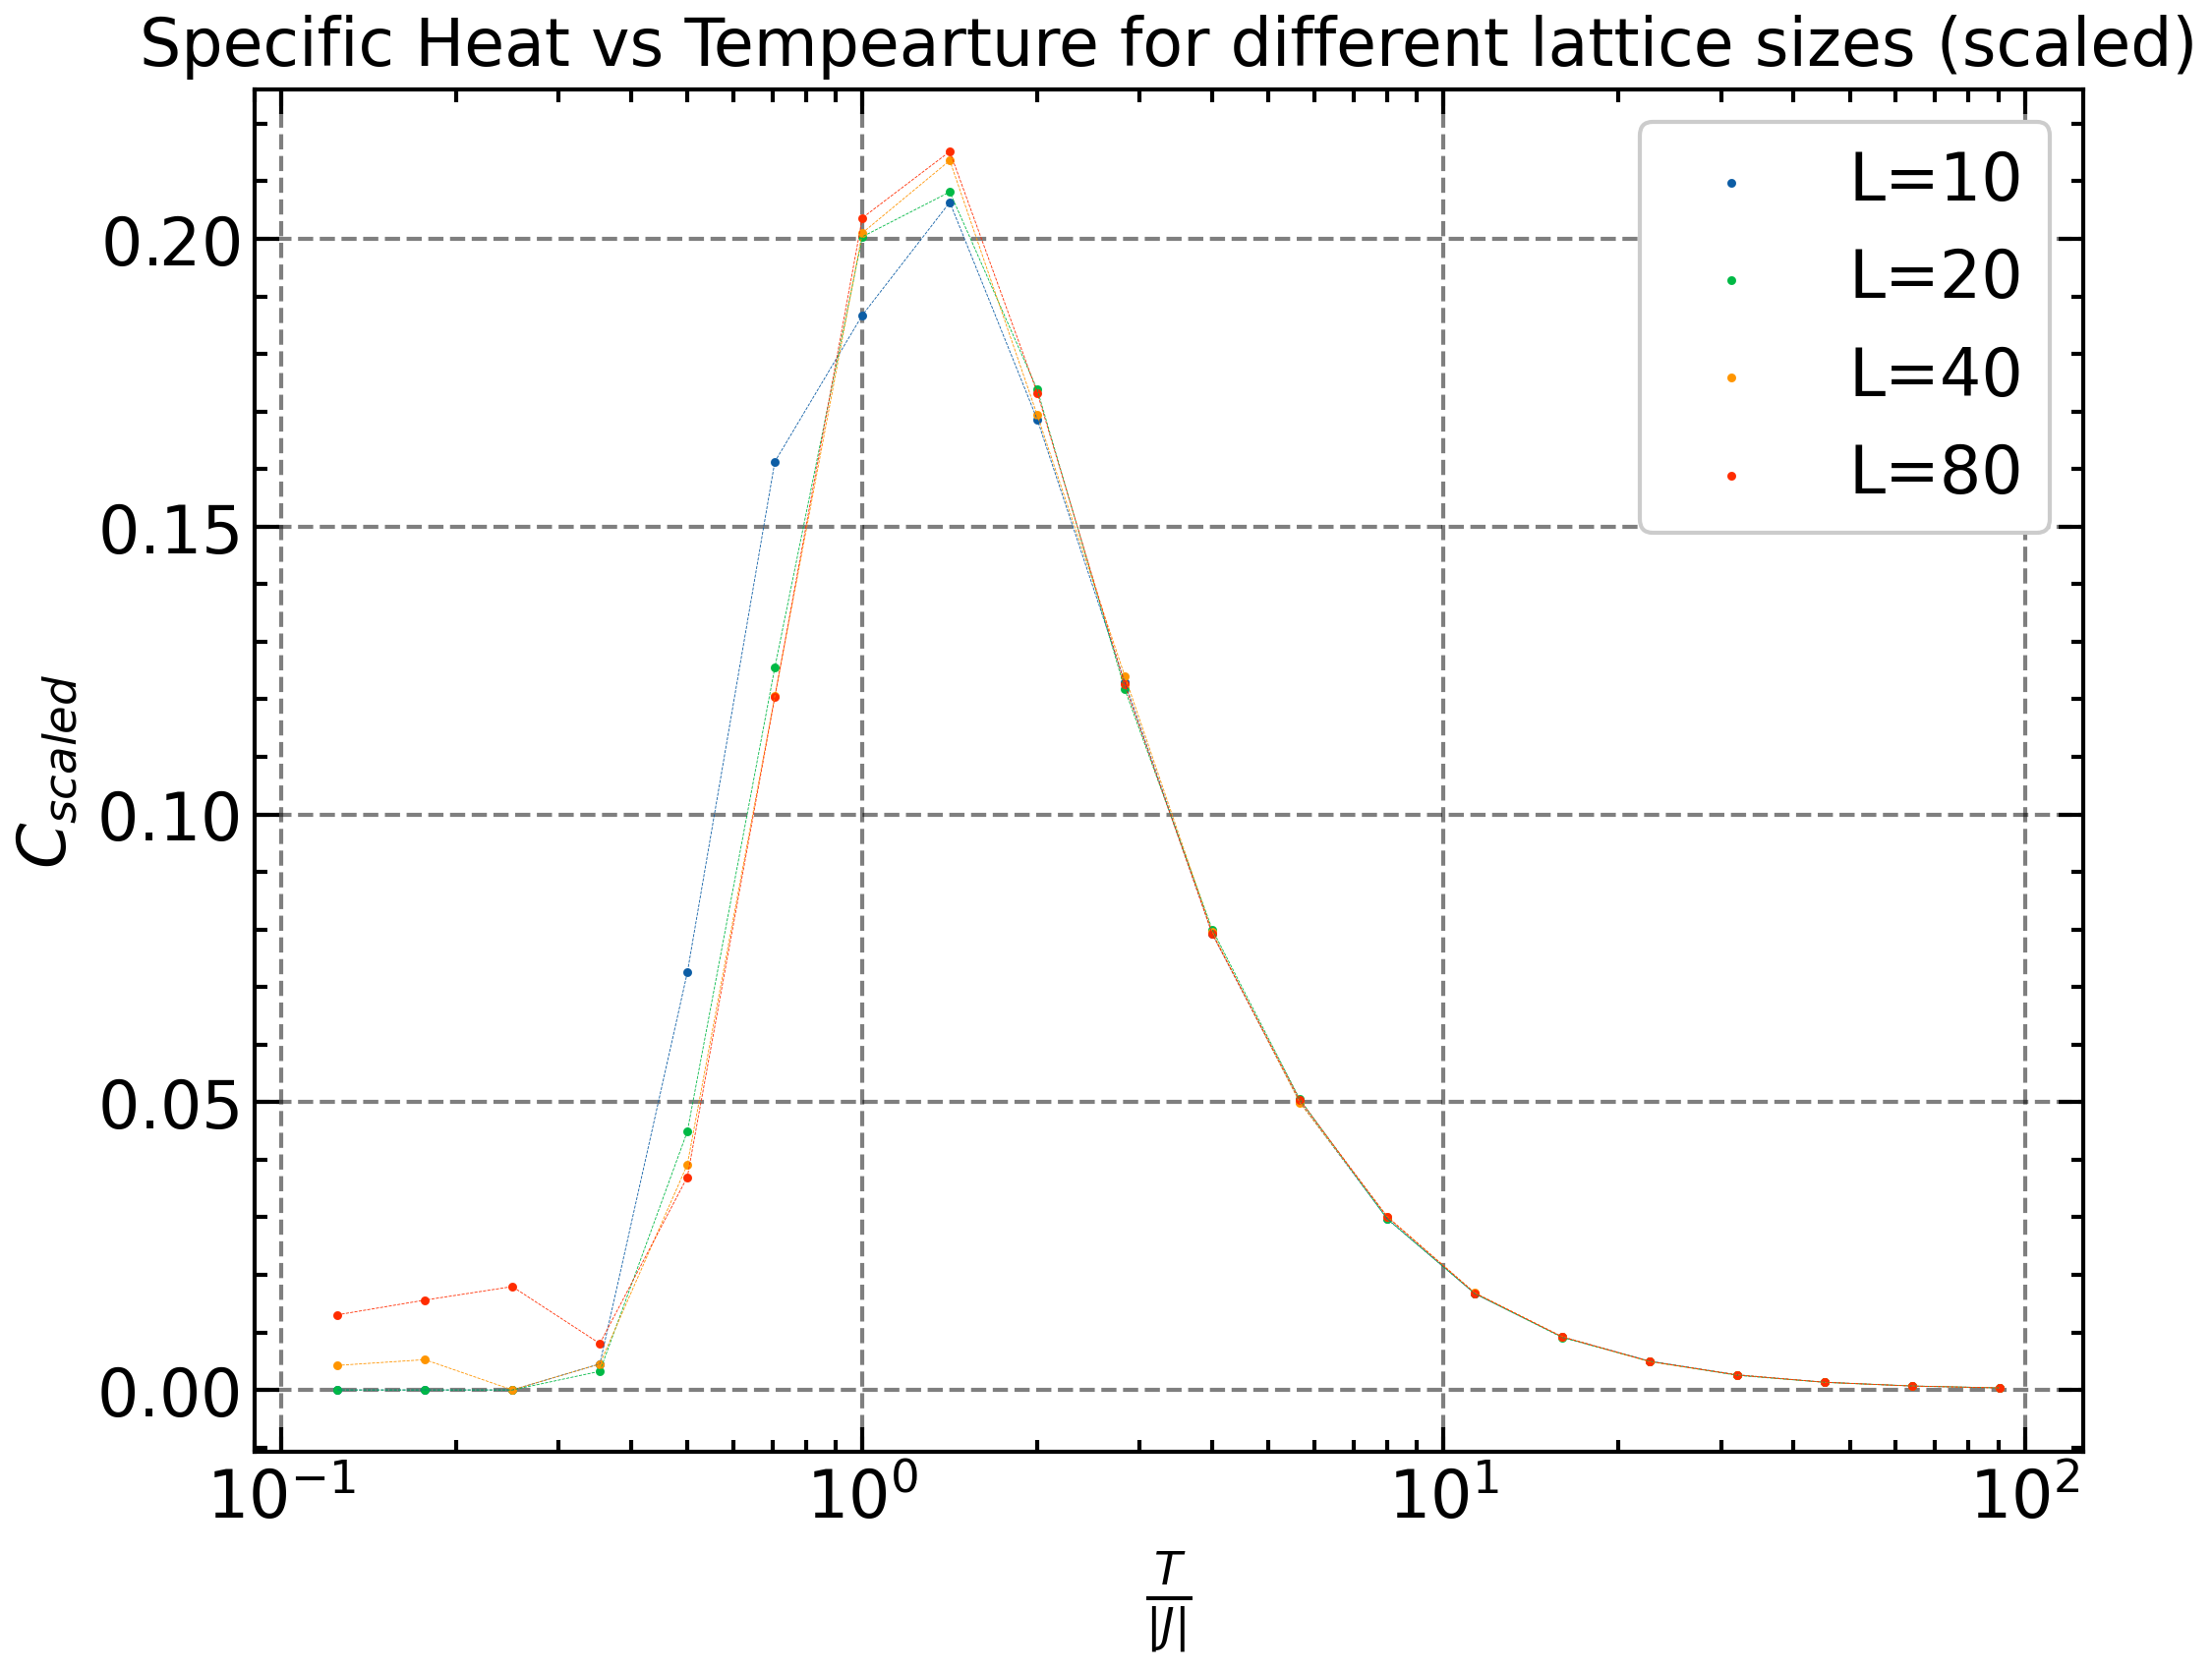

In [13]:
plt.plot(temps,c_v_10_afm*10**2,'--',lw=0.2)
plt.plot(temps,c_v_20_afm*20**2,'--',lw=0.2)
plt.plot(temps,c_v_40_afm*40**2,'--',lw=0.2)
plt.plot(temps,c_v_80_afm*80**2,'--',lw=0.2)
plt.scatter(temps,c_v_10_afm*10**2,s=1.3,label='L=10')
plt.scatter(temps,c_v_20_afm*20**2,s=1.3,label='L=20')
plt.scatter(temps,c_v_40_afm*40**2,s=1.3,label='L=40')
plt.scatter(temps,c_v_80_afm*80**2,s=1.3,label='L=80')
plt.title('Specific Heat vs Tempearture for different lattice sizes (scaled)')
plt.ylabel(r'$C_{scaled}$') ;
plt.xlabel(r'$\frac{T}{|J|}$')
plt.xscale('log')
#plt.yscale('log')
plt.legend()
#plt.savefig('specific_heat_afm_norm_scaled.png',dpi=300)

## 3.2.3 $\textit{Calculation of residual entropy}$

$\textbf{The thermodynamics entropy (S) can be defined as,}$
\begin{equation}
\boxed{S = \int\frac{C_v}{T}}
\end{equation}

In [128]:
#Compute Zero point entropy using above expression by numerically integrating. with an upper bound of ln(2)
Ls = [10,20,40,80]
def calculate_entropy(data,temps,L):
  specific_heat = (data['<E_2>'] - data['<E>']**2)/temps**2
  entropy = np.log(2) - simps(specific_heat*L**2/temps,temps) #perform a numerical integration
  return entropy

entropies = []

#compute entropy from all lattice data files

for i in Ls:
  name = str(str('lattice_obs_antiferro_') + str(i)  + str('.csv'))
  data = pd.read_csv(name)
  entropies.append(calculate_entropy(data,temps,i))

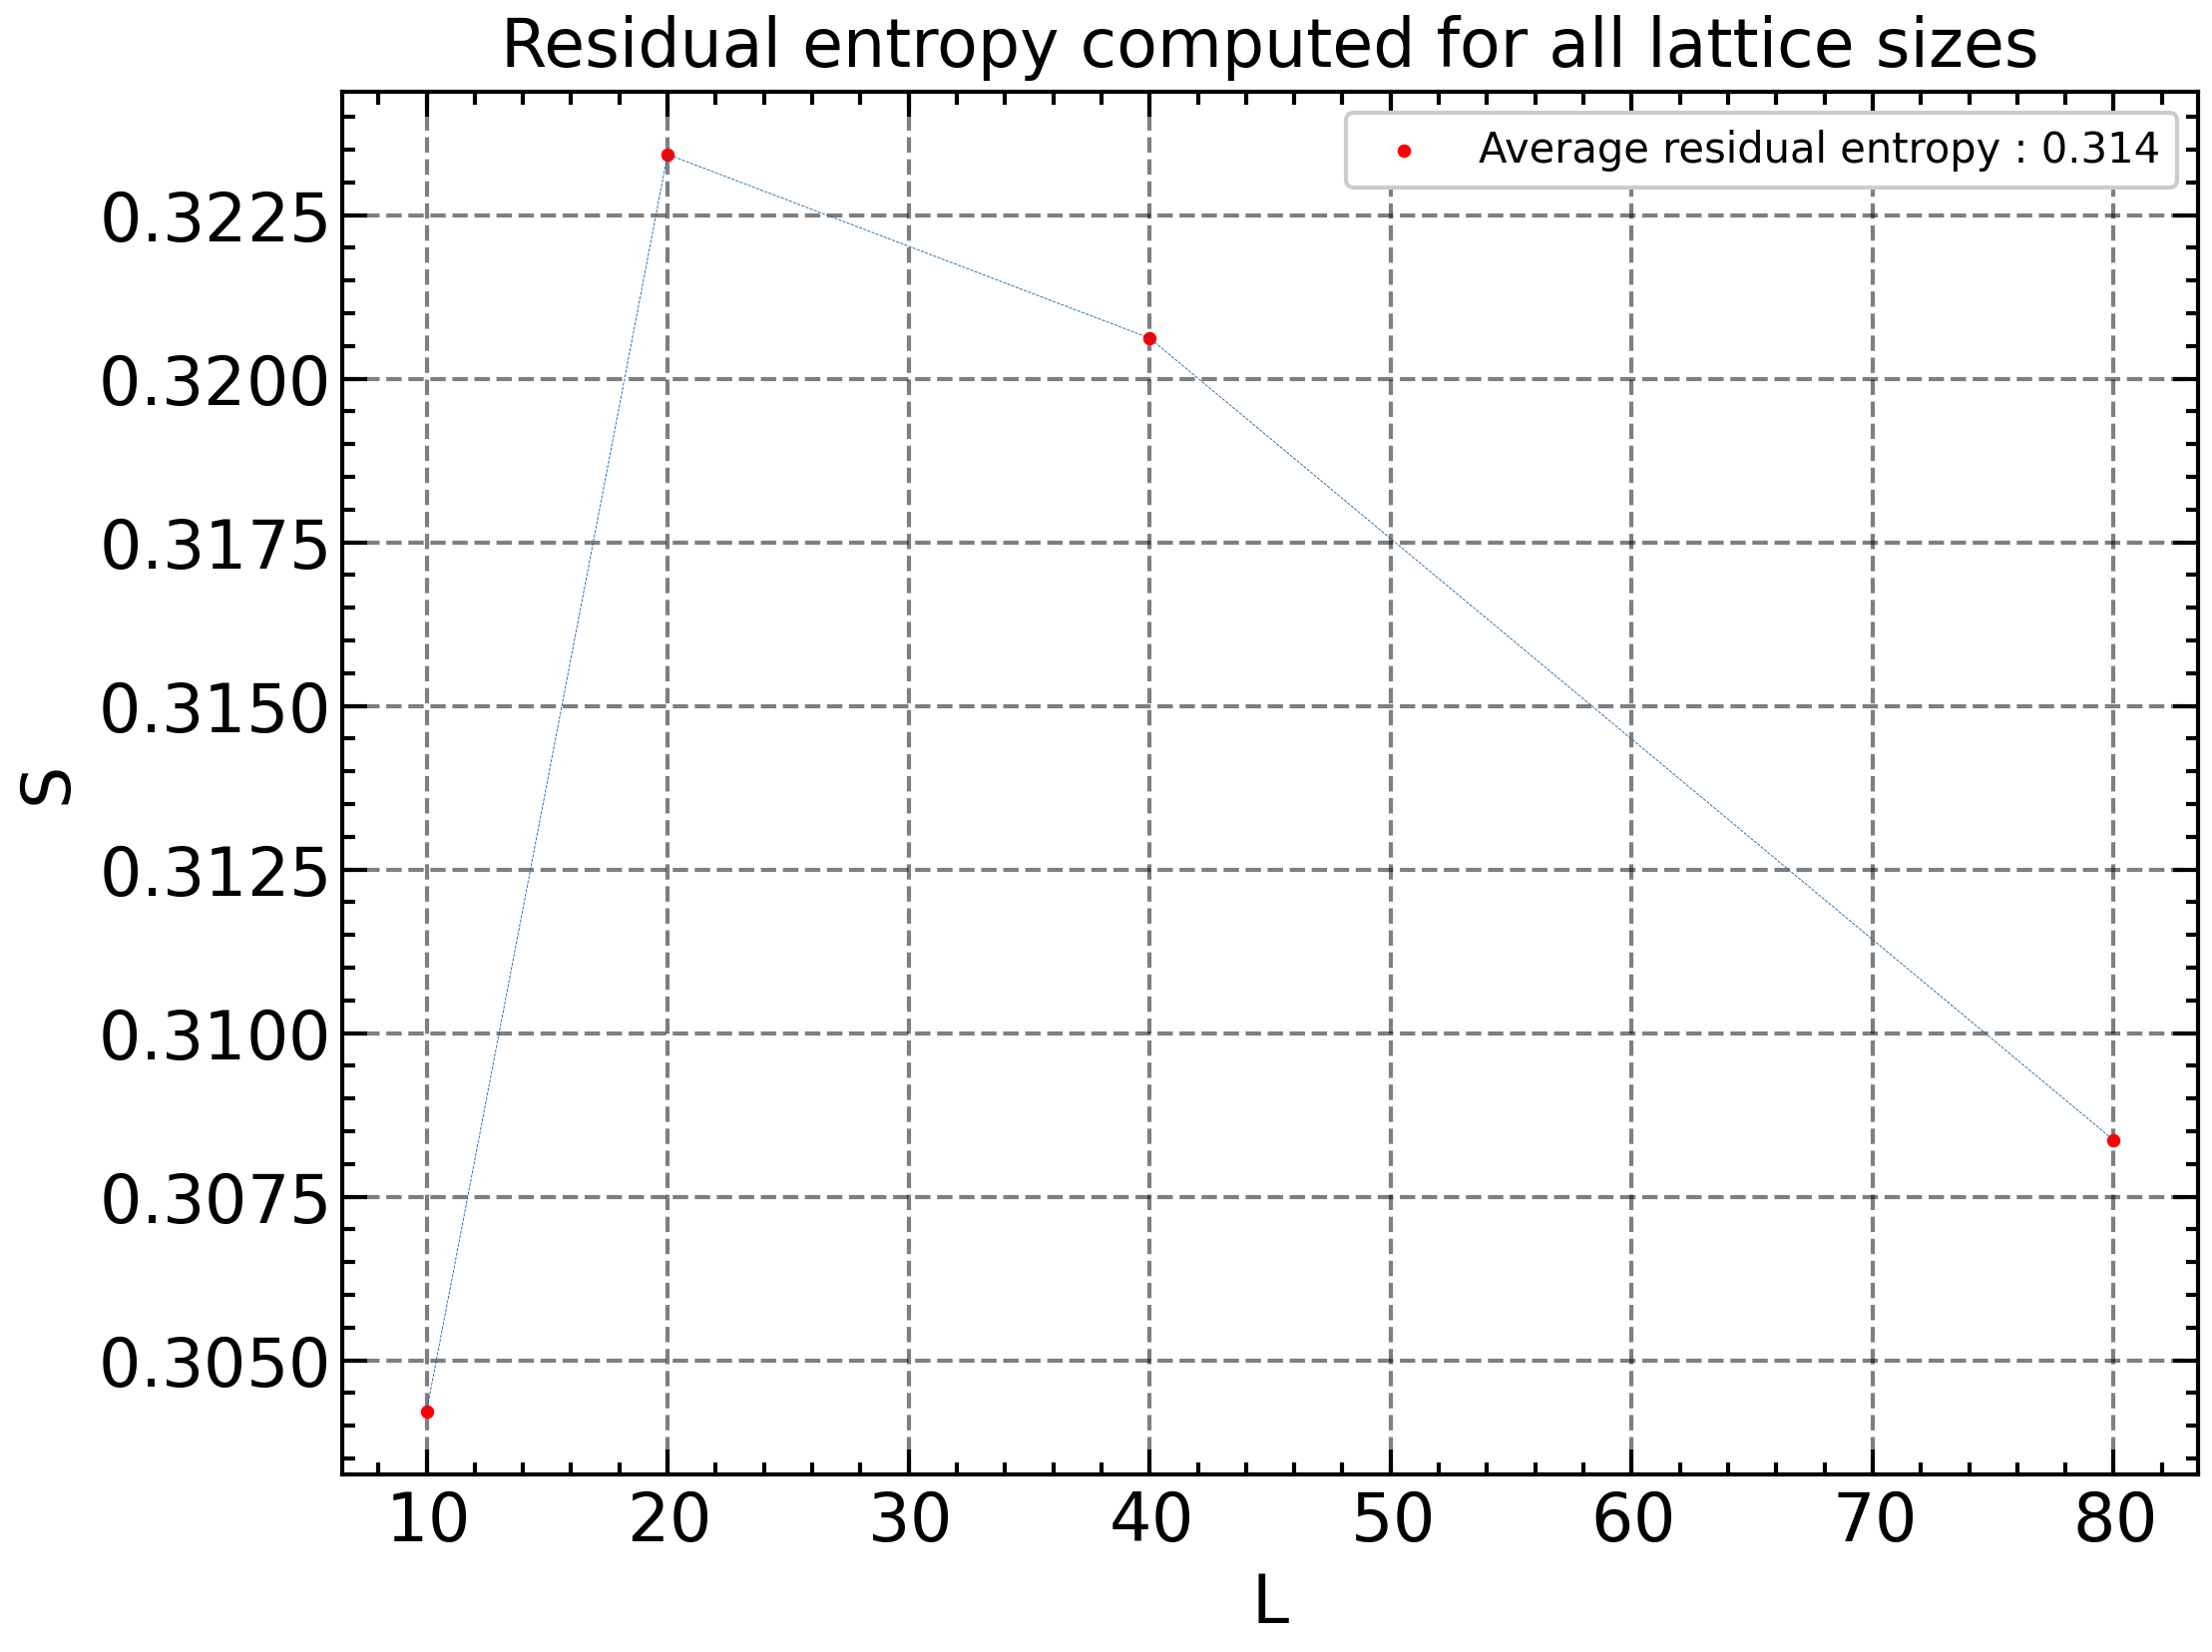

In [137]:
avg_entropy = np.round(np.mean(entropies),3)
plt.plot(Ls,entropies,'--',lw=0.2)
plt.scatter(Ls,entropies,s=5,color='r',label=f'Average residual entropy : {avg_entropy}')
plt.title('Residual entropy computed for all lattice sizes')
plt.xlabel('L') ; plt.ylabel('S')
plt.legend(fontsize=10)
#plt.savefig('resentplot.png',dpi=300)

## 3.2.4 $\textit{Magnetisation vs Magnetic field}$

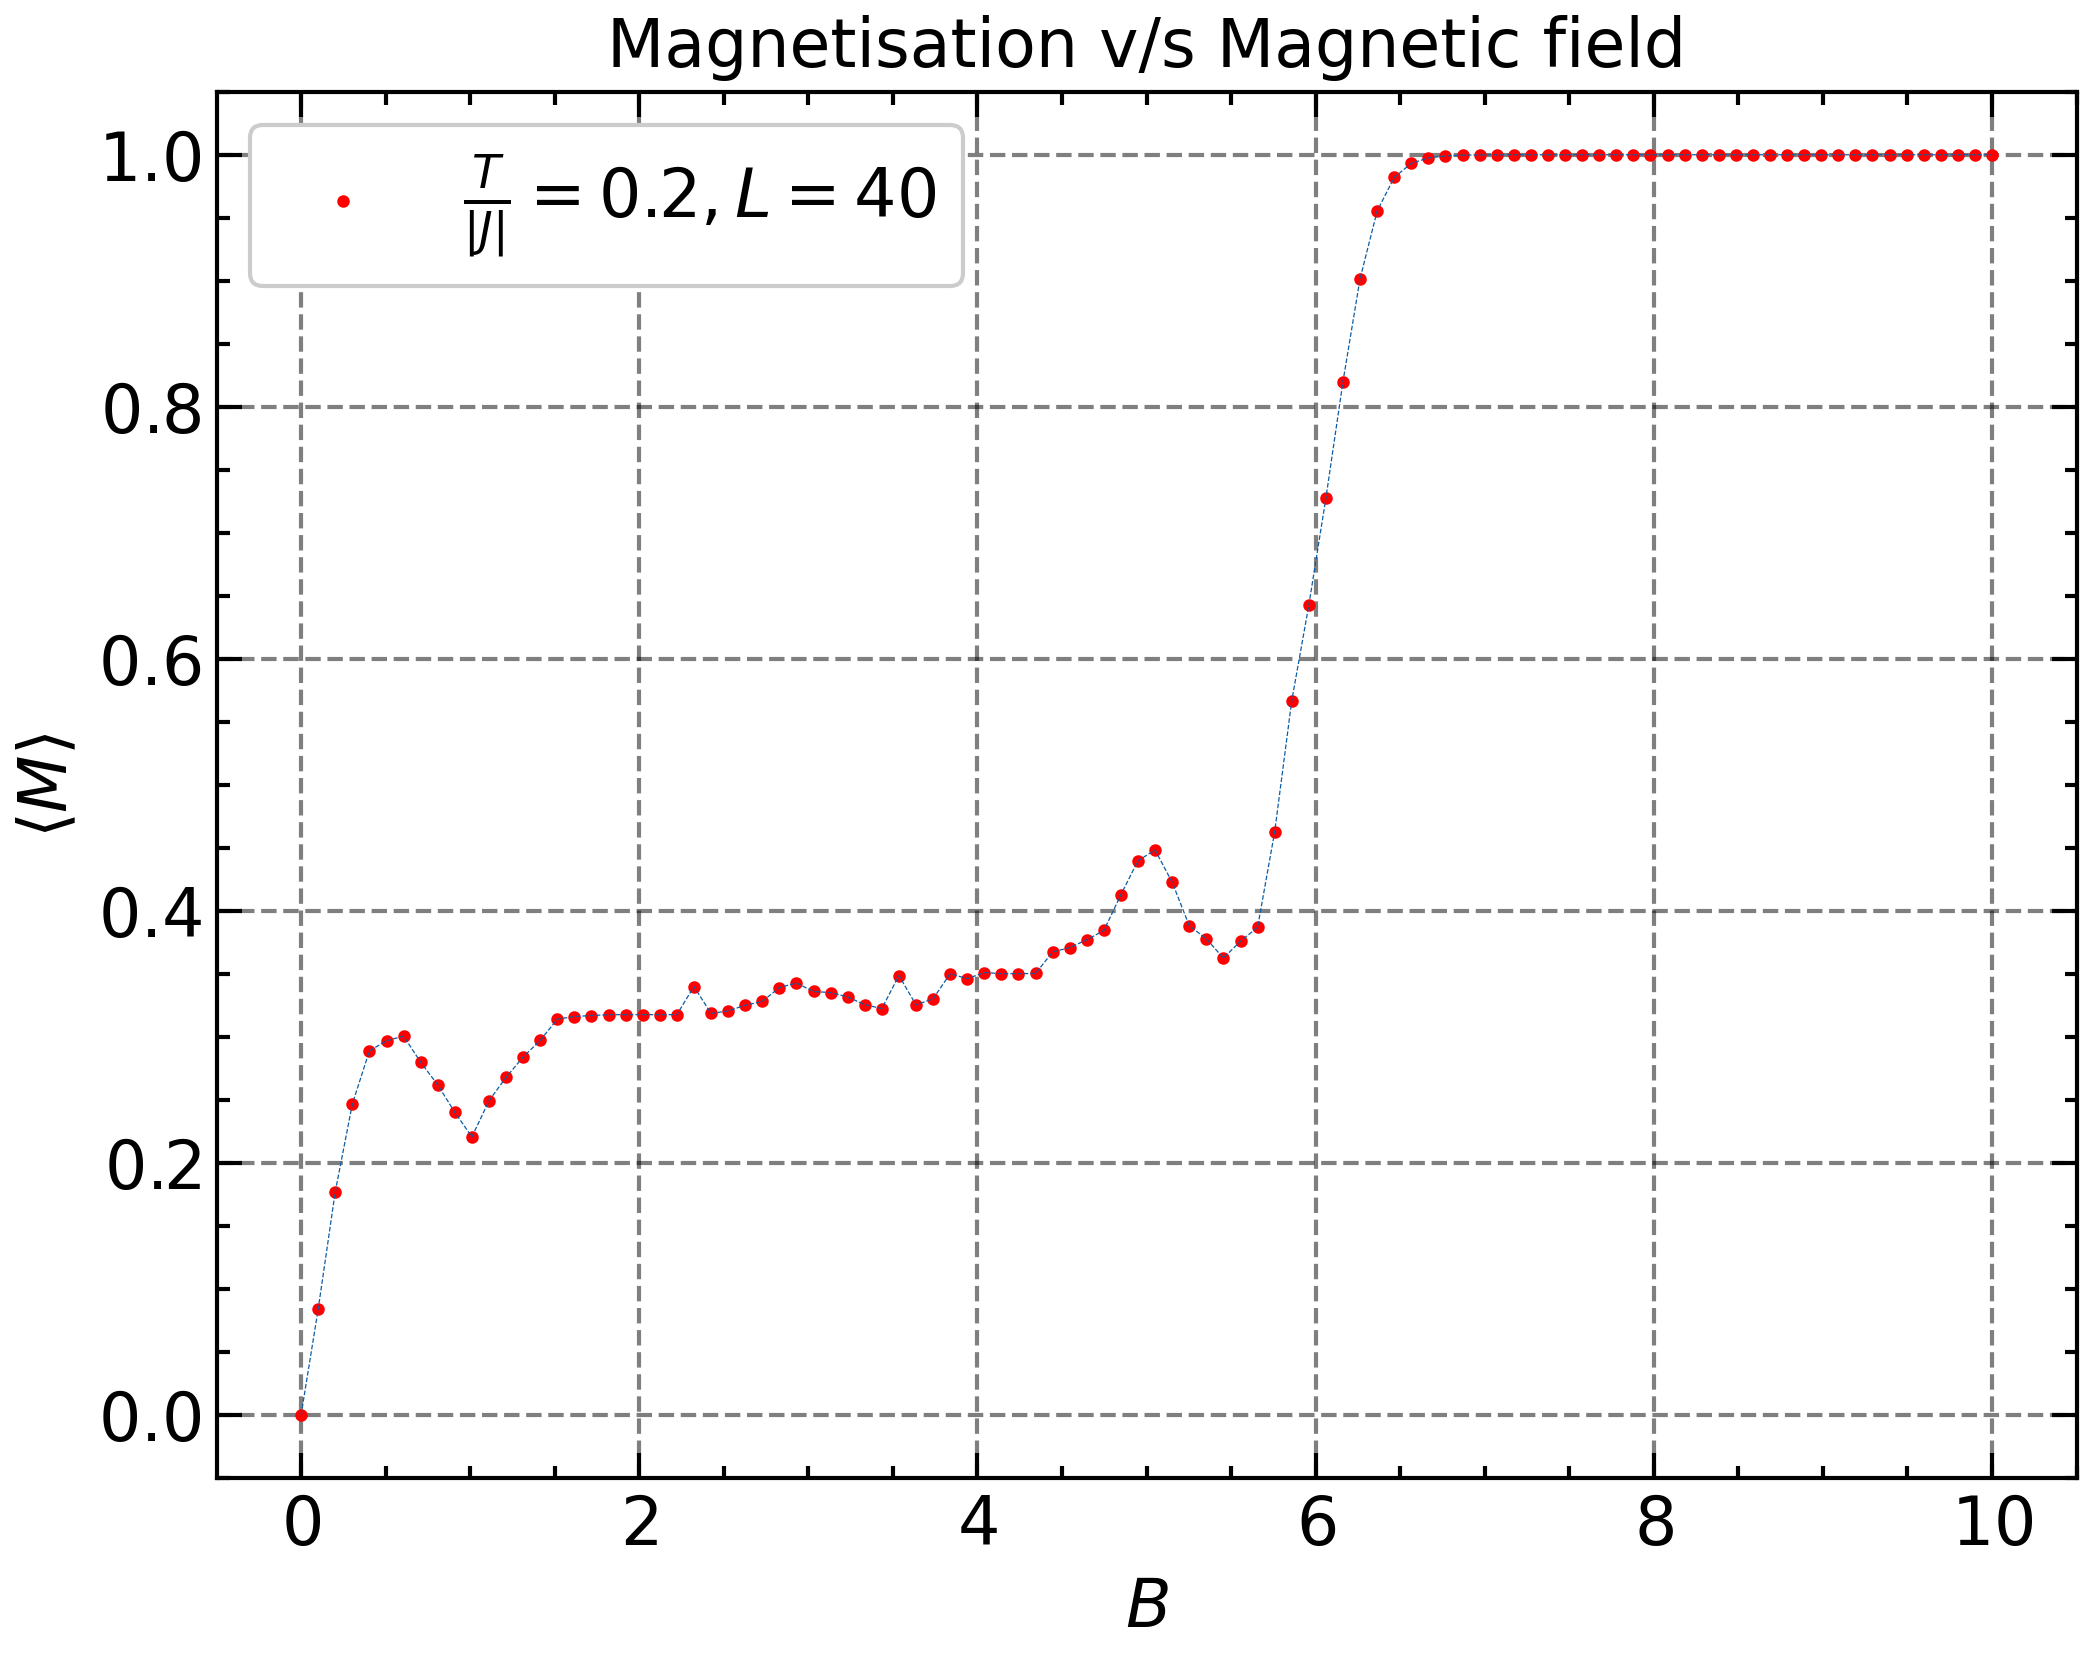

In [9]:
B = np.linspace(0,10,100)#Define the B sweep array

data_b = pd.read_csv('datafiles/lattice_obs_antiferromagnet_40.csv')
M = data_b['<M>']
plt.plot(B,M,'--',lw=0.3)
plt.scatter(B,M,s=4,color='r',label=r'$\frac{T}{|J|} = 0.2, L = 40$')
plt.title("Magnetisation v/s Magnetic field")
plt.xlabel(r'$B$')
plt.ylabel(r'$\langle M \rangle$')
plt.legend()
#plt.savefig('magvsmagfield.png',dpi=300)